In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV4'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.horizontal_and_vertical_flip_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(495000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.freehand_v4(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 128, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 16)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 64, 16)         64        
_________________________________________________________________
dense (Dense)                (None, 1, 64, 256)        4352  

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/436 [..............................] - ETA: 1:40:34 - loss: 2.8014

  3/436 [..............................] - ETA: 11s - loss: 2.7621    

  6/436 [..............................] - ETA: 10s - loss: 2.7083

  9/436 [..............................] - ETA: 10s - loss: 2.6655

 12/436 [..............................] - ETA: 10s - loss: 2.6293

 15/436 [>.............................] - ETA: 10s - loss: 2.5973

 18/436 [>.............................] - ETA: 10s - loss: 2.5677

 21/436 [>.............................] - ETA: 10s - loss: 2.5407

 24/436 [>.............................] - ETA: 10s - loss: 2.5158

 27/436 [>.............................] - ETA: 9s - loss: 2.4926 

 30/436 [=>............................] - ETA: 9s - loss: 2.4705

 33/436 [=>............................] - ETA: 9s - loss: 2.4494

 36/436 [=>............................] - ETA: 9s - loss: 2.4291

 39/436 [=>............................] - ETA: 9s - loss: 2.4097

 42/436 [=>............................] - ETA: 9s - loss: 2.3910

 45/436 [==>...........................] - ETA: 9s - loss: 2.3731

 48/436 [==>...........................] - ETA: 9s - loss: 2.3558

 51/436 [==>...........................] - ETA: 9s - loss: 2.3391

 54/436 [==>...........................] - ETA: 9s - loss: 2.3231

 57/436 [==>...........................] - ETA: 9s - loss: 2.3075

 60/436 [===>..........................] - ETA: 9s - loss: 2.2925

 63/436 [===>..........................] - ETA: 9s - loss: 2.2780

 66/436 [===>..........................] - ETA: 8s - loss: 2.2640

 69/436 [===>..........................] - ETA: 8s - loss: 2.2505

 72/436 [===>..........................] - ETA: 8s - loss: 2.2375

 75/436 [====>.........................] - ETA: 8s - loss: 2.2248

 78/436 [====>.........................] - ETA: 8s - loss: 2.2125

 81/436 [====>.........................] - ETA: 8s - loss: 2.2006

 84/436 [====>.........................] - ETA: 8s - loss: 2.1890

 87/436 [====>.........................] - ETA: 8s - loss: 2.1779

 90/436 [=====>........................] - ETA: 8s - loss: 2.1671

 93/436 [=====>........................] - ETA: 8s - loss: 2.1566

 96/436 [=====>........................] - ETA: 8s - loss: 2.1464

 99/436 [=====>........................] - ETA: 8s - loss: 2.1366

102/436 [======>.......................] - ETA: 8s - loss: 2.1270

105/436 [======>.......................] - ETA: 7s - loss: 2.1177

108/436 [======>.......................] - ETA: 7s - loss: 2.1087

111/436 [======>.......................] - ETA: 7s - loss: 2.1000

114/436 [======>.......................] - ETA: 7s - loss: 2.0914

117/436 [=======>......................] - ETA: 7s - loss: 2.0832

120/436 [=======>......................] - ETA: 7s - loss: 2.0751

123/436 [=======>......................] - ETA: 7s - loss: 2.0672

126/436 [=======>......................] - ETA: 7s - loss: 2.0595

129/436 [=======>......................] - ETA: 7s - loss: 2.0520

132/436 [========>.....................] - ETA: 7s - loss: 2.0448

135/436 [========>.....................] - ETA: 7s - loss: 2.0376

138/436 [========>.....................] - ETA: 7s - loss: 2.0307

141/436 [========>.....................] - ETA: 7s - loss: 2.0239

144/436 [========>.....................] - ETA: 7s - loss: 2.0173

147/436 [=========>....................] - ETA: 6s - loss: 2.0108

150/436 [=========>....................] - ETA: 6s - loss: 2.0045

153/436 [=========>....................] - ETA: 6s - loss: 1.9983

156/436 [=========>....................] - ETA: 6s - loss: 1.9922

159/436 [=========>....................] - ETA: 6s - loss: 1.9863

162/436 [==========>...................] - ETA: 6s - loss: 1.9805

165/436 [==========>...................] - ETA: 6s - loss: 1.9748

168/436 [==========>...................] - ETA: 6s - loss: 1.9693

171/436 [==========>...................] - ETA: 6s - loss: 1.9638

174/436 [==========>...................] - ETA: 6s - loss: 1.9585

177/436 [===========>..................] - ETA: 6s - loss: 1.9533

180/436 [===========>..................] - ETA: 6s - loss: 1.9482

183/436 [===========>..................] - ETA: 6s - loss: 1.9432

186/436 [===========>..................] - ETA: 6s - loss: 1.9382

189/436 [============>.................] - ETA: 5s - loss: 1.9334

192/436 [============>.................] - ETA: 5s - loss: 1.9287

195/436 [============>.................] - ETA: 5s - loss: 1.9241

198/436 [============>.................] - ETA: 5s - loss: 1.9195

201/436 [============>.................] - ETA: 5s - loss: 1.9150

204/436 [=============>................] - ETA: 5s - loss: 1.9106

207/436 [=============>................] - ETA: 5s - loss: 1.9063

210/436 [=============>................] - ETA: 5s - loss: 1.9021

213/436 [=============>................] - ETA: 5s - loss: 1.8979

216/436 [=============>................] - ETA: 5s - loss: 1.8938

219/436 [==============>...............] - ETA: 5s - loss: 1.8898

222/436 [==============>...............] - ETA: 5s - loss: 1.8858

225/436 [==============>...............] - ETA: 5s - loss: 1.8819

228/436 [==============>...............] - ETA: 5s - loss: 1.8780

231/436 [==============>...............] - ETA: 4s - loss: 1.8743

234/436 [===============>..............] - ETA: 4s - loss: 1.8706

237/436 [===============>..............] - ETA: 4s - loss: 1.8669

240/436 [===============>..............] - ETA: 4s - loss: 1.8633

243/436 [===============>..............] - ETA: 4s - loss: 1.8597

246/436 [===============>..............] - ETA: 4s - loss: 1.8562

249/436 [================>.............] - ETA: 4s - loss: 1.8528

252/436 [================>.............] - ETA: 4s - loss: 1.8494

255/436 [================>.............] - ETA: 4s - loss: 1.8461

258/436 [================>.............] - ETA: 4s - loss: 1.8428

261/436 [================>.............] - ETA: 4s - loss: 1.8395

264/436 [=================>............] - ETA: 4s - loss: 1.8363

267/436 [=================>............] - ETA: 4s - loss: 1.8331

270/436 [=================>............] - ETA: 3s - loss: 1.8300

273/436 [=================>............] - ETA: 3s - loss: 1.8269

276/436 [=================>............] - ETA: 3s - loss: 1.8239

279/436 [==================>...........] - ETA: 3s - loss: 1.8209

282/436 [==================>...........] - ETA: 3s - loss: 1.8179

285/436 [==================>...........] - ETA: 3s - loss: 1.8150

288/436 [==================>...........] - ETA: 3s - loss: 1.8121

291/436 [===================>..........] - ETA: 3s - loss: 1.8093

294/436 [===================>..........] - ETA: 3s - loss: 1.8065

297/436 [===================>..........] - ETA: 3s - loss: 1.8037

300/436 [===================>..........] - ETA: 3s - loss: 1.8010

303/436 [===================>..........] - ETA: 3s - loss: 1.7983

306/436 [====================>.........] - ETA: 3s - loss: 1.7956

309/436 [====================>.........] - ETA: 3s - loss: 1.7930

312/436 [====================>.........] - ETA: 2s - loss: 1.7904

315/436 [====================>.........] - ETA: 2s - loss: 1.7878

318/436 [====================>.........] - ETA: 2s - loss: 1.7853

321/436 [=====================>........] - ETA: 2s - loss: 1.7828

324/436 [=====================>........] - ETA: 2s - loss: 1.7803

327/436 [=====================>........] - ETA: 2s - loss: 1.7779

330/436 [=====================>........] - ETA: 2s - loss: 1.7754

333/436 [=====================>........] - ETA: 2s - loss: 1.7731

336/436 [======================>.......] - ETA: 2s - loss: 1.7707

339/436 [======================>.......] - ETA: 2s - loss: 1.7684

342/436 [======================>.......] - ETA: 2s - loss: 1.7661

345/436 [======================>.......] - ETA: 2s - loss: 1.7638

348/436 [======================>.......] - ETA: 2s - loss: 1.7615

351/436 [=======================>......] - ETA: 2s - loss: 1.7593

354/436 [=======================>......] - ETA: 1s - loss: 1.7571

357/436 [=======================>......] - ETA: 1s - loss: 1.7549

360/436 [=======================>......] - ETA: 1s - loss: 1.7527

363/436 [=======================>......] - ETA: 1s - loss: 1.7506

366/436 [========================>.....] - ETA: 1s - loss: 1.7485

369/436 [========================>.....] - ETA: 1s - loss: 1.7464

372/436 [========================>.....] - ETA: 1s - loss: 1.7443

375/436 [========================>.....] - ETA: 1s - loss: 1.7423

378/436 [=========================>....] - ETA: 1s - loss: 1.7403

381/436 [=========================>....] - ETA: 1s - loss: 1.7383

384/436 [=========================>....] - ETA: 1s - loss: 1.7363

386/436 [=========================>....] - ETA: 1s - loss: 1.7350

389/436 [=========================>....] - ETA: 1s - loss: 1.7330

392/436 [=========================>....] - ETA: 1s - loss: 1.7311

395/436 [==========================>...] - ETA: 0s - loss: 1.7292

398/436 [==========================>...] - ETA: 0s - loss: 1.7273

401/436 [==========================>...] - ETA: 0s - loss: 1.7254

404/436 [==========================>...] - ETA: 0s - loss: 1.7235

407/436 [===========================>..] - ETA: 0s - loss: 1.7217

410/436 [===========================>..] - ETA: 0s - loss: 1.7199

413/436 [===========================>..] - ETA: 0s - loss: 1.7181

416/436 [===========================>..] - ETA: 0s - loss: 1.7163

419/436 [===========================>..] - ETA: 0s - loss: 1.7145

422/436 [============================>.] - ETA: 0s - loss: 1.7127

425/436 [============================>.] - ETA: 0s - loss: 1.7110

428/436 [============================>.] - ETA: 0s - loss: 1.7093

431/436 [============================>.] - ETA: 0s - loss: 1.7076

434/436 [============================>.] - ETA: 0s - loss: 1.7059

436/436 [==============================] - ETA: 0s - loss: 1.7047

436/436 [==============================] - 26s 27ms/step - loss: 1.7042 - val_loss: 3.8679


Epoch 2/100
  1/436 [..............................] - ETA: 10s - loss: 1.3108

  4/436 [..............................] - ETA: 10s - loss: 1.3058

  7/436 [..............................] - ETA: 10s - loss: 1.3058

 10/436 [..............................] - ETA: 10s - loss: 1.3053

 13/436 [..............................] - ETA: 10s - loss: 1.3044

 16/436 [>.............................] - ETA: 10s - loss: 1.3040

 19/436 [>.............................] - ETA: 9s - loss: 1.3039 

 22/436 [>.............................] - ETA: 9s - loss: 1.3039

 25/436 [>.............................] - ETA: 9s - loss: 1.3038

 28/436 [>.............................] - ETA: 9s - loss: 1.3035

 31/436 [=>............................] - ETA: 9s - loss: 1.3029

 34/436 [=>............................] - ETA: 9s - loss: 1.3022

 37/436 [=>............................] - ETA: 9s - loss: 1.3018

 40/436 [=>............................] - ETA: 9s - loss: 1.3012

 43/436 [=>............................] - ETA: 9s - loss: 1.3007

 46/436 [==>...........................] - ETA: 9s - loss: 1.3002

 49/436 [==>...........................] - ETA: 9s - loss: 1.2997

 52/436 [==>...........................] - ETA: 9s - loss: 1.2991

 55/436 [==>...........................] - ETA: 9s - loss: 1.2985

 58/436 [==>...........................] - ETA: 9s - loss: 1.2978

 61/436 [===>..........................] - ETA: 8s - loss: 1.2972

 64/436 [===>..........................] - ETA: 8s - loss: 1.2966

 67/436 [===>..........................] - ETA: 8s - loss: 1.2960

 70/436 [===>..........................] - ETA: 8s - loss: 1.2955

 73/436 [====>.........................] - ETA: 8s - loss: 1.2950

 76/436 [====>.........................] - ETA: 8s - loss: 1.2946

 79/436 [====>.........................] - ETA: 8s - loss: 1.2942

 82/436 [====>.........................] - ETA: 8s - loss: 1.2938

 85/436 [====>.........................] - ETA: 8s - loss: 1.2935

 88/436 [=====>........................] - ETA: 8s - loss: 1.2931

 91/436 [=====>........................] - ETA: 8s - loss: 1.2927

 94/436 [=====>........................] - ETA: 8s - loss: 1.2923

 97/436 [=====>........................] - ETA: 8s - loss: 1.2920

100/436 [=====>........................] - ETA: 8s - loss: 1.2916

103/436 [======>.......................] - ETA: 8s - loss: 1.2913

106/436 [======>.......................] - ETA: 7s - loss: 1.2909

109/436 [======>.......................] - ETA: 7s - loss: 1.2906

112/436 [======>.......................] - ETA: 7s - loss: 1.2903

115/436 [======>.......................] - ETA: 7s - loss: 1.2901

118/436 [=======>......................] - ETA: 7s - loss: 1.2898

121/436 [=======>......................] - ETA: 7s - loss: 1.2896

124/436 [=======>......................] - ETA: 7s - loss: 1.2893

127/436 [=======>......................] - ETA: 7s - loss: 1.2891

130/436 [=======>......................] - ETA: 7s - loss: 1.2889

133/436 [========>.....................] - ETA: 7s - loss: 1.2887

136/436 [========>.....................] - ETA: 7s - loss: 1.2885

139/436 [========>.....................] - ETA: 7s - loss: 1.2883

142/436 [========>.....................] - ETA: 7s - loss: 1.2882

145/436 [========>.....................] - ETA: 6s - loss: 1.2880

148/436 [=========>....................] - ETA: 6s - loss: 1.2878

151/436 [=========>....................] - ETA: 6s - loss: 1.2876

154/436 [=========>....................] - ETA: 6s - loss: 1.2874

157/436 [=========>....................] - ETA: 6s - loss: 1.2872

160/436 [==========>...................] - ETA: 6s - loss: 1.2870

163/436 [==========>...................] - ETA: 6s - loss: 1.2868

166/436 [==========>...................] - ETA: 6s - loss: 1.2866

169/436 [==========>...................] - ETA: 6s - loss: 1.2865

172/436 [==========>...................] - ETA: 6s - loss: 1.2863

175/436 [===========>..................] - ETA: 6s - loss: 1.2861

178/436 [===========>..................] - ETA: 6s - loss: 1.2860

181/436 [===========>..................] - ETA: 6s - loss: 1.2858

184/436 [===========>..................] - ETA: 6s - loss: 1.2856

187/436 [===========>..................] - ETA: 5s - loss: 1.2855

190/436 [============>.................] - ETA: 5s - loss: 1.2853

193/436 [============>.................] - ETA: 5s - loss: 1.2852

196/436 [============>.................] - ETA: 5s - loss: 1.2850

199/436 [============>.................] - ETA: 5s - loss: 1.2849

202/436 [============>.................] - ETA: 5s - loss: 1.2847

205/436 [=============>................] - ETA: 5s - loss: 1.2846

208/436 [=============>................] - ETA: 5s - loss: 1.2844

211/436 [=============>................] - ETA: 5s - loss: 1.2843

214/436 [=============>................] - ETA: 5s - loss: 1.2841

217/436 [=============>................] - ETA: 5s - loss: 1.2840

220/436 [==============>...............] - ETA: 5s - loss: 1.2839

223/436 [==============>...............] - ETA: 5s - loss: 1.2837

226/436 [==============>...............] - ETA: 5s - loss: 1.2836

229/436 [==============>...............] - ETA: 4s - loss: 1.2834

232/436 [==============>...............] - ETA: 4s - loss: 1.2833

235/436 [===============>..............] - ETA: 4s - loss: 1.2832

238/436 [===============>..............] - ETA: 4s - loss: 1.2830

241/436 [===============>..............] - ETA: 4s - loss: 1.2829

244/436 [===============>..............] - ETA: 4s - loss: 1.2828

247/436 [===============>..............] - ETA: 4s - loss: 1.2826

250/436 [================>.............] - ETA: 4s - loss: 1.2825

253/436 [================>.............] - ETA: 4s - loss: 1.2824

256/436 [================>.............] - ETA: 4s - loss: 1.2823

259/436 [================>.............] - ETA: 4s - loss: 1.2821

262/436 [=================>............] - ETA: 4s - loss: 1.2820

265/436 [=================>............] - ETA: 4s - loss: 1.2819

268/436 [=================>............] - ETA: 4s - loss: 1.2818

271/436 [=================>............] - ETA: 3s - loss: 1.2816

274/436 [=================>............] - ETA: 3s - loss: 1.2815

277/436 [==================>...........] - ETA: 3s - loss: 1.2814

280/436 [==================>...........] - ETA: 3s - loss: 1.2813

283/436 [==================>...........] - ETA: 3s - loss: 1.2812

286/436 [==================>...........] - ETA: 3s - loss: 1.2810

289/436 [==================>...........] - ETA: 3s - loss: 1.2809

292/436 [===================>..........] - ETA: 3s - loss: 1.2808

295/436 [===================>..........] - ETA: 3s - loss: 1.2807

298/436 [===================>..........] - ETA: 3s - loss: 1.2806

301/436 [===================>..........] - ETA: 3s - loss: 1.2805

304/436 [===================>..........] - ETA: 3s - loss: 1.2804

307/436 [====================>.........] - ETA: 3s - loss: 1.2802

310/436 [====================>.........] - ETA: 3s - loss: 1.2801

313/436 [====================>.........] - ETA: 2s - loss: 1.2800

316/436 [====================>.........] - ETA: 2s - loss: 1.2799

319/436 [====================>.........] - ETA: 2s - loss: 1.2798

322/436 [=====================>........] - ETA: 2s - loss: 1.2797

325/436 [=====================>........] - ETA: 2s - loss: 1.2795

328/436 [=====================>........] - ETA: 2s - loss: 1.2794

331/436 [=====================>........] - ETA: 2s - loss: 1.2793

334/436 [=====================>........] - ETA: 2s - loss: 1.2792

337/436 [======================>.......] - ETA: 2s - loss: 1.2791

340/436 [======================>.......] - ETA: 2s - loss: 1.2790

343/436 [======================>.......] - ETA: 2s - loss: 1.2789

346/436 [======================>.......] - ETA: 2s - loss: 1.2788

349/436 [=======================>......] - ETA: 2s - loss: 1.2787

352/436 [=======================>......] - ETA: 2s - loss: 1.2786

355/436 [=======================>......] - ETA: 1s - loss: 1.2784

358/436 [=======================>......] - ETA: 1s - loss: 1.2783

361/436 [=======================>......] - ETA: 1s - loss: 1.2782

364/436 [========================>.....] - ETA: 1s - loss: 1.2781

367/436 [========================>.....] - ETA: 1s - loss: 1.2780

370/436 [========================>.....] - ETA: 1s - loss: 1.2779

373/436 [========================>.....] - ETA: 1s - loss: 1.2778

376/436 [========================>.....] - ETA: 1s - loss: 1.2777

379/436 [=========================>....] - ETA: 1s - loss: 1.2776

382/436 [=========================>....] - ETA: 1s - loss: 1.2775

385/436 [=========================>....] - ETA: 1s - loss: 1.2774

388/436 [=========================>....] - ETA: 1s - loss: 1.2773

391/436 [=========================>....] - ETA: 1s - loss: 1.2772

394/436 [==========================>...] - ETA: 1s - loss: 1.2771

397/436 [==========================>...] - ETA: 0s - loss: 1.2770

400/436 [==========================>...] - ETA: 0s - loss: 1.2769

403/436 [==========================>...] - ETA: 0s - loss: 1.2768

406/436 [==========================>...] - ETA: 0s - loss: 1.2767

409/436 [===========================>..] - ETA: 0s - loss: 1.2766

412/436 [===========================>..] - ETA: 0s - loss: 1.2764

415/436 [===========================>..] - ETA: 0s - loss: 1.2763

418/436 [===========================>..] - ETA: 0s - loss: 1.2762

421/436 [===========================>..] - ETA: 0s - loss: 1.2761

424/436 [============================>.] - ETA: 0s - loss: 1.2760

427/436 [============================>.] - ETA: 0s - loss: 1.2759

430/436 [============================>.] - ETA: 0s - loss: 1.2758

433/436 [============================>.] - ETA: 0s - loss: 1.2757

436/436 [==============================] - ETA: 0s - loss: 1.2756

436/436 [==============================] - 11s 25ms/step - loss: 1.2756 - val_loss: 1.2880


Epoch 3/100


  1/436 [..............................] - ETA: 10s - loss: 1.2169

  4/436 [..............................] - ETA: 10s - loss: 1.2372

  7/436 [..............................] - ETA: 10s - loss: 1.2479

 10/436 [..............................] - ETA: 10s - loss: 1.2528

 13/436 [..............................] - ETA: 10s - loss: 1.2540

 16/436 [>.............................] - ETA: 10s - loss: 1.2546

 19/436 [>.............................] - ETA: 10s - loss: 1.2554

 22/436 [>.............................] - ETA: 9s - loss: 1.2557 

 25/436 [>.............................] - ETA: 9s - loss: 1.2556

 28/436 [>.............................] - ETA: 9s - loss: 1.2553

 31/436 [=>............................] - ETA: 9s - loss: 1.2550

 34/436 [=>............................] - ETA: 9s - loss: 1.2546

 37/436 [=>............................] - ETA: 9s - loss: 1.2540

 40/436 [=>............................] - ETA: 9s - loss: 1.2535

 43/436 [=>............................] - ETA: 9s - loss: 1.2531

 46/436 [==>...........................] - ETA: 9s - loss: 1.2526

 49/436 [==>...........................] - ETA: 9s - loss: 1.2520

 52/436 [==>...........................] - ETA: 9s - loss: 1.2514

 55/436 [==>...........................] - ETA: 9s - loss: 1.2507

 58/436 [==>...........................] - ETA: 9s - loss: 1.2501

 61/436 [===>..........................] - ETA: 9s - loss: 1.2496

 64/436 [===>..........................] - ETA: 8s - loss: 1.2492

 67/436 [===>..........................] - ETA: 8s - loss: 1.2488

 70/436 [===>..........................] - ETA: 8s - loss: 1.2485

 73/436 [====>.........................] - ETA: 8s - loss: 1.2482

 76/436 [====>.........................] - ETA: 8s - loss: 1.2479

 79/436 [====>.........................] - ETA: 8s - loss: 1.2476

 82/436 [====>.........................] - ETA: 8s - loss: 1.2474

 85/436 [====>.........................] - ETA: 8s - loss: 1.2471

 88/436 [=====>........................] - ETA: 8s - loss: 1.2469

 91/436 [=====>........................] - ETA: 8s - loss: 1.2466

 94/436 [=====>........................] - ETA: 8s - loss: 1.2464

 97/436 [=====>........................] - ETA: 8s - loss: 1.2462

100/436 [=====>........................] - ETA: 8s - loss: 1.2459

103/436 [======>.......................] - ETA: 8s - loss: 1.2457

106/436 [======>.......................] - ETA: 7s - loss: 1.2455

109/436 [======>.......................] - ETA: 7s - loss: 1.2453

112/436 [======>.......................] - ETA: 7s - loss: 1.2451

115/436 [======>.......................] - ETA: 7s - loss: 1.2449

118/436 [=======>......................] - ETA: 7s - loss: 1.2448

121/436 [=======>......................] - ETA: 7s - loss: 1.2446

124/436 [=======>......................] - ETA: 7s - loss: 1.2444

127/436 [=======>......................] - ETA: 7s - loss: 1.2443

130/436 [=======>......................] - ETA: 7s - loss: 1.2441

133/436 [========>.....................] - ETA: 7s - loss: 1.2439

136/436 [========>.....................] - ETA: 7s - loss: 1.2438

139/436 [========>.....................] - ETA: 7s - loss: 1.2436

142/436 [========>.....................] - ETA: 7s - loss: 1.2435

145/436 [========>.....................] - ETA: 6s - loss: 1.2433

148/436 [=========>....................] - ETA: 6s - loss: 1.2432

151/436 [=========>....................] - ETA: 6s - loss: 1.2430

154/436 [=========>....................] - ETA: 6s - loss: 1.2429

157/436 [=========>....................] - ETA: 6s - loss: 1.2427

160/436 [==========>...................] - ETA: 6s - loss: 1.2425

163/436 [==========>...................] - ETA: 6s - loss: 1.2424

166/436 [==========>...................] - ETA: 6s - loss: 1.2422

169/436 [==========>...................] - ETA: 6s - loss: 1.2421

172/436 [==========>...................] - ETA: 6s - loss: 1.2419

175/436 [===========>..................] - ETA: 6s - loss: 1.2418

178/436 [===========>..................] - ETA: 6s - loss: 1.2417

181/436 [===========>..................] - ETA: 6s - loss: 1.2415

184/436 [===========>..................] - ETA: 6s - loss: 1.2414

187/436 [===========>..................] - ETA: 5s - loss: 1.2413

190/436 [============>.................] - ETA: 5s - loss: 1.2411

193/436 [============>.................] - ETA: 5s - loss: 1.2410

196/436 [============>.................] - ETA: 5s - loss: 1.2409

199/436 [============>.................] - ETA: 5s - loss: 1.2408

202/436 [============>.................] - ETA: 5s - loss: 1.2407

205/436 [=============>................] - ETA: 5s - loss: 1.2406

208/436 [=============>................] - ETA: 5s - loss: 1.2405

211/436 [=============>................] - ETA: 5s - loss: 1.2404

214/436 [=============>................] - ETA: 5s - loss: 1.2403

216/436 [=============>................] - ETA: 5s - loss: 1.2402

219/436 [==============>...............] - ETA: 5s - loss: 1.2401

222/436 [==============>...............] - ETA: 5s - loss: 1.2400

225/436 [==============>...............] - ETA: 5s - loss: 1.2399

228/436 [==============>...............] - ETA: 5s - loss: 1.2398

231/436 [==============>...............] - ETA: 4s - loss: 1.2397

234/436 [===============>..............] - ETA: 4s - loss: 1.2396

237/436 [===============>..............] - ETA: 4s - loss: 1.2395

240/436 [===============>..............] - ETA: 4s - loss: 1.2394

243/436 [===============>..............] - ETA: 4s - loss: 1.2393

246/436 [===============>..............] - ETA: 4s - loss: 1.2392

249/436 [================>.............] - ETA: 4s - loss: 1.2391

252/436 [================>.............] - ETA: 4s - loss: 1.2390

255/436 [================>.............] - ETA: 4s - loss: 1.2390

258/436 [================>.............] - ETA: 4s - loss: 1.2389

261/436 [================>.............] - ETA: 4s - loss: 1.2388

264/436 [=================>............] - ETA: 4s - loss: 1.2387

267/436 [=================>............] - ETA: 4s - loss: 1.2386

270/436 [=================>............] - ETA: 3s - loss: 1.2386

273/436 [=================>............] - ETA: 3s - loss: 1.2385

276/436 [=================>............] - ETA: 3s - loss: 1.2384

279/436 [==================>...........]

 - ETA: 3s - loss: 1.2383

282/436 [==================>...........] - ETA: 3s - loss: 1.2383

285/436 [==================>...........] - ETA: 3s - loss: 1.2382

288/436 [==================>...........] - ETA: 3s - loss: 1.2381

291/436 [===================>..........] - ETA: 3s - loss: 1.2380

294/436 [===================>..........] - ETA: 3s - loss: 1.2380

297/436 [===================>..........] - ETA: 3s - loss: 1.2379

300/436 [===================>..........] - ETA: 3s - loss: 1.2378

303/436 [===================>..........] - ETA: 3s - loss: 1.2378

306/436 [====================>.........] - ETA: 3s - loss: 1.2377

309/436 [====================>.........] - ETA: 3s - loss: 1.2376

312/436 [====================>.........] - ETA: 2s - loss: 1.2376

315/436 [====================>.........] - ETA: 2s - loss: 1.2375

318/436 [====================>.........] - ETA: 2s - loss: 1.2374

321/436 [=====================>........] - ETA: 2s - loss: 1.2374

324/436 [=====================>........] - ETA: 2s - loss: 1.2373

327/436 [=====================>........] - ETA: 2s - loss: 1.2372

330/436 [=====================>........] - ETA: 2s - loss: 1.2372

333/436 [=====================>........] - ETA: 2s - loss: 1.2371

336/436 [======================>.......] - ETA: 2s - loss: 1.2370

339/436 [======================>.......] - ETA: 2s - loss: 1.2369

342/436 [======================>.......] - ETA: 2s - loss: 1.2369

345/436 [======================>.......] - ETA: 2s - loss: 1.2368

348/436 [======================>.......] - ETA: 2s - loss: 1.2368

351/436 [=======================>......] - ETA: 2s - loss: 1.2367

354/436 [=======================>......] - ETA: 1s - loss: 1.2366

357/436 [=======================>......] - ETA: 1s - loss: 1.2366

360/436 [=======================>......] - ETA: 1s - loss: 1.2365

363/436 [=======================>......] - ETA: 1s - loss: 1.2364

366/436 [========================>.....] - ETA: 1s - loss: 1.2364

369/436 [========================>.....] - ETA: 1s - loss: 1.2363

372/436 [========================>.....] - ETA: 1s - loss: 1.2363

375/436 [========================>.....] - ETA: 1s - loss: 1.2362

378/436 [=========================>....] - ETA: 1s - loss: 1.2361

381/436 [=========================>....] - ETA: 1s - loss: 1.2361

384/436 [=========================>....] - ETA: 1s - loss: 1.2360

387/436 [=========================>....] - ETA: 1s - loss: 1.2360

390/436 [=========================>....] - ETA: 1s - loss: 1.2359

393/436 [==========================>...] - ETA: 1s - loss: 1.2358

396/436 [==========================>...] - ETA: 0s - loss: 1.2358

399/436 [==========================>...] - ETA: 0s - loss: 1.2357

402/436 [==========================>...] - ETA: 0s - loss: 1.2357

405/436 [==========================>...] - ETA: 0s - loss: 1.2356

408/436 [===========================>..] - ETA: 0s - loss: 1.2356

411/436 [===========================>..] - ETA: 0s - loss: 1.2355

414/436 [===========================>..] - ETA: 0s - loss: 1.2355

417/436 [===========================>..] - ETA: 0s - loss: 1.2354

420/436 [===========================>..] - ETA: 0s - loss: 1.2354

423/436 [============================>.] - ETA: 0s - loss: 1.2353

426/436 [============================>.] - ETA: 0s - loss: 1.2353

429/436 [============================>.] - ETA: 0s - loss: 1.2352

432/436 [============================>.] - ETA: 0s - loss: 1.2351

435/436 [============================>.] - ETA: 0s - loss: 1.2351

436/436 [==============================] - 11s 25ms/step - loss: 1.2351 - val_loss: 1.1935


Epoch 4/100
  1/436 [..............................] - ETA: 10s - loss: 1.2521

  4/436 [..............................] - ETA: 10s - loss: 1.2269

  7/436 [..............................] - ETA: 10s - loss: 1.2178

 10/436 [..............................] - ETA: 10s - loss: 1.2173

 13/436 [..............................] - ETA: 10s - loss: 1.2174

 16/436 [>.............................] - ETA: 10s - loss: 1.2178

 19/436 [>.............................] - ETA: 10s - loss: 1.2179

 22/436 [>.............................] - ETA: 9s - loss: 1.2177 

 25/436 [>.............................] - ETA: 9s - loss: 1.2177

 28/436 [>.............................] - ETA: 9s - loss: 1.2177

 31/436 [=>............................] - ETA: 9s - loss: 1.2175

 34/436 [=>............................] - ETA: 9s - loss: 1.2173

 37/436 [=>............................] - ETA: 9s - loss: 1.2169

 40/436 [=>............................] - ETA: 9s - loss: 1.2164

 43/436 [=>............................] - ETA: 9s - loss: 1.2162

 46/436 [==>...........................] - ETA: 9s - loss: 1.2161

 48/436 [==>...........................] - ETA: 9s - loss: 1.2159

 51/436 [==>...........................] - ETA: 9s - loss: 1.2157

 54/436 [==>...........................]

 - ETA: 9s - loss: 1.2155

 57/436 [==>...........................] - ETA: 9s - loss: 1.2153

 60/436 [===>..........................] - ETA: 9s - loss: 1.2151

 63/436 [===>..........................] - ETA: 9s - loss: 1.2150

 66/436 [===>..........................] - ETA: 8s - loss: 1.2149

 69/436 [===>..........................] - ETA: 8s - loss: 1.2148

 72/436 [===>..........................] - ETA: 8s - loss: 1.2146

 75/436 [====>.........................] - ETA: 8s - loss: 1.2145

 78/436 [====>.........................] - ETA: 8s - loss: 1.2143

 81/436 [====>.........................] - ETA: 8s - loss: 1.2141

 84/436 [====>.........................] - ETA: 8s - loss: 1.2139

 87/436 [====>.........................] - ETA: 8s - loss: 1.2137

 90/436 [=====>........................] - ETA: 8s - loss: 1.2134

 93/436 [=====>........................] - ETA: 8s - loss: 1.2132

 96/436 [=====>........................] - ETA: 8s - loss: 1.2130

 99/436 [=====>........................] - ETA: 8s - loss: 1.2128

102/436 [======>.......................] - ETA: 8s - loss: 1.2126

105/436 [======>.......................] - ETA: 7s - loss: 1.2124

108/436 [======>.......................] - ETA: 7s - loss: 1.2123

111/436 [======>.......................] - ETA: 7s - loss: 1.2121

114/436 [======>.......................] - ETA: 7s - loss: 1.2120

117/436 [=======>......................] - ETA: 7s - loss: 1.2119

120/436 [=======>......................] - ETA: 7s - loss: 1.2118

123/436 [=======>......................] - ETA: 7s - loss: 1.2117

126/436 [=======>......................] - ETA: 7s - loss: 1.2116

129/436 [=======>......................] - ETA: 7s - loss: 1.2115

132/436 [========>.....................] - ETA: 7s - loss: 1.2114

135/436 [========>.....................] - ETA: 7s - loss: 1.2113

138/436 [========>.....................] - ETA: 7s - loss: 1.2112

141/436 [========>.....................] - ETA: 7s - loss: 1.2111

144/436 [========>.....................] - ETA: 7s - loss: 1.2111

147/436 [=========>....................] - ETA: 6s - loss: 1.2110

150/436 [=========>....................] - ETA: 6s - loss: 1.2109

153/436 [=========>....................] - ETA: 6s - loss: 1.2109

156/436 [=========>....................] - ETA: 6s - loss: 1.2108

159/436 [=========>....................] - ETA: 6s - loss: 1.2108

162/436 [==========>...................] - ETA: 6s - loss: 1.2107

165/436 [==========>...................] - ETA: 6s - loss: 1.2107

168/436 [==========>...................] - ETA: 6s - loss: 1.2106

171/436 [==========>...................] - ETA: 6s - loss: 1.2106

174/436 [==========>...................] - ETA: 6s - loss: 1.2105

177/436 [===========>..................] - ETA: 6s - loss: 1.2105

180/436 [===========>..................] - ETA: 6s - loss: 1.2104

183/436 [===========>..................] - ETA: 6s - loss: 1.2104

186/436 [===========>..................] - ETA: 6s - loss: 1.2104

189/436 [============>.................] - ETA: 5s - loss: 1.2103

192/436 [============>.................] - ETA: 5s - loss: 1.2103

195/436 [============>.................] - ETA: 5s - loss: 1.2103

198/436 [============>.................] - ETA: 5s - loss: 1.2102

201/436 [============>.................] - ETA: 5s - loss: 1.2102

204/436 [=============>................] - ETA: 5s - loss: 1.2101

207/436 [=============>................] - ETA: 5s - loss: 1.2101

210/436 [=============>................] - ETA: 5s - loss: 1.2101

213/436 [=============>................] - ETA: 5s - loss: 1.2100

216/436 [=============>................] - ETA: 5s - loss: 1.2100

219/436 [==============>...............] - ETA: 5s - loss: 1.2100

222/436 [==============>...............] - ETA: 5s - loss: 1.2099

225/436 [==============>...............] - ETA: 5s - loss: 1.2099

228/436 [==============>...............] - ETA: 5s - loss: 1.2099

231/436 [==============>...............] - ETA: 4s - loss: 1.2099

234/436 [===============>..............] - ETA: 4s - loss: 1.2099

237/436 [===============>..............] - ETA: 4s - loss: 1.2099

240/436 [===============>..............] - ETA: 4s - loss: 1.2098

243/436 [===============>..............] - ETA: 4s - loss: 1.2098

246/436 [===============>..............] - ETA: 4s - loss: 1.2098

249/436 [================>.............] - ETA: 4s - loss: 1.2098

252/436 [================>.............] - ETA: 4s - loss: 1.2097

255/436 [================>.............] - ETA: 4s - loss: 1.2097

258/436 [================>.............] - ETA: 4s - loss: 1.2097

261/436 [================>.............] - ETA: 4s - loss: 1.2097

264/436 [=================>............] - ETA: 4s - loss: 1.2096

267/436 [=================>............] - ETA: 4s - loss: 1.2096

270/436 [=================>............] - ETA: 4s - loss: 1.2096

273/436 [=================>............] - ETA: 3s - loss: 1.2096

276/436 [=================>............] - ETA: 3s - loss: 1.2095

279/436 [==================>...........] - ETA: 3s - loss: 1.2095

282/436 [==================>...........] - ETA: 3s - loss: 1.2095

285/436 [==================>...........] - ETA: 3s - loss: 1.2095

288/436 [==================>...........] - ETA: 3s - loss: 1.2095

291/436 [===================>..........] - ETA: 3s - loss: 1.2094

294/436 [===================>..........] - ETA: 3s - loss: 1.2094

297/436 [===================>..........] - ETA: 3s - loss: 1.2094

300/436 [===================>..........] - ETA: 3s - loss: 1.2094

303/436 [===================>..........] - ETA: 3s - loss: 1.2093

306/436 [====================>.........] - ETA: 3s - loss: 1.2093

309/436 [====================>.........] - ETA: 3s - loss: 1.2093

312/436 [====================>.........] - ETA: 2s - loss: 1.2093

315/436 [====================>.........] - ETA: 2s - loss: 1.2093

318/436 [====================>.........] - ETA: 2s - loss: 1.2092

321/436 [=====================>........] - ETA: 2s - loss: 1.2092

324/436 [=====================>........] - ETA: 2s - loss: 1.2092

327/436 [=====================>........] - ETA: 2s - loss: 1.2092

330/436 [=====================>........] - ETA: 2s - loss: 1.2091

333/436 [=====================>........] - ETA: 2s - loss: 1.2091

336/436 [======================>.......] - ETA: 2s - loss: 1.2091



339/436 [======================>.......] - ETA: 2s - loss: 1.2091

342/436 [======================>.......] - ETA: 2s - loss: 1.2091

345/436 [======================>.......] - ETA: 2s - loss: 1.2090

348/436 [======================>.......] - ETA: 2s - loss: 1.2090

351/436 [=======================>......] - ETA: 2s - loss: 1.2090

354/436 [=======================>......] - ETA: 1s - loss: 1.2090

357/436 [=======================>......] - ETA: 1s - loss: 1.2089

360/436 [=======================>......] - ETA: 1s - loss: 1.2089

363/436 [=======================>......] - ETA: 1s - loss: 1.2089

366/436 [========================>.....] - ETA: 1s - loss: 1.2089

369/436 [========================>.....] - ETA: 1s - loss: 1.2088

372/436 [========================>.....] - ETA: 1s - loss: 1.2088

375/436 [========================>.....] - ETA: 1s - loss: 1.2088

378/436 [=========================>....] - ETA: 1s - loss: 1.2088

381/436 [=========================>....] - ETA: 1s - loss: 1.2087

384/436 [=========================>....] - ETA: 1s - loss: 1.2087

387/436 [=========================>....] - ETA: 1s - loss: 1.2087

390/436 [=========================>....] - ETA: 1s - loss: 1.2087

393/436 [==========================>...] - ETA: 1s - loss: 1.2086

396/436 [==========================>...] - ETA: 0s - loss: 1.2086

399/436 [==========================>...] - ETA: 0s - loss: 1.2086

402/436 [==========================>...] - ETA: 0s - loss: 1.2086

405/436 [==========================>...] - ETA: 0s - loss: 1.2085

408/436 [===========================>..] - ETA: 0s - loss: 1.2085

411/436 [===========================>..] - ETA: 0s - loss: 1.2085

414/436 [===========================>..] - ETA: 0s - loss: 1.2085

417/436 [===========================>..] - ETA: 0s - loss: 1.2084

419/436 [===========================>..] - ETA: 0s - loss: 1.2084

422/436 [============================>.] - ETA: 0s - loss: 1.2084

425/436 [============================>.] - ETA: 0s - loss: 1.2084

428/436 [============================>.] - ETA: 0s - loss: 1.2083

431/436 [============================>.] - ETA: 0s - loss: 1.2083

434/436 [============================>.] - ETA: 0s - loss: 1.2083

436/436 [==============================] - 11s 25ms/step - loss: 1.2083 - val_loss: 1.2081


Epoch 5/100
  1/436 [..............................] - ETA: 10s - loss: 1.2355

  4/436 [..............................] - ETA: 10s - loss: 1.2088

  7/436 [..............................] - ETA: 10s - loss: 1.2079

 10/436 [..............................] - ETA: 10s - loss: 1.2098

 13/436 [..............................] - ETA: 10s - loss: 1.2101

 16/436 [>.............................] - ETA: 10s - loss: 1.2097

 19/436 [>.............................] - ETA: 10s - loss: 1.2088

 22/436 [>.............................] - ETA: 9s - loss: 1.2080 

 25/436 [>.............................] - ETA: 9s - loss: 1.2071

 28/436 [>.............................] - ETA: 9s - loss: 1.2062

 31/436 [=>............................] - ETA: 9s - loss: 1.2052

 34/436 [=>............................] - ETA: 9s - loss: 1.2042

 37/436 [=>............................] - ETA: 9s - loss: 1.2033

 40/436 [=>............................] - ETA: 9s - loss: 1.2025

 43/436 [=>............................] - ETA: 9s - loss: 1.2018

 46/436 [==>...........................] - ETA: 9s - loss: 1.2012

 49/436 [==>...........................] - ETA: 9s - loss: 1.2007

 52/436 [==>...........................] - ETA: 9s - loss: 1.2003

 55/436 [==>...........................] - ETA: 9s - loss: 1.2000

 58/436 [==>...........................] - ETA: 9s - loss: 1.1996

 61/436 [===>..........................] - ETA: 9s - loss: 1.1993

 64/436 [===>..........................] - ETA: 8s - loss: 1.1990

 67/436 [===>..........................] - ETA: 8s - loss: 1.1987

 70/436 [===>..........................] - ETA: 8s - loss: 1.1985

 73/436 [====>.........................] - ETA: 8s - loss: 1.1983

 76/436 [====>.........................] - ETA: 8s - loss: 1.1981

 79/436 [====>.........................] - ETA: 8s - loss: 1.1980



 82/436 [====>.........................] - ETA: 8s - loss: 1.1978

 85/436 [====>.........................] - ETA: 8s - loss: 1.1977

 88/436 [=====>........................] - ETA: 8s - loss: 1.1976

 91/436 [=====>........................] - ETA: 8s - loss: 1.1975

 94/436 [=====>........................] - ETA: 8s - loss: 1.1974

 97/436 [=====>........................] - ETA: 8s - loss: 1.1974

100/436 [=====>........................] - ETA: 8s - loss: 1.1973

103/436 [======>.......................] - ETA: 8s - loss: 1.1972

106/436 [======>.......................] - ETA: 7s - loss: 1.1972

109/436 [======>.......................] - ETA: 7s - loss: 1.1971

112/436 [======>.......................] - ETA: 7s - loss: 1.1970

115/436 [======>.......................] - ETA: 7s - loss: 1.1970

118/436 [=======>......................] - ETA: 7s - loss: 1.1969

121/436 [=======>......................] - ETA: 7s - loss: 1.1969

124/436 [=======>......................] - ETA: 7s - loss: 1.1968

127/436 [=======>......................] - ETA: 7s - loss: 1.1968

130/436 [=======>......................] - ETA: 7s - loss: 1.1968

133/436 [========>.....................] - ETA: 7s - loss: 1.1967

136/436 [========>.....................] - ETA: 7s - loss: 1.1967

139/436 [========>.....................] - ETA: 7s - loss: 1.1966

142/436 [========>.....................] - ETA: 7s - loss: 1.1966

145/436 [========>.....................] - ETA: 7s - loss: 1.1966

148/436 [=========>....................] - ETA: 6s - loss: 1.1965

151/436 [=========>....................] - ETA: 6s - loss: 1.1965

154/436 [=========>....................] - ETA: 6s - loss: 1.1964

157/436 [=========>....................] - ETA: 6s - loss: 1.1964

160/436 [==========>...................] - ETA: 6s - loss: 1.1964

163/436 [==========>...................] - ETA: 6s - loss: 1.1963

166/436 [==========>...................] - ETA: 6s - loss: 1.1963

169/436 [==========>...................] - ETA: 6s - loss: 1.1963

172/436 [==========>...................] - ETA: 6s - loss: 1.1962

175/436 [===========>..................] - ETA: 6s - loss: 1.1962

178/436 [===========>..................] - ETA: 6s - loss: 1.1962

181/436 [===========>..................] - ETA: 6s - loss: 1.1962

184/436 [===========>..................] - ETA: 6s - loss: 1.1961

187/436 [===========>..................] - ETA: 5s - loss: 1.1961

190/436 [============>.................] - ETA: 5s - loss: 1.1961

193/436 [============>.................] - ETA: 5s - loss: 1.1961

196/436 [============>.................] - ETA: 5s - loss: 1.1961

199/436 [============>.................] - ETA: 5s - loss: 1.1961

202/436 [============>.................] - ETA: 5s - loss: 1.1960

205/436 [=============>................] - ETA: 5s - loss: 1.1960

208/436 [=============>................] - ETA: 5s - loss: 1.1960

211/436 [=============>................] - ETA: 5s - loss: 1.1959

214/436 [=============>................] - ETA: 5s - loss: 1.1959

217/436 [=============>................] - ETA: 5s - loss: 1.1959

220/436 [==============>...............] - ETA: 5s - loss: 1.1958

223/436 [==============>...............] - ETA: 5s - loss: 1.1958

226/436 [==============>...............] - ETA: 5s - loss: 1.1957

229/436 [==============>...............] - ETA: 4s - loss: 1.1957

232/436 [==============>...............] - ETA: 4s - loss: 1.1956

235/436 [===============>..............] - ETA: 4s - loss: 1.1956

238/436 [===============>..............] - ETA: 4s - loss: 1.1955

241/436 [===============>..............] - ETA: 4s - loss: 1.1955

244/436 [===============>..............] - ETA: 4s - loss: 1.1954

247/436 [===============>..............] - ETA: 4s - loss: 1.1954

250/436 [================>.............] - ETA: 4s - loss: 1.1953

253/436 [================>.............] - ETA: 4s - loss: 1.1953

256/436 [================>.............] - ETA: 4s - loss: 1.1952

259/436 [================>.............] - ETA: 4s - loss: 1.1952

262/436 [=================>............] - ETA: 4s - loss: 1.1951

265/436 [=================>............] - ETA: 4s - loss: 1.1951

268/436 [=================>............] - ETA: 4s - loss: 1.1950

271/436 [=================>............] - ETA: 3s - loss: 1.1950

274/436 [=================>............] - ETA: 3s - loss: 1.1949

277/436 [==================>...........] - ETA: 3s - loss: 1.1949

280/436 [==================>...........] - ETA: 3s - loss: 1.1948

283/436 [==================>...........] - ETA: 3s - loss: 1.1948

286/436 [==================>...........] - ETA: 3s - loss: 1.1947

289/436 [==================>...........] - ETA: 3s - loss: 1.1947

292/436 [===================>..........] - ETA: 3s - loss: 1.1946

295/436 [===================>..........] - ETA: 3s - loss: 1.1946

298/436 [===================>..........] - ETA: 3s - loss: 1.1945

301/436 [===================>..........] - ETA: 3s - loss: 1.1945

304/436 [===================>..........] - ETA: 3s - loss: 1.1944

307/436 [====================>.........] - ETA: 3s - loss: 1.1944

310/436 [====================>.........] - ETA: 3s - loss: 1.1943

313/436 [====================>.........] - ETA: 2s - loss: 1.1943

316/436 [====================>.........] - ETA: 2s - loss: 1.1942

319/436 [====================>.........] - ETA: 2s - loss: 1.1942

322/436 [=====================>........] - ETA: 2s - loss: 1.1941

325/436 [=====================>........] - ETA: 2s - loss: 1.1941

328/436 [=====================>........] - ETA: 2s - loss: 1.1940

331/436 [=====================>........] - ETA: 2s - loss: 1.1940

334/436 [=====================>........] - ETA: 2s - loss: 1.1939

337/436 [======================>.......] - ETA: 2s - loss: 1.1939

340/436 [======================>.......] - ETA: 2s - loss: 1.1938

343/436 [======================>.......] - ETA: 2s - loss: 1.1938

346/436 [======================>.......] - ETA: 2s - loss: 1.1938

349/436 [=======================>......] - ETA: 2s - loss: 1.1937

352/436 [=======================>......] - ETA: 2s - loss: 1.1937

355/436 [=======================>......] - ETA: 1s - loss: 1.1936

358/436 [=======================>......] - ETA: 1s - loss: 1.1936

361/436 [=======================>......] - ETA: 1s - loss: 1.1935

364/436 [========================>.....] - ETA: 1s - loss: 1.1935

367/436 [========================>.....] - ETA: 1s - loss: 1.1935

370/436 [========================>.....] - ETA: 1s - loss: 1.1934

373/436 [========================>.....] - ETA: 1s - loss: 1.1934

376/436 [========================>.....] - ETA: 1s - loss: 1.1933

379/436 [=========================>....] - ETA: 1s - loss: 1.1933

382/436 [=========================>....] - ETA: 1s - loss: 1.1933

385/436 [=========================>....] - ETA: 1s - loss: 1.1932

388/436 [=========================>....] - ETA: 1s - loss: 1.1932

391/436 [=========================>....] - ETA: 1s - loss: 1.1931

394/436 [==========================>...] - ETA: 1s - loss: 1.1931

397/436 [==========================>...] - ETA: 0s - loss: 1.1931

400/436 [==========================>...] - ETA: 0s - loss: 1.1930

403/436 [==========================>...] - ETA: 0s - loss: 1.1930

406/436 [==========================>...] - ETA: 0s - loss: 1.1929

409/436 [===========================>..] - ETA: 0s - loss: 1.1929

412/436 [===========================>..] - ETA: 0s - loss: 1.1929

415/436 [===========================>..] - ETA: 0s - loss: 1.1928

418/436 [===========================>..] - ETA: 0s - loss: 1.1928

421/436 [===========================>..] - ETA: 0s - loss: 1.1928

424/436 [============================>.] - ETA: 0s - loss: 1.1927

427/436 [============================>.] - ETA: 0s - loss: 1.1927

430/436 [============================>.] - ETA: 0s - loss: 1.1926

433/436 [============================>.] - ETA: 0s - loss: 1.1926



436/436 [==============================] - ETA: 0s - loss: 1.1926

436/436 [==============================] - 11s 25ms/step - loss: 1.1926 - val_loss: 1.1674


Epoch 6/100
  1/436 [..............................] - ETA: 10s - loss: 1.1626

  4/436 [..............................] - ETA: 10s - loss: 1.1702

  7/436 [..............................] - ETA: 10s - loss: 1.1727

 10/436 [..............................] - ETA: 10s - loss: 1.1747

 13/436 [..............................] - ETA: 10s - loss: 1.1764

 16/436 [>.............................] - ETA: 10s - loss: 1.1772

 19/436 [>.............................] - ETA: 10s - loss: 1.1783

 22/436 [>.............................] - ETA: 9s - loss: 1.1790 

 25/436 [>.............................] - ETA: 9s - loss: 1.1795

 28/436 [>.............................] - ETA: 9s - loss: 1.1798

 31/436 [=>............................] - ETA: 9s - loss: 1.1803

 34/436 [=>............................] - ETA: 9s - loss: 1.1807

 37/436 [=>............................] - ETA: 9s - loss: 1.1808

 40/436 [=>............................] - ETA: 9s - loss: 1.1810

 43/436 [=>............................] - ETA: 9s - loss: 1.1812

 46/436 [==>...........................] - ETA: 9s - loss: 1.1813

 49/436 [==>...........................] - ETA: 9s - loss: 1.1814

 52/436 [==>...........................] - ETA: 9s - loss: 1.1814

 55/436 [==>...........................] - ETA: 9s - loss: 1.1813

 58/436 [==>...........................] - ETA: 9s - loss: 1.1813

 61/436 [===>..........................] - ETA: 9s - loss: 1.1813

 64/436 [===>..........................] - ETA: 8s - loss: 1.1813

 67/436 [===>..........................] - ETA: 8s - loss: 1.1813

 70/436 [===>..........................] - ETA: 8s - loss: 1.1814

 73/436 [====>.........................] - ETA: 8s - loss: 1.1813

 76/436 [====>.........................] - ETA: 8s - loss: 1.1813

 79/436 [====>.........................] - ETA: 8s - loss: 1.1812

 82/436 [====>.........................] - ETA: 8s - loss: 1.1812

 84/436 [====>.........................] - ETA: 8s - loss: 1.1811



 87/436 [====>.........................] - ETA: 8s - loss: 1.1811



 90/436 [=====>........................] - ETA: 8s - loss: 1.1810

 93/436 [=====>........................] - ETA: 8s - loss: 1.1810

 96/436 [=====>........................] - ETA: 8s - loss: 1.1809

 99/436 [=====>........................] - ETA: 8s - loss: 1.1808

102/436 [======>.......................] - ETA: 8s - loss: 1.1807

105/436 [======>.......................] - ETA: 7s - loss: 1.1806

108/436 [======>.......................] - ETA: 7s - loss: 1.1805

111/436 [======>.......................] - ETA: 7s - loss: 1.1804

114/436 [======>.......................] - ETA: 7s - loss: 1.1803

117/436 [=======>......................] - ETA: 7s - loss: 1.1802

120/436 [=======>......................] - ETA: 7s - loss: 1.1800

123/436 [=======>......................] - ETA: 7s - loss: 1.1799

126/436 [=======>......................] - ETA: 7s - loss: 1.1798

129/436 [=======>......................] - ETA: 7s - loss: 1.1797

132/436 [========>.....................] - ETA: 7s - loss: 1.1796

135/436 [========>.....................] - ETA: 7s - loss: 1.1795

138/436 [========>.....................] - ETA: 7s - loss: 1.1794

141/436 [========>.....................] - ETA: 7s - loss: 1.1794

144/436 [========>.....................] - ETA: 7s - loss: 1.1793

147/436 [=========>....................] - ETA: 6s - loss: 1.1792

150/436 [=========>....................] - ETA: 6s - loss: 1.1791

153/436 [=========>....................] - ETA: 6s - loss: 1.1790

156/436 [=========>....................] - ETA: 6s - loss: 1.1790

158/436 [=========>....................] - ETA: 6s - loss: 1.1789

161/436 [==========>...................] - ETA: 6s - loss: 1.1789

164/436 [==========>...................] - ETA: 6s - loss: 1.1788

167/436 [==========>...................] - ETA: 6s - loss: 1.1788

170/436 [==========>...................] - ETA: 6s - loss: 1.1787

173/436 [==========>...................] - ETA: 6s - loss: 1.1787

176/436 [===========>..................] - ETA: 6s - loss: 1.1786

179/436 [===========>..................] - ETA: 6s - loss: 1.1786

182/436 [===========>..................] - ETA: 6s - loss: 1.1786

185/436 [===========>..................] - ETA: 6s - loss: 1.1785

188/436 [===========>..................] - ETA: 5s - loss: 1.1785

191/436 [============>.................] - ETA: 5s - loss: 1.1785

194/436 [============>.................] - ETA: 5s - loss: 1.1784

197/436 [============>.................] - ETA: 5s - loss: 1.1784

200/436 [============>.................] - ETA: 5s - loss: 1.1784

203/436 [============>.................] - ETA: 5s - loss: 1.1783

206/436 [=============>................] - ETA: 5s - loss: 1.1783

209/436 [=============>................] - ETA: 5s - loss: 1.1782

212/436 [=============>................] - ETA: 5s - loss: 1.1782

215/436 [=============>................] - ETA: 5s - loss: 1.1782

218/436 [==============>...............] - ETA: 5s - loss: 1.1781

221/436 [==============>...............] - ETA: 5s - loss: 1.1781

224/436 [==============>...............] - ETA: 5s - loss: 1.1780

227/436 [==============>...............] - ETA: 5s - loss: 1.1780

230/436 [==============>...............] - ETA: 4s - loss: 1.1780

233/436 [===============>..............] - ETA: 4s - loss: 1.1779

236/436 [===============>..............] - ETA: 4s - loss: 1.1779

239/436 [===============>..............] - ETA: 4s - loss: 1.1779

242/436 [===============>..............] - ETA: 4s - loss: 1.1779

245/436 [===============>..............] - ETA: 4s - loss: 1.1778

248/436 [================>.............] - ETA: 4s - loss: 1.1778

251/436 [================>.............] - ETA: 4s - loss: 1.1777

254/436 [================>.............] - ETA: 4s - loss: 1.1777

257/436 [================>.............] - ETA: 4s - loss: 1.1777

260/436 [================>.............] - ETA: 4s - loss: 1.1777

263/436 [=================>............] - ETA: 4s - loss: 1.1776

266/436 [=================>............] - ETA: 4s - loss: 1.1776

269/436 [=================>............] - ETA: 4s - loss: 1.1776

272/436 [=================>............] - ETA: 3s - loss: 1.1775

275/436 [=================>............] - ETA: 3s - loss: 1.1775

278/436 [==================>...........] - ETA: 3s - loss: 1.1775

281/436 [==================>...........] - ETA: 3s - loss: 1.1774

284/436 [==================>...........] - ETA: 3s - loss: 1.1774

287/436 [==================>...........] - ETA: 3s - loss: 1.1774

290/436 [==================>...........] - ETA: 3s - loss: 1.1773

293/436 [===================>..........] - ETA: 3s - loss: 1.1773

296/436 [===================>..........] - ETA: 3s - loss: 1.1773

299/436 [===================>..........] - ETA: 3s - loss: 1.1773

302/436 [===================>..........] - ETA: 3s - loss: 1.1772

305/436 [===================>..........] - ETA: 3s - loss: 1.1772

308/436 [====================>.........] - ETA: 3s - loss: 1.1772

311/436 [====================>.........] - ETA: 3s - loss: 1.1771

314/436 [====================>.........] - ETA: 2s - loss: 1.1771

317/436 [====================>.........] - ETA: 2s - loss: 1.1771

320/436 [=====================>........] - ETA: 2s - loss: 1.1770

323/436 [=====================>........] - ETA: 2s - loss: 1.1770

326/436 [=====================>........] - ETA: 2s - loss: 1.1770

329/436 [=====================>........] - ETA: 2s - loss: 1.1770

332/436 [=====================>........] - ETA: 2s - loss: 1.1769

335/436 [======================>.......] - ETA: 2s - loss: 1.1769

338/436 [======================>.......] - ETA: 2s - loss: 1.1769

341/436 [======================>.......] - ETA: 2s - loss: 1.1769

344/436 [======================>.......] - ETA: 2s - loss: 1.1768

347/436 [======================>.......] - ETA: 2s - loss: 1.1768

350/436 [=======================>......] - ETA: 2s - loss: 1.1768

353/436 [=======================>......] - ETA: 2s - loss: 1.1768

356/436 [=======================>......] - ETA: 1s - loss: 1.1768

359/436 [=======================>......] - ETA: 1s - loss: 1.1767

362/436 [=======================>......] - ETA: 1s - loss: 1.1767

365/436 [========================>.....] - ETA: 1s - loss: 1.1767

368/436 [========================>.....] - ETA: 1s - loss: 1.1767

371/436 [========================>.....] - ETA: 1s - loss: 1.1767

374/436 [========================>.....] - ETA: 1s - loss: 1.1767

377/436 [========================>.....] - ETA: 1s - loss: 1.1766

380/436 [=========================>....] - ETA: 1s - loss: 1.1766

382/436 [=========================>....] - ETA: 1s - loss: 1.1766

385/436 [=========================>....] - ETA: 1s - loss: 1.1766

388/436 [=========================>....] - ETA: 1s - loss: 1.1766

391/436 [=========================>....] - ETA: 1s - loss: 1.1766

394/436 [==========================>...] - ETA: 1s - loss: 1.1766

397/436 [==========================>...] - ETA: 0s - loss: 1.1766

400/436 [==========================>...] - ETA: 0s - loss: 1.1766

403/436 [==========================>...] - ETA: 0s - loss: 1.1765

406/436 [==========================>...] - ETA: 0s - loss: 1.1765

409/436 [===========================>..] - ETA: 0s - loss: 1.1765

412/436 [===========================>..] - ETA: 0s - loss: 1.1765

415/436 [===========================>..] - ETA: 0s - loss: 1.1765

418/436 [===========================>..] - ETA: 0s - loss: 1.1765

421/436 [===========================>..] - ETA: 0s - loss: 1.1765

424/436 [============================>.] - ETA: 0s - loss: 1.1765

427/436 [============================>.] - ETA: 0s - loss: 1.1765

430/436 [============================>.] - ETA: 0s - loss: 1.1765

433/436 [============================>.] - ETA: 0s - loss: 1.1765

436/436 [==============================] - ETA: 0s - loss: 1.1765

436/436 [==============================] - 11s 25ms/step - loss: 1.1765 - val_loss: 1.1623


Epoch 7/100
  1/436 [..............................] - ETA: 10s - loss: 1.1727

  4/436 [..............................] - ETA: 10s - loss: 1.1573

  7/436 [..............................] - ETA: 10s - loss: 1.1580

 10/436 [..............................] - ETA: 10s - loss: 1.1600

 13/436 [..............................] - ETA: 10s - loss: 1.1605

 16/436 [>.............................] - ETA: 10s - loss: 1.1602

 19/436 [>.............................] - ETA: 10s - loss: 1.1611

 22/436 [>.............................] - ETA: 9s - loss: 1.1626 

 25/436 [>.............................] - ETA: 9s - loss: 1.1639

 28/436 [>.............................] - ETA: 9s - loss: 1.1651

 31/436 [=>............................] - ETA: 9s - loss: 1.1662

 34/436 [=>............................] - ETA: 9s - loss: 1.1670

 37/436 [=>............................] - ETA: 9s - loss: 1.1678

 40/436 [=>............................] - ETA: 9s - loss: 1.1684

 43/436 [=>............................] - ETA: 9s - loss: 1.1688

 46/436 [==>...........................] - ETA: 9s - loss: 1.1691

 49/436 [==>...........................] - ETA: 9s - loss: 1.1693

 52/436 [==>...........................] - ETA: 9s - loss: 1.1695

 55/436 [==>...........................] - ETA: 9s - loss: 1.1697

 58/436 [==>...........................] - ETA: 9s - loss: 1.1698

 61/436 [===>..........................] - ETA: 9s - loss: 1.1699

 64/436 [===>..........................] - ETA: 8s - loss: 1.1700

 67/436 [===>..........................] - ETA: 8s - loss: 1.1701

 70/436 [===>..........................] - ETA: 8s - loss: 1.1702

 73/436 [====>.........................] - ETA: 8s - loss: 1.1703

 76/436 [====>.........................] - ETA: 8s - loss: 1.1703

 79/436 [====>.........................] - ETA: 8s - loss: 1.1702

 82/436 [====>.........................] - ETA: 8s - loss: 1.1702

 85/436 [====>.........................] - ETA: 8s - loss: 1.1701

 88/436 [=====>........................] - ETA: 8s - loss: 1.1701

 91/436 [=====>........................] - ETA: 8s - loss: 1.1700

 94/436 [=====>........................] - ETA: 8s - loss: 1.1700

 97/436 [=====>........................] - ETA: 8s - loss: 1.1700

100/436 [=====>........................] - ETA: 8s - loss: 1.1699

103/436 [======>.......................] - ETA: 8s - loss: 1.1698

106/436 [======>.......................] - ETA: 7s - loss: 1.1697

109/436 [======>.......................] - ETA: 7s - loss: 1.1697

112/436 [======>.......................] - ETA: 7s - loss: 1.1696

115/436 [======>.......................] - ETA: 7s - loss: 1.1695

118/436 [=======>......................] - ETA: 7s - loss: 1.1695

120/436 [=======>......................] - ETA: 7s - loss: 1.1694

123/436 [=======>......................] - ETA: 7s - loss: 1.1694

126/436 [=======>......................] - ETA: 7s - loss: 1.1693

129/436 [=======>......................] - ETA: 7s - loss: 1.1693

132/436 [========>.....................] - ETA: 7s - loss: 1.1692

135/436 [========>.....................] - ETA: 7s - loss: 1.1692

138/436 [========>.....................] - ETA: 7s - loss: 1.1691

141/436 [========>.....................] - ETA: 7s - loss: 1.1691

144/436 [========>.....................] - ETA: 7s - loss: 1.1690

147/436 [=========>....................] - ETA: 6s - loss: 1.1690

150/436 [=========>....................] - ETA: 6s - loss: 1.1689

153/436 [=========>....................] - ETA: 6s - loss: 1.1689

156/436 [=========>....................] - ETA: 6s - loss: 1.1688

159/436 [=========>....................] - ETA: 6s - loss: 1.1688

162/436 [==========>...................] - ETA: 6s - loss: 1.1687

165/436 [==========>...................] - ETA: 6s - loss: 1.1687

168/436 [==========>...................] - ETA: 6s - loss: 1.1686

171/436 [==========>...................] - ETA: 6s - loss: 1.1686

174/436 [==========>...................] - ETA: 6s - loss: 1.1686

177/436 [===========>..................] - ETA: 6s - loss: 1.1685

180/436 [===========>..................] - ETA: 6s - loss: 1.1685

183/436 [===========>..................] - ETA: 6s - loss: 1.1685

186/436 [===========>..................] - ETA: 6s - loss: 1.1685

189/436 [============>.................] - ETA: 5s - loss: 1.1685

192/436 [============>.................] - ETA: 5s - loss: 1.1685

195/436 [============>.................] - ETA: 5s - loss: 1.1685

198/436 [============>.................] - ETA: 5s - loss: 1.1685

201/436 [============>.................] - ETA: 5s - loss: 1.1685

204/436 [=============>................] - ETA: 5s - loss: 1.1684

207/436 [=============>................] - ETA: 5s - loss: 1.1684

210/436 [=============>................] - ETA: 5s - loss: 1.1684

213/436 [=============>................] - ETA: 5s - loss: 1.1684

216/436 [=============>................] - ETA: 5s - loss: 1.1684

219/436 [==============>...............] - ETA: 5s - loss: 1.1684

222/436 [==============>...............] - ETA: 5s - loss: 1.1684

225/436 [==============>...............] - ETA: 5s - loss: 1.1684

228/436 [==============>...............] - ETA: 5s - loss: 1.1684

231/436 [==============>...............] - ETA: 4s - loss: 1.1683

234/436 [===============>..............] - ETA: 4s - loss: 1.1683

237/436 [===============>..............] - ETA: 4s - loss: 1.1683

240/436 [===============>..............] - ETA: 4s - loss: 1.1683

243/436 [===============>..............] - ETA: 4s - loss: 1.1683

246/436 [===============>..............] - ETA: 4s - loss: 1.1682

249/436 [================>.............] - ETA: 4s - loss: 1.1682

252/436 [================>.............] - ETA: 4s - loss: 1.1682

255/436 [================>.............] - ETA: 4s - loss: 1.1682

258/436 [================>.............] - ETA: 4s - loss: 1.1681

261/436 [================>.............] - ETA: 4s - loss: 1.1681

264/436 [=================>............] - ETA: 4s - loss: 1.1681

267/436 [=================>............] - ETA: 4s - loss: 1.1681

270/436 [=================>............] - ETA: 4s - loss: 1.1681

273/436 [=================>............] - ETA: 3s - loss: 1.1681

276/436 [=================>............] - ETA: 3s - loss: 1.1681

279/436 [==================>...........] - ETA: 3s - loss: 1.1680

282/436 [==================>...........] - ETA: 3s - loss: 1.1680

285/436 [==================>...........] - ETA: 3s - loss: 1.1680

288/436 [==================>...........] - ETA: 3s - loss: 1.1680

291/436 [===================>..........] - ETA: 3s - loss: 1.1679

294/436 [===================>..........] - ETA: 3s - loss: 1.1679

297/436 [===================>..........] - ETA: 3s - loss: 1.1679

300/436 [===================>..........] - ETA: 3s - loss: 1.1679

303/436 [===================>..........] - ETA: 3s - loss: 1.1679

305/436 [===================>..........] - ETA: 3s - loss: 1.1678

308/436 [====================>.........] - ETA: 3s - loss: 1.1678

310/436 [====================>.........] - ETA: 3s - loss: 1.1678

313/436 [====================>.........] - ETA: 2s - loss: 1.1678

315/436 [====================>.........] - ETA: 2s - loss: 1.1678

318/436 [====================>.........] - ETA: 2s - loss: 1.1678

321/436 [=====================>........] - ETA: 2s - loss: 1.1678

324/436 [=====================>........] - ETA: 2s - loss: 1.1678



326/436 [=====================>........] - ETA: 2s - loss: 1.1678



328/436 [=====================>........] - ETA: 2s - loss: 1.1677

330/436 [=====================>........] - ETA: 2s - loss: 1.1677

333/436 [=====================>........] - ETA: 2s - loss: 1.1677



336/436 [======================>.......] - ETA: 2s - loss: 1.1677

339/436 [======================>.......] - ETA: 2s - loss: 1.1677

342/436 [======================>.......] - ETA: 2s - loss: 1.1677

345/436 [======================>.......] - ETA: 2s - loss: 1.1677

348/436 [======================>.......] - ETA: 2s - loss: 1.1677

351/436 [=======================>......] - ETA: 2s - loss: 1.1677

353/436 [=======================>......] - ETA: 2s - loss: 1.1677

356/436 [=======================>......]

 - ETA: 1s - loss: 1.1677

359/436 [=======================>......] - ETA: 1s - loss: 1.1677

362/436 [=======================>......] - ETA: 1s - loss: 1.1677

365/436 [========================>.....] - ETA: 1s - loss: 1.1676

368/436 [========================>.....] - ETA: 1s - loss: 1.1676

371/436 [========================>.....] - ETA: 1s - loss: 1.1676

374/436 [========================>.....] - ETA: 1s - loss: 1.1676

377/436 [========================>.....] - ETA: 1s - loss: 1.1676

380/436 [=========================>....] - ETA: 1s - loss: 1.1676

383/436 [=========================>....] - ETA: 1s - loss: 1.1676

386/436 [=========================>....] - ETA: 1s - loss: 1.1676

389/436 [=========================>....] - ETA: 1s - loss: 1.1676

392/436 [=========================>....] - ETA: 1s - loss: 1.1676

395/436 [==========================>...] - ETA: 0s - loss: 1.1676

398/436 [==========================>...] - ETA: 0s - loss: 1.1676

401/436 [==========================>...] - ETA: 0s - loss: 1.1676

404/436 [==========================>...] - ETA: 0s - loss: 1.1675

407/436 [===========================>..] - ETA: 0s - loss: 1.1675

410/436 [===========================>..] - ETA: 0s - loss: 1.1675

413/436 [===========================>..] - ETA: 0s - loss: 1.1675

416/436 [===========================>..] - ETA: 0s - loss: 1.1675

419/436 [===========================>..] - ETA: 0s - loss: 1.1675

422/436 [============================>.] - ETA: 0s - loss: 1.1675

424/436 [============================>.] - ETA: 0s - loss: 1.1675

427/436 [============================>.] - ETA: 0s - loss: 1.1675

430/436 [============================>.] - ETA: 0s - loss: 1.1675

433/436 [============================>.] - ETA: 0s - loss: 1.1675

436/436 [==============================] - ETA: 0s - loss: 1.1675

436/436 [==============================] - 11s 25ms/step - loss: 1.1675 - val_loss: 1.1718


Epoch 8/100
  1/436 [..............................] - ETA: 10s - loss: 1.1698

  4/436 [..............................] - ETA: 10s - loss: 1.1588

  7/436 [..............................] - ETA: 10s - loss: 1.1617

 10/436 [..............................] - ETA: 10s - loss: 1.1622

 13/436 [..............................] - ETA: 10s - loss: 1.1628

 16/436 [>.............................] - ETA: 10s - loss: 1.1631

 19/436 [>.............................] - ETA: 10s - loss: 1.1634

 22/436 [>.............................] - ETA: 9s - loss: 1.1630 

 25/436 [>.............................] - ETA: 9s - loss: 1.1626

 28/436 [>.............................] - ETA: 9s - loss: 1.1620

 31/436 [=>............................] - ETA: 9s - loss: 1.1617

 34/436 [=>............................] - ETA: 9s - loss: 1.1616

 37/436 [=>............................] - ETA: 9s - loss: 1.1614

 40/436 [=>............................] - ETA: 9s - loss: 1.1611

 43/436 [=>............................] - ETA: 9s - loss: 1.1610

 46/436 [==>...........................] - ETA: 9s - loss: 1.1610

 49/436 [==>...........................] - ETA: 9s - loss: 1.1610

 52/436 [==>...........................] - ETA: 9s - loss: 1.1609

 55/436 [==>...........................] - ETA: 9s - loss: 1.1608

 58/436 [==>...........................] - ETA: 9s - loss: 1.1607

 61/436 [===>..........................] - ETA: 9s - loss: 1.1606

 64/436 [===>..........................] - ETA: 8s - loss: 1.1605

 67/436 [===>..........................] - ETA: 8s - loss: 1.1604

 70/436 [===>..........................] - ETA: 8s - loss: 1.1604

 73/436 [====>.........................] - ETA: 8s - loss: 1.1604

 76/436 [====>.........................] - ETA: 8s - loss: 1.1603

 79/436 [====>.........................] - ETA: 8s - loss: 1.1602

 82/436 [====>.........................] - ETA: 8s - loss: 1.1601

 85/436 [====>.........................] - ETA: 8s - loss: 1.1601

 88/436 [=====>........................] - ETA: 8s - loss: 1.1601

 91/436 [=====>........................] - ETA: 8s - loss: 1.1600

 94/436 [=====>........................] - ETA: 8s - loss: 1.1599

 97/436 [=====>........................] - ETA: 8s - loss: 1.1599

100/436 [=====>........................] - ETA: 8s - loss: 1.1598

103/436 [======>.......................] - ETA: 8s - loss: 1.1598

106/436 [======>.......................] - ETA: 7s - loss: 1.1597

109/436 [======>.......................] - ETA: 7s - loss: 1.1597

112/436 [======>.......................] - ETA: 7s - loss: 1.1596

115/436 [======>.......................] - ETA: 7s - loss: 1.1596

118/436 [=======>......................] - ETA: 7s - loss: 1.1596

121/436 [=======>......................] - ETA: 7s - loss: 1.1595

124/436 [=======>......................] - ETA: 7s - loss: 1.1595

127/436 [=======>......................] - ETA: 7s - loss: 1.1595

130/436 [=======>......................] - ETA: 7s - loss: 1.1594

133/436 [========>.....................] - ETA: 7s - loss: 1.1594

136/436 [========>.....................] - ETA: 7s - loss: 1.1593

139/436 [========>.....................] - ETA: 7s - loss: 1.1593

142/436 [========>.....................] - ETA: 7s - loss: 1.1593

145/436 [========>.....................] - ETA: 7s - loss: 1.1593

148/436 [=========>....................] - ETA: 6s - loss: 1.1593

151/436 [=========>....................] - ETA: 6s - loss: 1.1593

154/436 [=========>....................] - ETA: 6s - loss: 1.1592

157/436 [=========>....................] - ETA: 6s - loss: 1.1592

160/436 [==========>...................] - ETA: 6s - loss: 1.1592

163/436 [==========>...................] - ETA: 6s - loss: 1.1592

166/436 [==========>...................] - ETA: 6s - loss: 1.1592

169/436 [==========>...................] - ETA: 6s - loss: 1.1592

172/436 [==========>...................] - ETA: 6s - loss: 1.1592

175/436 [===========>..................] - ETA: 6s - loss: 1.1592

178/436 [===========>..................] - ETA: 6s - loss: 1.1591

181/436 [===========>..................] - ETA: 6s - loss: 1.1591

184/436 [===========>..................] - ETA: 6s - loss: 1.1591

187/436 [===========>..................] - ETA: 6s - loss: 1.1591

190/436 [============>.................] - ETA: 5s - loss: 1.1590

193/436 [============>.................] - ETA: 5s - loss: 1.1590

196/436 [============>.................] - ETA: 5s - loss: 1.1590

199/436 [============>.................] - ETA: 5s - loss: 1.1589

202/436 [============>.................] - ETA: 5s - loss: 1.1589

205/436 [=============>................] - ETA: 5s - loss: 1.1589

208/436 [=============>................] - ETA: 5s - loss: 1.1588

211/436 [=============>................] - ETA: 5s - loss: 1.1588

214/436 [=============>................] - ETA: 5s - loss: 1.1588

217/436 [=============>................] - ETA: 5s - loss: 1.1587

220/436 [==============>...............] - ETA: 5s - loss: 1.1587

223/436 [==============>...............] - ETA: 5s - loss: 1.1587

226/436 [==============>...............] - ETA: 5s - loss: 1.1587

229/436 [==============>...............] - ETA: 5s - loss: 1.1586

232/436 [==============>...............] - ETA: 4s - loss: 1.1586

235/436 [===============>..............] - ETA: 4s - loss: 1.1586

238/436 [===============>..............] - ETA: 4s - loss: 1.1586

241/436 [===============>..............] - ETA: 4s - loss: 1.1586

244/436 [===============>..............] - ETA: 4s - loss: 1.1586

247/436 [===============>..............] - ETA: 4s - loss: 1.1585

250/436 [================>.............] - ETA: 4s - loss: 1.1585

253/436 [================>.............] - ETA: 4s - loss: 1.1585

256/436 [================>.............] - ETA: 4s - loss: 1.1585

259/436 [================>.............] - ETA: 4s - loss: 1.1585

262/436 [=================>............] - ETA: 4s - loss: 1.1585

265/436 [=================>............] - ETA: 4s - loss: 1.1584

268/436 [=================>............] - ETA: 4s - loss: 1.1584

271/436 [=================>............] - ETA: 3s - loss: 1.1584

274/436 [=================>............] - ETA: 3s - loss: 1.1584

277/436 [==================>...........] - ETA: 3s - loss: 1.1584

280/436 [==================>...........] - ETA: 3s - loss: 1.1583

283/436 [==================>...........] - ETA: 3s - loss: 1.1583

286/436 [==================>...........] - ETA: 3s - loss: 1.1583

289/436 [==================>...........] - ETA: 3s - loss: 1.1583

292/436 [===================>..........] - ETA: 3s - loss: 1.1582

295/436 [===================>..........] - ETA: 3s - loss: 1.1582

298/436 [===================>..........] - ETA: 3s - loss: 1.1582

301/436 [===================>..........] - ETA: 3s - loss: 1.1582

304/436 [===================>..........] - ETA: 3s - loss: 1.1582

307/436 [====================>.........] - ETA: 3s - loss: 1.1582

310/436 [====================>.........] - ETA: 3s - loss: 1.1581

313/436 [====================>.........] - ETA: 2s - loss: 1.1581

316/436 [====================>.........] - ETA: 2s - loss: 1.1581

319/436 [====================>.........] - ETA: 2s - loss: 1.1581

322/436 [=====================>........] - ETA: 2s - loss: 1.1581

325/436 [=====================>........] - ETA: 2s - loss: 1.1581

328/436 [=====================>........] - ETA: 2s - loss: 1.1581

331/436 [=====================>........] - ETA: 2s - loss: 1.1581

334/436 [=====================>........] - ETA: 2s - loss: 1.1580

337/436 [======================>.......] - ETA: 2s - loss: 1.1580

340/436 [======================>.......] - ETA: 2s - loss: 1.1580

343/436 [======================>.......] - ETA: 2s - loss: 1.1580

346/436 [======================>.......] - ETA: 2s - loss: 1.1580

349/436 [=======================>......] - ETA: 2s - loss: 1.1580

352/436 [=======================>......] - ETA: 2s - loss: 1.1580

355/436 [=======================>......] - ETA: 1s - loss: 1.1580

358/436 [=======================>......] - ETA: 1s - loss: 1.1580

361/436 [=======================>......] - ETA: 1s - loss: 1.1579

364/436 [========================>.....] - ETA: 1s - loss: 1.1579

367/436 [========================>.....] - ETA: 1s - loss: 1.1579



370/436 [========================>.....] - ETA: 1s - loss: 1.1579

373/436 [========================>.....] - ETA: 1s - loss: 1.1579

376/436 [========================>.....] - ETA: 1s - loss: 1.1579

379/436 [=========================>....] - ETA: 1s - loss: 1.1579

382/436 [=========================>....] - ETA: 1s - loss: 1.1579

385/436 [=========================>....] - ETA: 1s - loss: 1.1579

388/436 [=========================>....] - ETA: 1s - loss: 1.1579

391/436 [=========================>....] - ETA: 1s - loss: 1.1579

394/436 [==========================>...] - ETA: 1s - loss: 1.1579

397/436 [==========================>...] - ETA: 0s - loss: 1.1579

400/436 [==========================>...] - ETA: 0s - loss: 1.1579

403/436 [==========================>...] - ETA: 0s - loss: 1.1579

406/436 [==========================>...] - ETA: 0s - loss: 1.1579

409/436 [===========================>..] - ETA: 0s - loss: 1.1579

412/436 [===========================>..] - ETA: 0s - loss: 1.1579

415/436 [===========================>..] - ETA: 0s - loss: 1.1579

418/436 [===========================>..] - ETA: 0s - loss: 1.1579

421/436 [===========================>..] - ETA: 0s - loss: 1.1579

424/436 [============================>.] - ETA: 0s - loss: 1.1580

427/436 [============================>.] - ETA: 0s - loss: 1.1580

430/436 [============================>.] - ETA: 0s - loss: 1.1580

433/436 [============================>.] - ETA: 0s - loss: 1.1580

436/436 [==============================] - ETA: 0s - loss: 1.1580

436/436 [==============================] - 11s 25ms/step - loss: 1.1580 - val_loss: 1.1386


Epoch 9/100
  1/436 [..............................] - ETA: 10s - loss: 1.1432

  4/436 [..............................] - ETA: 10s - loss: 1.1452

  7/436 [..............................] - ETA: 10s - loss: 1.1465

 10/436 [..............................] - ETA: 10s - loss: 1.1461

 13/436 [..............................] - ETA: 10s - loss: 1.1457

 16/436 [>.............................] - ETA: 10s - loss: 1.1458

 19/436 [>.............................] - ETA: 10s - loss: 1.1465

 22/436 [>.............................] - ETA: 10s - loss: 1.1476

 25/436 [>.............................] - ETA: 9s - loss: 1.1482 

 28/436 [>.............................] - ETA: 9s - loss: 1.1485

 31/436 [=>............................] - ETA: 9s - loss: 1.1486

 34/436 [=>............................] - ETA: 9s - loss: 1.1486

 37/436 [=>............................] - ETA: 9s - loss: 1.1485

 40/436 [=>............................] - ETA: 9s - loss: 1.1485

 43/436 [=>............................] - ETA: 9s - loss: 1.1487

 46/436 [==>...........................] - ETA: 9s - loss: 1.1489

 49/436 [==>...........................] - ETA: 9s - loss: 1.1492

 52/436 [==>...........................] - ETA: 9s - loss: 1.1494

 55/436 [==>...........................] - ETA: 9s - loss: 1.1497

 58/436 [==>...........................] - ETA: 9s - loss: 1.1498

 61/436 [===>..........................] - ETA: 9s - loss: 1.1499

 64/436 [===>..........................] - ETA: 9s - loss: 1.1500

 67/436 [===>..........................] - ETA: 8s - loss: 1.1502

 70/436 [===>..........................] - ETA: 8s - loss: 1.1503

 73/436 [====>.........................] - ETA: 8s - loss: 1.1504

 76/436 [====>.........................] - ETA: 8s - loss: 1.1505

 79/436 [====>.........................] - ETA: 8s - loss: 1.1507

 82/436 [====>.........................] - ETA: 8s - loss: 1.1508

 85/436 [====>.........................] - ETA: 8s - loss: 1.1509

 88/436 [=====>........................] - ETA: 8s - loss: 1.1510

 90/436 [=====>........................] - ETA: 8s - loss: 1.1510



 93/436 [=====>........................] - ETA: 8s - loss: 1.1511

 96/436 [=====>........................] - ETA: 8s - loss: 1.1512

 99/436 [=====>........................] - ETA: 8s - loss: 1.1512

102/436 [======>.......................] - ETA: 8s - loss: 1.1513

105/436 [======>.......................] - ETA: 8s - loss: 1.1513

108/436 [======>.......................] - ETA: 7s - loss: 1.1514

111/436 [======>.......................] - ETA: 7s - loss: 1.1515

114/436 [======>.......................] - ETA: 7s - loss: 1.1516

117/436 [=======>......................] - ETA: 7s - loss: 1.1517

120/436 [=======>......................] - ETA: 7s - loss: 1.1518

123/436 [=======>......................] - ETA: 7s - loss: 1.1519

126/436 [=======>......................] - ETA: 7s - loss: 1.1520

129/436 [=======>......................] - ETA: 7s - loss: 1.1520

132/436 [========>.....................] - ETA: 7s - loss: 1.1522

135/436 [========>.....................] - ETA: 7s - loss: 1.1522

138/436 [========>.....................] - ETA: 7s - loss: 1.1523

141/436 [========>.....................] - ETA: 7s - loss: 1.1524

144/436 [========>.....................] - ETA: 7s - loss: 1.1525

147/436 [=========>....................] - ETA: 6s - loss: 1.1525

150/436 [=========>....................] - ETA: 6s - loss: 1.1526

153/436 [=========>....................] - ETA: 6s - loss: 1.1527

156/436 [=========>....................] - ETA: 6s - loss: 1.1527

159/436 [=========>....................] - ETA: 6s - loss: 1.1527

162/436 [==========>...................] - ETA: 6s - loss: 1.1528

165/436 [==========>...................] - ETA: 6s - loss: 1.1528

168/436 [==========>...................] - ETA: 6s - loss: 1.1528

171/436 [==========>...................] - ETA: 6s - loss: 1.1529

174/436 [==========>...................] - ETA: 6s - loss: 1.1529

177/436 [===========>..................] - ETA: 6s - loss: 1.1529

180/436 [===========>..................] - ETA: 6s - loss: 1.1530

183/436 [===========>..................] - ETA: 6s - loss: 1.1530

185/436 [===========>..................] - ETA: 6s - loss: 1.1530

188/436 [===========>..................] - ETA: 5s - loss: 1.1530

191/436 [============>.................] - ETA: 5s - loss: 1.1530

194/436 [============>.................] - ETA: 5s - loss: 1.1530

197/436 [============>.................] - ETA: 5s - loss: 1.1530

200/436 [============>.................] - ETA: 5s - loss: 1.1530

203/436 [============>.................] - ETA: 5s - loss: 1.1530

206/436 [=============>................] - ETA: 5s - loss: 1.1530

209/436 [=============>................] - ETA: 5s - loss: 1.1530

212/436 [=============>................] - ETA: 5s - loss: 1.1530

215/436 [=============>................] - ETA: 5s - loss: 1.1530

218/436 [==============>...............] - ETA: 5s - loss: 1.1530

221/436 [==============>...............] - ETA: 5s - loss: 1.1530

224/436 [==============>...............] - ETA: 5s - loss: 1.1530

227/436 [==============>...............] - ETA: 5s - loss: 1.1530

230/436 [==============>...............] - ETA: 4s - loss: 1.1530

233/436 [===============>..............] - ETA: 4s - loss: 1.1530



236/436 [===============>..............] - ETA: 4s - loss: 1.1531

239/436 [===============>..............] - ETA: 4s - loss: 1.1531

242/436 [===============>..............] - ETA: 4s - loss: 1.1531

244/436 [===============>..............] - ETA: 4s - loss: 1.1531



247/436 [===============>..............] - ETA: 4s - loss: 1.1531

250/436 [================>.............] - ETA: 4s - loss: 1.1531

253/436 [================>.............] - ETA: 4s - loss: 1.1531

256/436 [================>.............] - ETA: 4s - loss: 1.1531

259/436 [================>.............] - ETA: 4s - loss: 1.1532

262/436 [=================>............] - ETA: 4s - loss: 1.1532

265/436 [=================>............] - ETA: 4s - loss: 1.1532

268/436 [=================>............] - ETA: 4s - loss: 1.1532

271/436 [=================>............] - ETA: 3s - loss: 1.1532

274/436 [=================>............] - ETA: 3s - loss: 1.1532

277/436 [==================>...........] - ETA: 3s - loss: 1.1532

280/436 [==================>...........] - ETA: 3s - loss: 1.1533

283/436 [==================>...........] - ETA: 3s - loss: 1.1533

286/436 [==================>...........] - ETA: 3s - loss: 1.1533

289/436 [==================>...........] - ETA: 3s - loss: 1.1533

292/436 [===================>..........] - ETA: 3s - loss: 1.1533

295/436 [===================>..........] - ETA: 3s - loss: 1.1533

298/436 [===================>..........] - ETA: 3s - loss: 1.1533

301/436 [===================>..........] - ETA: 3s - loss: 1.1533

304/436 [===================>..........] - ETA: 3s - loss: 1.1533

307/436 [====================>.........] - ETA: 3s - loss: 1.1533

310/436 [====================>.........] - ETA: 3s - loss: 1.1533

313/436 [====================>.........] - ETA: 2s - loss: 1.1533

316/436 [====================>.........] - ETA: 2s - loss: 1.1533

319/436 [====================>.........] - ETA: 2s - loss: 1.1532

322/436 [=====================>........] - ETA: 2s - loss: 1.1532

325/436 [=====================>........] - ETA: 2s - loss: 1.1532

328/436 [=====================>........] - ETA: 2s - loss: 1.1532

331/436 [=====================>........] - ETA: 2s - loss: 1.1532

334/436 [=====================>........] - ETA: 2s - loss: 1.1532

337/436 [======================>.......] - ETA: 2s - loss: 1.1532

340/436 [======================>.......] - ETA: 2s - loss: 1.1532

343/436 [======================>.......] - ETA: 2s - loss: 1.1532

346/436 [======================>.......] - ETA: 2s - loss: 1.1532

349/436 [=======================>......] - ETA: 2s - loss: 1.1532

352/436 [=======================>......] - ETA: 2s - loss: 1.1532

354/436 [=======================>......] - ETA: 1s - loss: 1.1532

357/436 [=======================>......] - ETA: 1s - loss: 1.1532

360/436 [=======================>......] - ETA: 1s - loss: 1.1532

363/436 [=======================>......] - ETA: 1s - loss: 1.1532

366/436 [========================>.....] - ETA: 1s - loss: 1.1532

369/436 [========================>.....] - ETA: 1s - loss: 1.1532

372/436 [========================>.....] - ETA: 1s - loss: 1.1532

375/436 [========================>.....] - ETA: 1s - loss: 1.1532

378/436 [=========================>....] - ETA: 1s - loss: 1.1531

381/436 [=========================>....] - ETA: 1s - loss: 1.1531

384/436 [=========================>....] - ETA: 1s - loss: 1.1531

387/436 [=========================>....] - ETA: 1s - loss: 1.1531

390/436 [=========================>....] - ETA: 1s - loss: 1.1531

393/436 [==========================>...] - ETA: 1s - loss: 1.1531

396/436 [==========================>...] - ETA: 0s - loss: 1.1531

399/436 [==========================>...] - ETA: 0s - loss: 1.1531

402/436 [==========================>...] - ETA: 0s - loss: 1.1531

405/436 [==========================>...] - ETA: 0s - loss: 1.1531

408/436 [===========================>..] - ETA: 0s - loss: 1.1531

411/436 [===========================>..] - ETA: 0s - loss: 1.1531

414/436 [===========================>..] - ETA: 0s - loss: 1.1530

417/436 [===========================>..] - ETA: 0s - loss: 1.1530

420/436 [===========================>..] - ETA: 0s - loss: 1.1530

423/436 [============================>.] - ETA: 0s - loss: 1.1530

426/436 [============================>.] - ETA: 0s - loss: 1.1530

429/436 [============================>.] - ETA: 0s - loss: 1.1530

432/436 [============================>.] - ETA: 0s - loss: 1.1530

435/436 [============================>.] - ETA: 0s - loss: 1.1530

436/436 [==============================] - 11s 25ms/step - loss: 1.1530 - val_loss: 1.1406


Epoch 10/100
  1/436 [..............................] - ETA: 10s - loss: 1.1387

  4/436 [..............................] - ETA: 10s - loss: 1.1368

  7/436 [..............................] - ETA: 10s - loss: 1.1351

 10/436 [..............................] - ETA: 10s - loss: 1.1335

 13/436 [..............................] - ETA: 10s - loss: 1.1349

 16/436 [>.............................] - ETA: 10s - loss: 1.1364

 19/436 [>.............................] - ETA: 10s - loss: 1.1376

 22/436 [>.............................] - ETA: 10s - loss: 1.1385

 25/436 [>.............................] - ETA: 9s - loss: 1.1392 

 28/436 [>.............................] - ETA: 9s - loss: 1.1395

 31/436 [=>............................] - ETA: 9s - loss: 1.1398

 34/436 [=>............................] - ETA: 9s - loss: 1.1401

 37/436 [=>............................] - ETA: 9s - loss: 1.1402

 40/436 [=>............................] - ETA: 9s - loss: 1.1401

 43/436 [=>............................] - ETA: 9s - loss: 1.1401

 46/436 [==>...........................] - ETA: 9s - loss: 1.1401

 49/436 [==>...........................] - ETA: 9s - loss: 1.1400

 52/436 [==>...........................] - ETA: 9s - loss: 1.1401

 55/436 [==>...........................] - ETA: 9s - loss: 1.1401

 58/436 [==>...........................] - ETA: 9s - loss: 1.1402

 61/436 [===>..........................] - ETA: 9s - loss: 1.1401

 64/436 [===>..........................] - ETA: 9s - loss: 1.1402

 67/436 [===>..........................] - ETA: 8s - loss: 1.1402

 70/436 [===>..........................] - ETA: 8s - loss: 1.1403

 73/436 [====>.........................] - ETA: 8s - loss: 1.1404

 76/436 [====>.........................] - ETA: 8s - loss: 1.1405

 79/436 [====>.........................] - ETA: 8s - loss: 1.1406

 82/436 [====>.........................] - ETA: 8s - loss: 1.1407

 85/436 [====>.........................] - ETA: 8s - loss: 1.1408

 88/436 [=====>........................] - ETA: 8s - loss: 1.1409

 91/436 [=====>........................] - ETA: 8s - loss: 1.1410

 94/436 [=====>........................] - ETA: 8s - loss: 1.1411

 96/436 [=====>........................] - ETA: 8s - loss: 1.1412

 99/436 [=====>........................] - ETA: 8s - loss: 1.1413

102/436 [======>.......................] - ETA: 8s - loss: 1.1414

105/436 [======>.......................] - ETA: 8s - loss: 1.1415

108/436 [======>.......................] - ETA: 7s - loss: 1.1416

111/436 [======>.......................] - ETA: 7s - loss: 1.1417

114/436 [======>.......................] - ETA: 7s - loss: 1.1418

117/436 [=======>......................] - ETA: 7s - loss: 1.1418

120/436 [=======>......................] - ETA: 7s - loss: 1.1418

123/436 [=======>......................] - ETA: 7s - loss: 1.1419

126/436 [=======>......................] - ETA: 7s - loss: 1.1419

129/436 [=======>......................] - ETA: 7s - loss: 1.1419

132/436 [========>.....................] - ETA: 7s - loss: 1.1420

135/436 [========>.....................] - ETA: 7s - loss: 1.1420

138/436 [========>.....................] - ETA: 7s - loss: 1.1420

141/436 [========>.....................] - ETA: 7s - loss: 1.1421

144/436 [========>.....................] - ETA: 7s - loss: 1.1421

147/436 [=========>....................] - ETA: 7s - loss: 1.1421

150/436 [=========>....................] - ETA: 6s - loss: 1.1421

153/436 [=========>....................] - ETA: 6s - loss: 1.1421

156/436 [=========>....................] - ETA: 6s - loss: 1.1422

159/436 [=========>....................] - ETA: 6s - loss: 1.1422

162/436 [==========>...................] - ETA: 6s - loss: 1.1422

165/436 [==========>...................] - ETA: 6s - loss: 1.1422

168/436 [==========>...................] - ETA: 6s - loss: 1.1422

171/436 [==========>...................] - ETA: 6s - loss: 1.1423

174/436 [==========>...................] - ETA: 6s - loss: 1.1423

177/436 [===========>..................] - ETA: 6s - loss: 1.1423

180/436 [===========>..................] - ETA: 6s - loss: 1.1423

183/436 [===========>..................] - ETA: 6s - loss: 1.1424

186/436 [===========>..................] - ETA: 6s - loss: 1.1424

189/436 [============>.................] - ETA: 5s - loss: 1.1425

192/436 [============>.................] - ETA: 5s - loss: 1.1425

195/436 [============>.................] - ETA: 5s - loss: 1.1425

198/436 [============>.................] - ETA: 5s - loss: 1.1426

201/436 [============>.................] - ETA: 5s - loss: 1.1426

204/436 [=============>................] - ETA: 5s - loss: 1.1426

207/436 [=============>................] - ETA: 5s - loss: 1.1427

210/436 [=============>................] - ETA: 5s - loss: 1.1427

213/436 [=============>................] - ETA: 5s - loss: 1.1427

216/436 [=============>................] - ETA: 5s - loss: 1.1428

219/436 [==============>...............] - ETA: 5s - loss: 1.1428

222/436 [==============>...............] - ETA: 5s - loss: 1.1428

225/436 [==============>...............] - ETA: 5s - loss: 1.1428

228/436 [==============>...............] - ETA: 5s - loss: 1.1429

231/436 [==============>...............] - ETA: 4s - loss: 1.1429

234/436 [===============>..............] - ETA: 4s - loss: 1.1429

237/436 [===============>..............] - ETA: 4s - loss: 1.1429

240/436 [===============>..............] - ETA: 4s - loss: 1.1430

243/436 [===============>..............] - ETA: 4s - loss: 1.1430

246/436 [===============>..............] - ETA: 4s - loss: 1.1430

249/436 [================>.............] - ETA: 4s - loss: 1.1430

252/436 [================>.............] - ETA: 4s - loss: 1.1430

255/436 [================>.............] - ETA: 4s - loss: 1.1431

258/436 [================>.............] - ETA: 4s - loss: 1.1431

261/436 [================>.............] - ETA: 4s - loss: 1.1431

264/436 [=================>............] - ETA: 4s - loss: 1.1431

267/436 [=================>............] - ETA: 4s - loss: 1.1431

270/436 [=================>............] - ETA: 4s - loss: 1.1432

273/436 [=================>............] - ETA: 3s - loss: 1.1432

276/436 [=================>............] - ETA: 3s - loss: 1.1432

279/436 [==================>...........] - ETA: 3s - loss: 1.1432

282/436 [==================>...........] - ETA: 3s - loss: 1.1432

285/436 [==================>...........] - ETA: 3s - loss: 1.1432

288/436 [==================>...........] - ETA: 3s - loss: 1.1432

291/436 [===================>..........] - ETA: 3s - loss: 1.1433

294/436 [===================>..........] - ETA: 3s - loss: 1.1433

297/436 [===================>..........] - ETA: 3s - loss: 1.1433

300/436 [===================>..........] - ETA: 3s - loss: 1.1433

303/436 [===================>..........] - ETA: 3s - loss: 1.1433

306/436 [====================>.........] - ETA: 3s - loss: 1.1433

309/436 [====================>.........] - ETA: 3s - loss: 1.1433

312/436 [====================>.........] - ETA: 3s - loss: 1.1433

315/436 [====================>.........] - ETA: 2s - loss: 1.1433

318/436 [====================>.........] - ETA: 2s - loss: 1.1433

321/436 [=====================>........] - ETA: 2s - loss: 1.1434

324/436 [=====================>........] - ETA: 2s - loss: 1.1434

327/436 [=====================>........] - ETA: 2s - loss: 1.1434

330/436 [=====================>........] - ETA: 2s - loss: 1.1434

333/436 [=====================>........] - ETA: 2s - loss: 1.1434

336/436 [======================>.......] - ETA: 2s - loss: 1.1434

339/436 [======================>.......] - ETA: 2s - loss: 1.1434

342/436 [======================>.......] - ETA: 2s - loss: 1.1435

345/436 [======================>.......] - ETA: 2s - loss: 1.1435

348/436 [======================>.......] - ETA: 2s - loss: 1.1435

351/436 [=======================>......] - ETA: 2s - loss: 1.1435

354/436 [=======================>......] - ETA: 1s - loss: 1.1435

357/436 [=======================>......] - ETA: 1s - loss: 1.1435

360/436 [=======================>......] - ETA: 1s - loss: 1.1435

363/436 [=======================>......] - ETA: 1s - loss: 1.1435

365/436 [========================>.....] - ETA: 1s - loss: 1.1435

368/436 [========================>.....] - ETA: 1s - loss: 1.1435

371/436 [========================>.....] - ETA: 1s - loss: 1.1436

374/436 [========================>.....] - ETA: 1s - loss: 1.1436

377/436 [========================>.....] - ETA: 1s - loss: 1.1436

380/436 [=========================>....] - ETA: 1s - loss: 1.1436

383/436 [=========================>....] - ETA: 1s - loss: 1.1436

386/436 [=========================>....] - ETA: 1s - loss: 1.1436

389/436 [=========================>....] - ETA: 1s - loss: 1.1436

392/436 [=========================>....] - ETA: 1s - loss: 1.1436

395/436 [==========================>...] - ETA: 0s - loss: 1.1436

398/436 [==========================>...] - ETA: 0s - loss: 1.1436

401/436 [==========================>...] - ETA: 0s - loss: 1.1437

403/436 [==========================>...] - ETA: 0s - loss: 1.1437

406/436 [==========================>...] - ETA: 0s - loss: 1.1437

409/436 [===========================>..] - ETA: 0s - loss: 1.1437

412/436 [===========================>..] - ETA: 0s - loss: 1.1437

415/436 [===========================>..] - ETA: 0s - loss: 1.1437

418/436 [===========================>..] - ETA: 0s - loss: 1.1437

421/436 [===========================>..] - ETA: 0s - loss: 1.1437

424/436 [============================>.] - ETA: 0s - loss: 1.1437

427/436 [============================>.] - ETA: 0s - loss: 1.1437

430/436 [============================>.] - ETA: 0s - loss: 1.1437

433/436 [============================>.] - ETA: 0s - loss: 1.1438

435/436 [============================>.] - ETA: 0s - loss: 1.1438

436/436 [==============================] - 11s 25ms/step - loss: 1.1438 - val_loss: 1.1280


Epoch 11/100
  1/436 [..............................] - ETA: 10s - loss: 1.1793

  4/436 [..............................] - ETA: 10s - loss: 1.1755

  7/436 [..............................] - ETA: 10s - loss: 1.1710

 10/436 [..............................] - ETA: 10s - loss: 1.1716

 13/436 [..............................] - ETA: 10s - loss: 1.1706

 16/436 [>.............................] - ETA: 10s - loss: 1.1691

 19/436 [>.............................] - ETA: 10s - loss: 1.1671

 22/436 [>.............................] - ETA: 10s - loss: 1.1651

 25/436 [>.............................] - ETA: 9s - loss: 1.1633 

 28/436 [>.............................] - ETA: 9s - loss: 1.1618

 31/436 [=>............................] - ETA: 9s - loss: 1.1606

 34/436 [=>............................] - ETA: 9s - loss: 1.1596

 37/436 [=>............................] - ETA: 9s - loss: 1.1587

 40/436 [=>............................] - ETA: 9s - loss: 1.1580

 43/436 [=>............................] - ETA: 9s - loss: 1.1573

 46/436 [==>...........................] - ETA: 9s - loss: 1.1568

 49/436 [==>...........................] - ETA: 9s - loss: 1.1562

 52/436 [==>...........................] - ETA: 9s - loss: 1.1557

 55/436 [==>...........................] - ETA: 9s - loss: 1.1551

 58/436 [==>...........................] - ETA: 9s - loss: 1.1546

 61/436 [===>..........................] - ETA: 9s - loss: 1.1541

 64/436 [===>..........................] - ETA: 9s - loss: 1.1535

 67/436 [===>..........................] - ETA: 8s - loss: 1.1530

 70/436 [===>..........................] - ETA: 8s - loss: 1.1526

 73/436 [====>.........................] - ETA: 8s - loss: 1.1522

 76/436 [====>.........................] - ETA: 8s - loss: 1.1520

 79/436 [====>.........................] - ETA: 8s - loss: 1.1517

 82/436 [====>.........................] - ETA: 8s - loss: 1.1515

 85/436 [====>.........................] - ETA: 8s - loss: 1.1512

 88/436 [=====>........................] - ETA: 8s - loss: 1.1510

 91/436 [=====>........................] - ETA: 8s - loss: 1.1508

 94/436 [=====>........................] - ETA: 8s - loss: 1.1506

 97/436 [=====>........................] - ETA: 8s - loss: 1.1505

100/436 [=====>........................] - ETA: 8s - loss: 1.1503

103/436 [======>.......................] - ETA: 8s - loss: 1.1501

106/436 [======>.......................] - ETA: 7s - loss: 1.1499

109/436 [======>.......................] - ETA: 7s - loss: 1.1498

112/436 [======>.......................] - ETA: 7s - loss: 1.1496

115/436 [======>.......................] - ETA: 7s - loss: 1.1494

118/436 [=======>......................] - ETA: 7s - loss: 1.1493

120/436 [=======>......................] - ETA: 7s - loss: 1.1492

123/436 [=======>......................] - ETA: 7s - loss: 1.1490

126/436 [=======>......................] - ETA: 7s - loss: 1.1489

129/436 [=======>......................] - ETA: 7s - loss: 1.1487

132/436 [========>.....................] - ETA: 7s - loss: 1.1486

135/436 [========>.....................] - ETA: 7s - loss: 1.1485

138/436 [========>.....................] - ETA: 7s - loss: 1.1483

141/436 [========>.....................] - ETA: 7s - loss: 1.1482

144/436 [========>.....................] - ETA: 7s - loss: 1.1481

146/436 [=========>....................] - ETA: 7s - loss: 1.1480

149/436 [=========>....................] - ETA: 6s - loss: 1.1478

152/436 [=========>....................] - ETA: 6s - loss: 1.1477

155/436 [=========>....................] - ETA: 6s - loss: 1.1476

158/436 [=========>....................] - ETA: 6s - loss: 1.1474

161/436 [==========>...................] - ETA: 6s - loss: 1.1473

164/436 [==========>...................] - ETA: 6s - loss: 1.1472

167/436 [==========>...................] - ETA: 6s - loss: 1.1471

170/436 [==========>...................] - ETA: 6s - loss: 1.1470

173/436 [==========>...................] - ETA: 6s - loss: 1.1469

176/436 [===========>..................] - ETA: 6s - loss: 1.1468

179/436 [===========>..................] - ETA: 6s - loss: 1.1467

182/436 [===========>..................] - ETA: 6s - loss: 1.1466

185/436 [===========>..................] - ETA: 6s - loss: 1.1466

188/436 [===========>..................] - ETA: 6s - loss: 1.1465

191/436 [============>.................] - ETA: 5s - loss: 1.1464

194/436 [============>.................] - ETA: 5s - loss: 1.1463

197/436 [============>.................] - ETA: 5s - loss: 1.1462

200/436 [============>.................] - ETA: 5s - loss: 1.1462

203/436 [============>.................] - ETA: 5s - loss: 1.1461

206/436 [=============>................] - ETA: 5s - loss: 1.1460

209/436 [=============>................] - ETA: 5s - loss: 1.1460

212/436 [=============>................] - ETA: 5s - loss: 1.1459

215/436 [=============>................] - ETA: 5s - loss: 1.1458

217/436 [=============>................] - ETA: 5s - loss: 1.1458

220/436 [==============>...............] - ETA: 5s - loss: 1.1457

223/436 [==============>...............] - ETA: 5s - loss: 1.1456

226/436 [==============>...............] - ETA: 5s - loss: 1.1456

229/436 [==============>...............] - ETA: 5s - loss: 1.1455

232/436 [==============>...............] - ETA: 4s - loss: 1.1454

235/436 [===============>..............] - ETA: 4s - loss: 1.1454

238/436 [===============>..............] - ETA: 4s - loss: 1.1453

241/436 [===============>..............] - ETA: 4s - loss: 1.1452

244/436 [===============>..............] - ETA: 4s - loss: 1.1452

247/436 [===============>..............] - ETA: 4s - loss: 1.1451

250/436 [================>.............] - ETA: 4s - loss: 1.1450

253/436 [================>.............] - ETA: 4s - loss: 1.1450

256/436 [================>.............] - ETA: 4s - loss: 1.1449

259/436 [================>.............] - ETA: 4s - loss: 1.1448

262/436 [=================>............] - ETA: 4s - loss: 1.1448

265/436 [=================>............] - ETA: 4s - loss: 1.1447

268/436 [=================>............] - ETA: 4s - loss: 1.1447

271/436 [=================>............] - ETA: 3s - loss: 1.1446

274/436 [=================>............] - ETA: 3s - loss: 1.1446

277/436 [==================>...........] - ETA: 3s - loss: 1.1445

280/436 [==================>...........] - ETA: 3s - loss: 1.1445

283/436 [==================>...........] - ETA: 3s - loss: 1.1444

286/436 [==================>...........] - ETA: 3s - loss: 1.1444

289/436 [==================>...........] - ETA: 3s - loss: 1.1444

292/436 [===================>..........] - ETA: 3s - loss: 1.1443

295/436 [===================>..........] - ETA: 3s - loss: 1.1443

298/436 [===================>..........] - ETA: 3s - loss: 1.1442

301/436 [===================>..........] - ETA: 3s - loss: 1.1442

304/436 [===================>..........] - ETA: 3s - loss: 1.1441

307/436 [====================>.........] - ETA: 3s - loss: 1.1441

310/436 [====================>.........] - ETA: 3s - loss: 1.1440

313/436 [====================>.........] - ETA: 2s - loss: 1.1440

316/436 [====================>.........] - ETA: 2s - loss: 1.1440

319/436 [====================>.........] - ETA: 2s - loss: 1.1439

322/436 [=====================>........] - ETA: 2s - loss: 1.1439

325/436 [=====================>........] - ETA: 2s - loss: 1.1438

328/436 [=====================>........] - ETA: 2s - loss: 1.1438



331/436 [=====================>........] - ETA: 2s - loss: 1.1438

334/436 [=====================>........] - ETA: 2s - loss: 1.1438

337/436 [======================>.......] - ETA: 2s - loss: 1.1437

340/436 [======================>.......] - ETA: 2s - loss: 1.1437

343/436 [======================>.......] - ETA: 2s - loss: 1.1437

346/436 [======================>.......] - ETA: 2s - loss: 1.1436

349/436 [=======================>......] - ETA: 2s - loss: 1.1436

352/436 [=======================>......] - ETA: 2s - loss: 1.1436

355/436 [=======================>......] - ETA: 1s - loss: 1.1435

358/436 [=======================>......] - ETA: 1s - loss: 1.1435

361/436 [=======================>......] - ETA: 1s - loss: 1.1435

364/436 [========================>.....] - ETA: 1s - loss: 1.1435

367/436 [========================>.....] - ETA: 1s - loss: 1.1434

370/436 [========================>.....] - ETA: 1s - loss: 1.1434

373/436 [========================>.....] - ETA: 1s - loss: 1.1434

376/436 [========================>.....] - ETA: 1s - loss: 1.1434

379/436 [=========================>....] - ETA: 1s - loss: 1.1433

382/436 [=========================>....] - ETA: 1s - loss: 1.1433

385/436 [=========================>....] - ETA: 1s - loss: 1.1433

388/436 [=========================>....] - ETA: 1s - loss: 1.1433

391/436 [=========================>....] - ETA: 1s - loss: 1.1433

394/436 [==========================>...] - ETA: 1s - loss: 1.1433

397/436 [==========================>...] - ETA: 0s - loss: 1.1432

400/436 [==========================>...] - ETA: 0s - loss: 1.1432

403/436 [==========================>...] - ETA: 0s - loss: 1.1432

406/436 [==========================>...] - ETA: 0s - loss: 1.1432

409/436 [===========================>..] - ETA: 0s - loss: 1.1432

412/436 [===========================>..] - ETA: 0s - loss: 1.1432

415/436 [===========================>..] - ETA: 0s - loss: 1.1431

418/436 [===========================>..] - ETA: 0s - loss: 1.1431

421/436 [===========================>..] - ETA: 0s - loss: 1.1431

424/436 [============================>.] - ETA: 0s - loss: 1.1431

427/436 [============================>.] - ETA: 0s - loss: 1.1431

430/436 [============================>.] - ETA: 0s - loss: 1.1431

433/436 [============================>.] - ETA: 0s - loss: 1.1430

436/436 [==============================] - ETA: 0s - loss: 1.1430

436/436 [==============================] - 11s 25ms/step - loss: 1.1430 - val_loss: 1.1377


Epoch 12/100
  1/436 [..............................] - ETA: 10s - loss: 1.1382

  4/436 [..............................] - ETA: 10s - loss: 1.1323

  7/436 [..............................] - ETA: 10s - loss: 1.1286

 10/436 [..............................] - ETA: 10s - loss: 1.1294

 13/436 [..............................] - ETA: 10s - loss: 1.1309

 16/436 [>.............................] - ETA: 10s - loss: 1.1322

 19/436 [>.............................] - ETA: 10s - loss: 1.1335

 22/436 [>.............................] - ETA: 10s - loss: 1.1345

 25/436 [>.............................] - ETA: 9s - loss: 1.1354 

 28/436 [>.............................] - ETA: 9s - loss: 1.1363

 31/436 [=>............................] - ETA: 9s - loss: 1.1370

 34/436 [=>............................] - ETA: 9s - loss: 1.1374

 37/436 [=>............................] - ETA: 9s - loss: 1.1377

 40/436 [=>............................] - ETA: 9s - loss: 1.1378

 43/436 [=>............................] - ETA: 9s - loss: 1.1377

 46/436 [==>...........................] - ETA: 9s - loss: 1.1376

 49/436 [==>...........................] - ETA: 9s - loss: 1.1376

 52/436 [==>...........................] - ETA: 9s - loss: 1.1375

 55/436 [==>...........................] - ETA: 9s - loss: 1.1373

 58/436 [==>...........................] - ETA: 9s - loss: 1.1372

 61/436 [===>..........................] - ETA: 9s - loss: 1.1370

 64/436 [===>..........................] - ETA: 8s - loss: 1.1369

 67/436 [===>..........................] - ETA: 8s - loss: 1.1369

 70/436 [===>..........................] - ETA: 8s - loss: 1.1368

 73/436 [====>.........................] - ETA: 8s - loss: 1.1368

 76/436 [====>.........................] - ETA: 8s - loss: 1.1369

 79/436 [====>.........................] - ETA: 8s - loss: 1.1369



 82/436 [====>.........................] - ETA: 8s - loss: 1.1369

 85/436 [====>.........................] - ETA: 8s - loss: 1.1369

 88/436 [=====>........................] - ETA: 8s - loss: 1.1369

 91/436 [=====>........................] - ETA: 8s - loss: 1.1369

 94/436 [=====>........................] - ETA: 8s - loss: 1.1368

 97/436 [=====>........................] - ETA: 8s - loss: 1.1368

100/436 [=====>........................] - ETA: 8s - loss: 1.1368

103/436 [======>.......................] - ETA: 8s - loss: 1.1368

106/436 [======>.......................] - ETA: 7s - loss: 1.1368

109/436 [======>.......................] - ETA: 7s - loss: 1.1368

112/436 [======>.......................] - ETA: 7s - loss: 1.1368

115/436 [======>.......................] - ETA: 7s - loss: 1.1368

118/436 [=======>......................] - ETA: 7s - loss: 1.1368

121/436 [=======>......................] - ETA: 7s - loss: 1.1368

124/436 [=======>......................] - ETA: 7s - loss: 1.1368

127/436 [=======>......................] - ETA: 7s - loss: 1.1367

130/436 [=======>......................] - ETA: 7s - loss: 1.1368

133/436 [========>.....................] - ETA: 7s - loss: 1.1368

136/436 [========>.....................] - ETA: 7s - loss: 1.1367

139/436 [========>.....................] - ETA: 7s - loss: 1.1368

142/436 [========>.....................] - ETA: 7s - loss: 1.1368

145/436 [========>.....................] - ETA: 7s - loss: 1.1368

148/436 [=========>....................] - ETA: 6s - loss: 1.1368

151/436 [=========>....................] - ETA: 6s - loss: 1.1368

154/436 [=========>....................] - ETA: 6s - loss: 1.1368

157/436 [=========>....................] - ETA: 6s - loss: 1.1368

160/436 [==========>...................] - ETA: 6s - loss: 1.1368

163/436 [==========>...................] - ETA: 6s - loss: 1.1368

165/436 [==========>...................] - ETA: 6s - loss: 1.1368

168/436 [==========>...................] - ETA: 6s - loss: 1.1368

171/436 [==========>...................] - ETA: 6s - loss: 1.1368

174/436 [==========>...................] - ETA: 6s - loss: 1.1368

176/436 [===========>..................] - ETA: 6s - loss: 1.1368



178/436 [===========>..................] - ETA: 6s - loss: 1.1368

181/436 [===========>..................] - ETA: 6s - loss: 1.1368

184/436 [===========>..................] - ETA: 6s - loss: 1.1368

187/436 [===========>..................] - ETA: 6s - loss: 1.1368

190/436 [============>.................] - ETA: 5s - loss: 1.1368

193/436 [============>.................] - ETA: 5s - loss: 1.1368

196/436 [============>.................] - ETA: 5s - loss: 1.1368

199/436 [============>.................] - ETA: 5s - loss: 1.1367

202/436 [============>.................] - ETA: 5s - loss: 1.1367

205/436 [=============>................] - ETA: 5s - loss: 1.1367

208/436 [=============>................] - ETA: 5s - loss: 1.1367

211/436 [=============>................] - ETA: 5s - loss: 1.1367



213/436 [=============>................] - ETA: 5s - loss: 1.1367



216/436 [=============>................] - ETA: 5s - loss: 1.1367

219/436 [==============>...............] - ETA: 5s - loss: 1.1367

222/436 [==============>...............] - ETA: 5s - loss: 1.1367



224/436 [==============>...............] - ETA: 5s - loss: 1.1367



226/436 [==============>...............] - ETA: 5s - loss: 1.1367

228/436 [==============>...............] - ETA: 5s - loss: 1.1366



230/436 [==============>...............] - ETA: 5s - loss: 1.1366

232/436 [==============>...............] - ETA: 4s - loss: 1.1366

234/436 [===============>..............] - ETA: 4s - loss: 1.1366

236/436 [===============>..............] - ETA: 4s - loss: 1.1366

238/436 [===============>..............] - ETA: 4s - loss: 1.1366

240/436 [===============>..............] - ETA: 4s - loss: 1.1366

243/436 [===============>..............] - ETA: 4s - loss: 1.1366

245/436 [===============>..............] - ETA: 4s - loss: 1.1366

247/436 [===============>..............] - ETA: 4s - loss: 1.1366

249/436 [================>.............] - ETA: 4s - loss: 1.1366

251/436 [================>.............] - ETA: 4s - loss: 1.1366

253/436 [================>.............] - ETA: 4s - loss: 1.1366

255/436 [================>.............] - ETA: 4s - loss: 1.1366



257/436 [================>.............] - ETA: 4s - loss: 1.1366



260/436 [================>.............] - ETA: 4s - loss: 1.1366



262/436 [=================>............] - ETA: 4s - loss: 1.1366



264/436 [=================>............] - ETA: 4s - loss: 1.1366

266/436 [=================>............] - ETA: 4s - loss: 1.1366



268/436 [=================>............] - ETA: 4s - loss: 1.1366

270/436 [=================>............] - ETA: 4s - loss: 1.1366



272/436 [=================>............] - ETA: 4s - loss: 1.1366



274/436 [=================>............] - ETA: 4s - loss: 1.1366



276/436 [=================>............] - ETA: 4s - loss: 1.1366



278/436 [==================>...........] - ETA: 3s - loss: 1.1366



280/436 [==================>...........] - ETA: 3s - loss: 1.1366



283/436 [==================>...........] - ETA: 3s - loss: 1.1366



285/436 [==================>...........] - ETA: 3s - loss: 1.1366



288/436 [==================>...........] - ETA: 3s - loss: 1.1366



291/436 [===================>..........] - ETA: 3s - loss: 1.1366

294/436 [===================>..........] - ETA: 3s - loss: 1.1366

297/436 [===================>..........] - ETA: 3s - loss: 1.1366

300/436 [===================>..........] - ETA: 3s - loss: 1.1366

303/436 [===================>..........] - ETA: 3s - loss: 1.1366

306/436 [====================>.........] - ETA: 3s - loss: 1.1366

309/436 [====================>.........] - ETA: 3s - loss: 1.1366

312/436 [====================>.........] - ETA: 3s - loss: 1.1366

315/436 [====================>.........] - ETA: 3s - loss: 1.1366

318/436 [====================>.........] - ETA: 2s - loss: 1.1366

321/436 [=====================>........] - ETA: 2s - loss: 1.1366

324/436 [=====================>........] - ETA: 2s - loss: 1.1366

327/436 [=====================>........] - ETA: 2s - loss: 1.1366

329/436 [=====================>........] - ETA: 2s - loss: 1.1366

332/436 [=====================>........] - ETA: 2s - loss: 1.1366

334/436 [=====================>........] - ETA: 2s - loss: 1.1366

337/436 [======================>.......] - ETA: 2s - loss: 1.1366

340/436 [======================>.......] - ETA: 2s - loss: 1.1366

342/436 [======================>.......] - ETA: 2s - loss: 1.1366

345/436 [======================>.......] - ETA: 2s - loss: 1.1366

348/436 [======================>.......] - ETA: 2s - loss: 1.1366

350/436 [=======================>......] - ETA: 2s - loss: 1.1366

352/436 [=======================>......] - ETA: 2s - loss: 1.1366

355/436 [=======================>......] - ETA: 2s - loss: 1.1366

358/436 [=======================>......] - ETA: 1s - loss: 1.1366

361/436 [=======================>......] - ETA: 1s - loss: 1.1366

364/436 [========================>.....] - ETA: 1s - loss: 1.1366

367/436 [========================>.....] - ETA: 1s - loss: 1.1366

370/436 [========================>.....] - ETA: 1s - loss: 1.1366

373/436 [========================>.....] - ETA: 1s - loss: 1.1366

376/436 [========================>.....] - ETA: 1s - loss: 1.1366

379/436 [=========================>....] - ETA: 1s - loss: 1.1367

381/436 [=========================>....] - ETA: 1s - loss: 1.1367

384/436 [=========================>....] - ETA: 1s - loss: 1.1367

387/436 [=========================>....] - ETA: 1s - loss: 1.1367

390/436 [=========================>....] - ETA: 1s - loss: 1.1367

393/436 [==========================>...] - ETA: 1s - loss: 1.1367

396/436 [==========================>...] - ETA: 0s - loss: 1.1367

399/436 [==========================>...] - ETA: 0s - loss: 1.1367

402/436 [==========================>...] - ETA: 0s - loss: 1.1367

405/436 [==========================>...] - ETA: 0s - loss: 1.1367

408/436 [===========================>..] - ETA: 0s - loss: 1.1367

411/436 [===========================>..] - ETA: 0s - loss: 1.1367

414/436 [===========================>..] - ETA: 0s - loss: 1.1367

417/436 [===========================>..] - ETA: 0s - loss: 1.1366

419/436 [===========================>..] - ETA: 0s - loss: 1.1366

421/436 [===========================>..] - ETA: 0s - loss: 1.1366

423/436 [============================>.] - ETA: 0s - loss: 1.1366

425/436 [============================>.] - ETA: 0s - loss: 1.1366

427/436 [============================>.] - ETA: 0s - loss: 1.1366

429/436 [============================>.] - ETA: 0s - loss: 1.1366



432/436 [============================>.] - ETA: 0s - loss: 1.1366

435/436 [============================>.] - ETA: 0s - loss: 1.1366

436/436 [==============================] - 11s 26ms/step - loss: 1.1366 - val_loss: 1.1202


Epoch 13/100
  1/436 [..............................] - ETA: 11s - loss: 1.1600

  4/436 [..............................] - ETA: 10s - loss: 1.1438

  6/436 [..............................] - ETA: 10s - loss: 1.1387

  8/436 [..............................] - ETA: 11s - loss: 1.1365

 10/436 [..............................] - ETA: 11s - loss: 1.1347



 12/436 [..............................] - ETA: 12s - loss: 1.1341

 14/436 [..............................] - ETA: 12s - loss: 1.1340



 16/436 [>.............................] - ETA: 12s - loss: 1.1343



 18/436 [>.............................] - ETA: 12s - loss: 1.1341



 20/436 [>.............................] - ETA: 12s - loss: 1.1341

 23/436 [>.............................] - ETA: 11s - loss: 1.1345



 26/436 [>.............................] - ETA: 11s - loss: 1.1349

 29/436 [>.............................] - ETA: 11s - loss: 1.1350



 31/436 [=>............................] - ETA: 11s - loss: 1.1351



 34/436 [=>............................] - ETA: 10s - loss: 1.1350

 36/436 [=>............................] - ETA: 10s - loss: 1.1349

 38/436 [=>............................] - ETA: 10s - loss: 1.1347

 40/436 [=>............................] - ETA: 10s - loss: 1.1345

 43/436 [=>............................] - ETA: 10s - loss: 1.1341

 46/436 [==>...........................] - ETA: 10s - loss: 1.1338

 48/436 [==>...........................] - ETA: 10s - loss: 1.1336

 51/436 [==>...........................] - ETA: 10s - loss: 1.1334

 54/436 [==>...........................] - ETA: 10s - loss: 1.1333

 57/436 [==>...........................] - ETA: 9s - loss: 1.1331 

 60/436 [===>..........................] - ETA: 9s - loss: 1.1331

 63/436 [===>..........................] - ETA: 9s - loss: 1.1330

 66/436 [===>..........................] - ETA: 9s - loss: 1.1329

 69/436 [===>..........................] - ETA: 9s - loss: 1.1328

 72/436 [===>..........................] - ETA: 9s - loss: 1.1327

 75/436 [====>.........................] - ETA: 9s - loss: 1.1326

 78/436 [====>.........................] - ETA: 9s - loss: 1.1325

 81/436 [====>.........................] - ETA: 9s - loss: 1.1323

 84/436 [====>.........................] - ETA: 8s - loss: 1.1322

 87/436 [====>.........................] - ETA: 8s - loss: 1.1321

 90/436 [=====>........................] - ETA: 8s - loss: 1.1320

 93/436 [=====>........................] - ETA: 8s - loss: 1.1319

 96/436 [=====>........................] - ETA: 8s - loss: 1.1319

 99/436 [=====>........................] - ETA: 8s - loss: 1.1319

102/436 [======>.......................] - ETA: 8s - loss: 1.1319

105/436 [======>.......................] - ETA: 8s - loss: 1.1319

108/436 [======>.......................] - ETA: 8s - loss: 1.1318

111/436 [======>.......................] - ETA: 8s - loss: 1.1318

114/436 [======>.......................] - ETA: 8s - loss: 1.1318

117/436 [=======>......................] - ETA: 8s - loss: 1.1318

120/436 [=======>......................] - ETA: 7s - loss: 1.1318

123/436 [=======>......................] - ETA: 7s - loss: 1.1319

126/436 [=======>......................] - ETA: 7s - loss: 1.1319

129/436 [=======>......................] - ETA: 7s - loss: 1.1319

132/436 [========>.....................] - ETA: 7s - loss: 1.1319

135/436 [========>.....................] - ETA: 7s - loss: 1.1319

138/436 [========>.....................] - ETA: 7s - loss: 1.1320

141/436 [========>.....................] - ETA: 7s - loss: 1.1320

144/436 [========>.....................] - ETA: 7s - loss: 1.1320

146/436 [=========>....................] - ETA: 7s - loss: 1.1320

149/436 [=========>....................] - ETA: 7s - loss: 1.1320

152/436 [=========>....................] - ETA: 7s - loss: 1.1320

155/436 [=========>....................] - ETA: 7s - loss: 1.1320

158/436 [=========>....................] - ETA: 6s - loss: 1.1321

161/436 [==========>...................] - ETA: 6s - loss: 1.1321

164/436 [==========>...................] - ETA: 6s - loss: 1.1321

167/436 [==========>...................] - ETA: 6s - loss: 1.1321

170/436 [==========>...................] - ETA: 6s - loss: 1.1320

173/436 [==========>...................] - ETA: 6s - loss: 1.1320

176/436 [===========>..................] - ETA: 6s - loss: 1.1320

179/436 [===========>..................] - ETA: 6s - loss: 1.1320

182/436 [===========>..................] - ETA: 6s - loss: 1.1320

185/436 [===========>..................] - ETA: 6s - loss: 1.1319

188/436 [===========>..................] - ETA: 6s - loss: 1.1319

191/436 [============>.................] - ETA: 6s - loss: 1.1319

194/436 [============>.................] - ETA: 5s - loss: 1.1319

197/436 [============>.................] - ETA: 5s - loss: 1.1319

199/436 [============>.................] - ETA: 5s - loss: 1.1319

202/436 [============>.................] - ETA: 5s - loss: 1.1319

205/436 [=============>................] - ETA: 5s - loss: 1.1319

208/436 [=============>................] - ETA: 5s - loss: 1.1319

211/436 [=============>................] - ETA: 5s - loss: 1.1319

214/436 [=============>................] - ETA: 5s - loss: 1.1319

216/436 [=============>................] - ETA: 5s - loss: 1.1319

218/436 [==============>...............] - ETA: 5s - loss: 1.1319

220/436 [==============>...............] - ETA: 5s - loss: 1.1319

222/436 [==============>...............] - ETA: 5s - loss: 1.1319

224/436 [==============>...............] - ETA: 5s - loss: 1.1319

227/436 [==============>...............] - ETA: 5s - loss: 1.1319

230/436 [==============>...............] - ETA: 5s - loss: 1.1319

233/436 [===============>..............] - ETA: 5s - loss: 1.1319

236/436 [===============>..............] - ETA: 4s - loss: 1.1319

239/436 [===============>..............] - ETA: 4s - loss: 1.1319

242/436 [===============>..............] - ETA: 4s - loss: 1.1319

245/436 [===============>..............] - ETA: 4s - loss: 1.1319

248/436 [================>.............] - ETA: 4s - loss: 1.1319

251/436 [================>.............] - ETA: 4s - loss: 1.1319

254/436 [================>.............] - ETA: 4s - loss: 1.1319

257/436 [================>.............] - ETA: 4s - loss: 1.1319

260/436 [================>.............] - ETA: 4s - loss: 1.1319

263/436 [=================>............] - ETA: 4s - loss: 1.1319

266/436 [=================>............] - ETA: 4s - loss: 1.1319

269/436 [=================>............] - ETA: 4s - loss: 1.1319

272/436 [=================>............] - ETA: 4s - loss: 1.1319

275/436 [=================>............] - ETA: 3s - loss: 1.1319

278/436 [==================>...........] - ETA: 3s - loss: 1.1319

281/436 [==================>...........] - ETA: 3s - loss: 1.1319

284/436 [==================>...........] - ETA: 3s - loss: 1.1319

287/436 [==================>...........] - ETA: 3s - loss: 1.1319

290/436 [==================>...........] - ETA: 3s - loss: 1.1319

293/436 [===================>..........] - ETA: 3s - loss: 1.1319

296/436 [===================>..........] - ETA: 3s - loss: 1.1319

299/436 [===================>..........] - ETA: 3s - loss: 1.1319



302/436 [===================>..........] - ETA: 3s - loss: 1.1318

305/436 [===================>..........] - ETA: 3s - loss: 1.1318

308/436 [====================>.........] - ETA: 3s - loss: 1.1318

311/436 [====================>.........] - ETA: 3s - loss: 1.1318

314/436 [====================>.........] - ETA: 3s - loss: 1.1318

317/436 [====================>.........] - ETA: 2s - loss: 1.1318

320/436 [=====================>........] - ETA: 2s - loss: 1.1318

323/436 [=====================>........] - ETA: 2s - loss: 1.1318

326/436 [=====================>........] - ETA: 2s - loss: 1.1318

329/436 [=====================>........] - ETA: 2s - loss: 1.1317

332/436 [=====================>........] - ETA: 2s - loss: 1.1317

335/436 [======================>.......] - ETA: 2s - loss: 1.1317

338/436 [======================>.......] - ETA: 2s - loss: 1.1317

341/436 [======================>.......] - ETA: 2s - loss: 1.1317

344/436 [======================>.......] - ETA: 2s - loss: 1.1317

347/436 [======================>.......] - ETA: 2s - loss: 1.1317



350/436 [=======================>......] - ETA: 2s - loss: 1.1317

353/436 [=======================>......] - ETA: 2s - loss: 1.1317

356/436 [=======================>......] - ETA: 1s - loss: 1.1316

359/436 [=======================>......] - ETA: 1s - loss: 1.1316

362/436 [=======================>......] - ETA: 1s - loss: 1.1316

365/436 [========================>.....] - ETA: 1s - loss: 1.1316

368/436 [========================>.....] - ETA: 1s - loss: 1.1316

371/436 [========================>.....] - ETA: 1s - loss: 1.1316

374/436 [========================>.....] - ETA: 1s - loss: 1.1316

376/436 [========================>.....] - ETA: 1s - loss: 1.1316

378/436 [=========================>....] - ETA: 1s - loss: 1.1316

380/436 [=========================>....] - ETA: 1s - loss: 1.1316

382/436 [=========================>....] - ETA: 1s - loss: 1.1316

384/436 [=========================>....] - ETA: 1s - loss: 1.1316

387/436 [=========================>....] - ETA: 1s - loss: 1.1316

390/436 [=========================>....] - ETA: 1s - loss: 1.1316

393/436 [==========================>...] - ETA: 1s - loss: 1.1316

395/436 [==========================>...] - ETA: 1s - loss: 1.1316

398/436 [==========================>...] - ETA: 0s - loss: 1.1316

401/436 [==========================>...] - ETA: 0s - loss: 1.1315

404/436 [==========================>...] - ETA: 0s - loss: 1.1315

407/436 [===========================>..] - ETA: 0s - loss: 1.1315

410/436 [===========================>..] - ETA: 0s - loss: 1.1315

413/436 [===========================>..] - ETA: 0s - loss: 1.1315

416/436 [===========================>..] - ETA: 0s - loss: 1.1315

418/436 [===========================>..] - ETA: 0s - loss: 1.1315

420/436 [===========================>..] - ETA: 0s - loss: 1.1315

422/436 [============================>.] - ETA: 0s - loss: 1.1315

425/436 [============================>.] - ETA: 0s - loss: 1.1315

428/436 [============================>.] - ETA: 0s - loss: 1.1315

431/436 [============================>.] - ETA: 0s - loss: 1.1315

434/436 [============================>.] - ETA: 0s - loss: 1.1315

436/436 [==============================] - 11s 26ms/step - loss: 1.1315 - val_loss: 1.1319


Epoch 14/100
  1/436 [..............................] - ETA: 10s - loss: 1.1148

  4/436 [..............................] - ETA: 10s - loss: 1.1201

  7/436 [..............................] - ETA: 10s - loss: 1.1221

 10/436 [..............................] - ETA: 10s - loss: 1.1221

 13/436 [..............................] - ETA: 10s - loss: 1.1222

 16/436 [>.............................] - ETA: 10s - loss: 1.1222

 19/436 [>.............................] - ETA: 10s - loss: 1.1225

 22/436 [>.............................] - ETA: 10s - loss: 1.1226

 25/436 [>.............................] - ETA: 9s - loss: 1.1227 

 28/436 [>.............................] - ETA: 9s - loss: 1.1228

 31/436 [=>............................] - ETA: 9s - loss: 1.1227

 34/436 [=>............................] - ETA: 9s - loss: 1.1226

 37/436 [=>............................] - ETA: 9s - loss: 1.1225

 40/436 [=>............................] - ETA: 9s - loss: 1.1225

 43/436 [=>............................] - ETA: 9s - loss: 1.1225

 46/436 [==>...........................] - ETA: 9s - loss: 1.1226

 49/436 [==>...........................] - ETA: 9s - loss: 1.1226

 52/436 [==>...........................] - ETA: 9s - loss: 1.1226

 55/436 [==>...........................] - ETA: 9s - loss: 1.1227

 58/436 [==>...........................] - ETA: 9s - loss: 1.1229

 61/436 [===>..........................] - ETA: 9s - loss: 1.1230

 64/436 [===>..........................] - ETA: 9s - loss: 1.1231

 67/436 [===>..........................] - ETA: 8s - loss: 1.1231

 70/436 [===>..........................] - ETA: 8s - loss: 1.1232

 73/436 [====>.........................] - ETA: 8s - loss: 1.1233

 76/436 [====>.........................] - ETA: 8s - loss: 1.1233



 79/436 [====>.........................] - ETA: 8s - loss: 1.1233

 82/436 [====>.........................] - ETA: 8s - loss: 1.1234

 85/436 [====>.........................] - ETA: 8s - loss: 1.1233

 88/436 [=====>........................] - ETA: 8s - loss: 1.1234

 91/436 [=====>........................] - ETA: 8s - loss: 1.1234

 94/436 [=====>........................] - ETA: 8s - loss: 1.1234

 97/436 [=====>........................] - ETA: 8s - loss: 1.1234

100/436 [=====>........................] - ETA: 8s - loss: 1.1235

103/436 [======>.......................] - ETA: 8s - loss: 1.1235

106/436 [======>.......................] - ETA: 7s - loss: 1.1236

109/436 [======>.......................] - ETA: 7s - loss: 1.1236

112/436 [======>.......................] - ETA: 7s - loss: 1.1237



115/436 [======>.......................] - ETA: 7s - loss: 1.1238

117/436 [=======>......................] - ETA: 7s - loss: 1.1238

120/436 [=======>......................] - ETA: 7s - loss: 1.1238

123/436 [=======>......................] - ETA: 7s - loss: 1.1238

126/436 [=======>......................] - ETA: 7s - loss: 1.1238

129/436 [=======>......................] - ETA: 7s - loss: 1.1238

132/436 [========>.....................] - ETA: 7s - loss: 1.1238

135/436 [========>.....................] - ETA: 7s - loss: 1.1238

138/436 [========>.....................] - ETA: 7s - loss: 1.1238

141/436 [========>.....................] - ETA: 7s - loss: 1.1238

144/436 [========>.....................] - ETA: 7s - loss: 1.1238

147/436 [=========>....................] - ETA: 7s - loss: 1.1238

150/436 [=========>....................] - ETA: 6s - loss: 1.1238

153/436 [=========>....................] - ETA: 6s - loss: 1.1238

156/436 [=========>....................] - ETA: 6s - loss: 1.1238

159/436 [=========>....................] - ETA: 6s - loss: 1.1237

162/436 [==========>...................] - ETA: 6s - loss: 1.1237

165/436 [==========>...................] - ETA: 6s - loss: 1.1237

168/436 [==========>...................] - ETA: 6s - loss: 1.1237

170/436 [==========>...................] - ETA: 6s - loss: 1.1236

172/436 [==========>...................] - ETA: 6s - loss: 1.1236

174/436 [==========>...................] - ETA: 6s - loss: 1.1236

176/436 [===========>..................] - ETA: 6s - loss: 1.1236

178/436 [===========>..................] - ETA: 6s - loss: 1.1236

181/436 [===========>..................] - ETA: 6s - loss: 1.1236

184/436 [===========>..................] - ETA: 6s - loss: 1.1236

187/436 [===========>..................] - ETA: 6s - loss: 1.1235

190/436 [============>.................] - ETA: 6s - loss: 1.1235

193/436 [============>.................] - ETA: 5s - loss: 1.1235

195/436 [============>.................] - ETA: 5s - loss: 1.1235

197/436 [============>.................] - ETA: 5s - loss: 1.1235

199/436 [============>.................] - ETA: 5s - loss: 1.1235

202/436 [============>.................] - ETA: 5s - loss: 1.1235

204/436 [=============>................] - ETA: 5s - loss: 1.1235

207/436 [=============>................] - ETA: 5s - loss: 1.1235

210/436 [=============>................] - ETA: 5s - loss: 1.1235

213/436 [=============>................] - ETA: 5s - loss: 1.1235

216/436 [=============>................] - ETA: 5s - loss: 1.1235

219/436 [==============>...............] - ETA: 5s - loss: 1.1235

221/436 [==============>...............] - ETA: 5s - loss: 1.1235

223/436 [==============>...............] - ETA: 5s - loss: 1.1235

225/436 [==============>...............] - ETA: 5s - loss: 1.1235

228/436 [==============>...............] - ETA: 5s - loss: 1.1235

230/436 [==============>...............] - ETA: 5s - loss: 1.1235

233/436 [===============>..............] - ETA: 5s - loss: 1.1235

236/436 [===============>..............] - ETA: 4s - loss: 1.1235

239/436 [===============>..............] - ETA: 4s - loss: 1.1235

242/436 [===============>..............] - ETA: 4s - loss: 1.1235

245/436 [===============>..............] - ETA: 4s - loss: 1.1235

248/436 [================>.............] - ETA: 4s - loss: 1.1235

250/436 [================>.............] - ETA: 4s - loss: 1.1235



252/436 [================>.............] - ETA: 4s - loss: 1.1235

254/436 [================>.............] - ETA: 4s - loss: 1.1235

256/436 [================>.............] - ETA: 4s - loss: 1.1235

258/436 [================>.............] - ETA: 4s - loss: 1.1235

261/436 [================>.............] - ETA: 4s - loss: 1.1235

264/436 [=================>............] - ETA: 4s - loss: 1.1235

267/436 [=================>............] - ETA: 4s - loss: 1.1235

270/436 [=================>............] - ETA: 4s - loss: 1.1235

273/436 [=================>............] - ETA: 4s - loss: 1.1235

276/436 [=================>............] - ETA: 3s - loss: 1.1235

279/436 [==================>...........] - ETA: 3s - loss: 1.1235

281/436 [==================>...........] - ETA: 3s - loss: 1.1235

283/436 [==================>...........] - ETA: 3s - loss: 1.1235

285/436 [==================>...........] - ETA: 3s - loss: 1.1235

287/436 [==================>...........] - ETA: 3s - loss: 1.1235

290/436 [==================>...........] - ETA: 3s - loss: 1.1235

293/436 [===================>..........] - ETA: 3s - loss: 1.1235

296/436 [===================>..........] - ETA: 3s - loss: 1.1235

299/436 [===================>..........] - ETA: 3s - loss: 1.1235

302/436 [===================>..........] - ETA: 3s - loss: 1.1235

305/436 [===================>..........] - ETA: 3s - loss: 1.1235

308/436 [====================>.........] - ETA: 3s - loss: 1.1235

311/436 [====================>.........] - ETA: 3s - loss: 1.1235

314/436 [====================>.........] - ETA: 3s - loss: 1.1235

317/436 [====================>.........] - ETA: 2s - loss: 1.1235

320/436 [=====================>........] - ETA: 2s - loss: 1.1235

323/436 [=====================>........] - ETA: 2s - loss: 1.1235

326/436 [=====================>........] - ETA: 2s - loss: 1.1235

329/436 [=====================>........] - ETA: 2s - loss: 1.1235

332/436 [=====================>........] - ETA: 2s - loss: 1.1235

335/436 [======================>.......] - ETA: 2s - loss: 1.1235

338/436 [======================>.......] - ETA: 2s - loss: 1.1235

341/436 [======================>.......] - ETA: 2s - loss: 1.1235

344/436 [======================>.......] - ETA: 2s - loss: 1.1235

347/436 [======================>.......] - ETA: 2s - loss: 1.1235

350/436 [=======================>......] - ETA: 2s - loss: 1.1235

353/436 [=======================>......] - ETA: 2s - loss: 1.1235

356/436 [=======================>......] - ETA: 1s - loss: 1.1235



358/436 [=======================>......] - ETA: 1s - loss: 1.1235

361/436 [=======================>......] - ETA: 1s - loss: 1.1235

364/436 [========================>.....] - ETA: 1s - loss: 1.1235

366/436 [========================>.....] - ETA: 1s - loss: 1.1235

369/436 [========================>.....] - ETA: 1s - loss: 1.1235

372/436 [========================>.....] - ETA: 1s - loss: 1.1236

375/436 [========================>.....] - ETA: 1s - loss: 1.1236

378/436 [=========================>....] - ETA: 1s - loss: 1.1236

381/436 [=========================>....] - ETA: 1s - loss: 1.1236

384/436 [=========================>....] - ETA: 1s - loss: 1.1236

387/436 [=========================>....] - ETA: 1s - loss: 1.1236

390/436 [=========================>....] - ETA: 1s - loss: 1.1236

393/436 [==========================>...] - ETA: 1s - loss: 1.1236

396/436 [==========================>...] - ETA: 0s - loss: 1.1236

399/436 [==========================>...] - ETA: 0s - loss: 1.1236

402/436 [==========================>...] - ETA: 0s - loss: 1.1236

405/436 [==========================>...] - ETA: 0s - loss: 1.1236

408/436 [===========================>..] - ETA: 0s - loss: 1.1236

410/436 [===========================>..] - ETA: 0s - loss: 1.1236

413/436 [===========================>..] - ETA: 0s - loss: 1.1236

416/436 [===========================>..] - ETA: 0s - loss: 1.1236

418/436 [===========================>..] - ETA: 0s - loss: 1.1237

420/436 [===========================>..] - ETA: 0s - loss: 1.1237

423/436 [============================>.] - ETA: 0s - loss: 1.1237

426/436 [============================>.] - ETA: 0s - loss: 1.1237

428/436 [============================>.] - ETA: 0s - loss: 1.1237

430/436 [============================>.] - ETA: 0s - loss: 1.1237

432/436 [============================>.] - ETA: 0s - loss: 1.1237

435/436 [============================>.] - ETA: 0s - loss: 1.1237

436/436 [==============================] - 11s 26ms/step - loss: 1.1237 - val_loss: 1.1146


Epoch 15/100


  1/436 [..............................] - ETA: 10s - loss: 1.1006

  4/436 [..............................] - ETA: 10s - loss: 1.1171

  7/436 [..............................] - ETA: 10s - loss: 1.1178

 10/436 [..............................] - ETA: 10s - loss: 1.1170

 13/436 [..............................] - ETA: 10s - loss: 1.1161

 16/436 [>.............................] - ETA: 10s - loss: 1.1165

 19/436 [>.............................] - ETA: 10s - loss: 1.1170

 22/436 [>.............................] - ETA: 10s - loss: 1.1172

 25/436 [>.............................] - ETA: 10s - loss: 1.1171

 28/436 [>.............................] - ETA: 9s - loss: 1.1172 

 31/436 [=>............................] - ETA: 9s - loss: 1.1171

 34/436 [=>............................] - ETA: 9s - loss: 1.1171

 36/436 [=>............................] - ETA: 9s - loss: 1.1173

 39/436 [=>............................]

 - ETA: 9s - loss: 1.1175

 41/436 [=>............................] - ETA: 9s - loss: 1.1177

 44/436 [==>...........................] - ETA: 9s - loss: 1.1179

 47/436 [==>...........................] - ETA: 9s - loss: 1.1180

 50/436 [==>...........................] - ETA: 9s - loss: 1.1181

 53/436 [==>...........................] - ETA: 9s - loss: 1.1181

 56/436 [==>...........................] - ETA: 9s - loss: 1.1180

 59/436 [===>..........................] - ETA: 9s - loss: 1.1179

 62/436 [===>..........................] - ETA: 9s - loss: 1.1179

 65/436 [===>..........................] - ETA: 9s - loss: 1.1178

 68/436 [===>..........................] - ETA: 8s - loss: 1.1178

 71/436 [===>..........................] - ETA: 8s - loss: 1.1178

 74/436 [====>.........................] - ETA: 8s - loss: 1.1177

 77/436 [====>.........................] - ETA: 8s - loss: 1.1177

 80/436 [====>.........................] - ETA: 8s - loss: 1.1177

 83/436 [====>.........................] - ETA: 8s - loss: 1.1177

 86/436 [====>.........................] - ETA: 8s - loss: 1.1177

 89/436 [=====>........................] - ETA: 8s - loss: 1.1178

 92/436 [=====>........................] - ETA: 8s - loss: 1.1178

 95/436 [=====>........................] - ETA: 8s - loss: 1.1178

 98/436 [=====>........................] - ETA: 8s - loss: 1.1179

101/436 [=====>........................] - ETA: 8s - loss: 1.1179

104/436 [======>.......................] - ETA: 8s - loss: 1.1179

107/436 [======>.......................] - ETA: 8s - loss: 1.1180

110/436 [======>.......................] - ETA: 7s - loss: 1.1180

113/436 [======>.......................] - ETA: 7s - loss: 1.1180

116/436 [======>.......................] - ETA: 7s - loss: 1.1180

119/436 [=======>......................] - ETA: 7s - loss: 1.1180

122/436 [=======>......................] - ETA: 7s - loss: 1.1180

125/436 [=======>......................] - ETA: 7s - loss: 1.1180

128/436 [=======>......................] - ETA: 7s - loss: 1.1180

131/436 [========>.....................] - ETA: 7s - loss: 1.1180

134/436 [========>.....................] - ETA: 7s - loss: 1.1179

137/436 [========>.....................] - ETA: 7s - loss: 1.1179

140/436 [========>.....................] - ETA: 7s - loss: 1.1179

143/436 [========>.....................] - ETA: 7s - loss: 1.1179

146/436 [=========>....................] - ETA: 7s - loss: 1.1179

149/436 [=========>....................] - ETA: 6s - loss: 1.1179

152/436 [=========>....................] - ETA: 6s - loss: 1.1179

155/436 [=========>....................] - ETA: 6s - loss: 1.1179

158/436 [=========>....................] - ETA: 6s - loss: 1.1179

161/436 [==========>...................] - ETA: 6s - loss: 1.1179

164/436 [==========>...................] - ETA: 6s - loss: 1.1179

167/436 [==========>...................] - ETA: 6s - loss: 1.1179

170/436 [==========>...................] - ETA: 6s - loss: 1.1179

173/436 [==========>...................] - ETA: 6s - loss: 1.1179

176/436 [===========>..................] - ETA: 6s - loss: 1.1179

179/436 [===========>..................] - ETA: 6s - loss: 1.1179

182/436 [===========>..................] - ETA: 6s - loss: 1.1180

185/436 [===========>..................] - ETA: 6s - loss: 1.1180

188/436 [===========>..................] - ETA: 6s - loss: 1.1180

191/436 [============>.................] - ETA: 5s - loss: 1.1180

194/436 [============>.................] - ETA: 5s - loss: 1.1181

197/436 [============>.................] - ETA: 5s - loss: 1.1181

200/436 [============>.................] - ETA: 5s - loss: 1.1181

203/436 [============>.................] - ETA: 5s - loss: 1.1181

206/436 [=============>................] - ETA: 5s - loss: 1.1182

209/436 [=============>................] - ETA: 5s - loss: 1.1182

212/436 [=============>................] - ETA: 5s - loss: 1.1182

215/436 [=============>................] - ETA: 5s - loss: 1.1182

218/436 [==============>...............] - ETA: 5s - loss: 1.1182

221/436 [==============>...............] - ETA: 5s - loss: 1.1183

224/436 [==============>...............] - ETA: 5s - loss: 1.1183

227/436 [==============>...............] - ETA: 5s - loss: 1.1183

230/436 [==============>...............] - ETA: 5s - loss: 1.1183

233/436 [===============>..............] - ETA: 4s - loss: 1.1183

236/436 [===============>..............] - ETA: 4s - loss: 1.1183

239/436 [===============>..............] - ETA: 4s - loss: 1.1183

242/436 [===============>..............] - ETA: 4s - loss: 1.1183

245/436 [===============>..............] - ETA: 4s - loss: 1.1183

248/436 [================>.............] - ETA: 4s - loss: 1.1183

251/436 [================>.............] - ETA: 4s - loss: 1.1183

254/436 [================>.............] - ETA: 4s - loss: 1.1183

257/436 [================>.............] - ETA: 4s - loss: 1.1183

260/436 [================>.............] - ETA: 4s - loss: 1.1184

263/436 [=================>............] - ETA: 4s - loss: 1.1184

266/436 [=================>............] - ETA: 4s - loss: 1.1184

269/436 [=================>............] - ETA: 4s - loss: 1.1184

272/436 [=================>............] - ETA: 3s - loss: 1.1184

275/436 [=================>............] - ETA: 3s - loss: 1.1184

278/436 [==================>...........] - ETA: 3s - loss: 1.1184

281/436 [==================>...........] - ETA: 3s - loss: 1.1184

284/436 [==================>...........] - ETA: 3s - loss: 1.1184

287/436 [==================>...........] - ETA: 3s - loss: 1.1184

290/436 [==================>...........] - ETA: 3s - loss: 1.1184

293/436 [===================>..........] - ETA: 3s - loss: 1.1184

296/436 [===================>..........] - ETA: 3s - loss: 1.1185

299/436 [===================>..........] - ETA: 3s - loss: 1.1185

302/436 [===================>..........] - ETA: 3s - loss: 1.1185



305/436 [===================>..........] - ETA: 3s - loss: 1.1185

308/436 [====================>.........] - ETA: 3s - loss: 1.1185

311/436 [====================>.........] - ETA: 3s - loss: 1.1185

314/436 [====================>.........] - ETA: 2s - loss: 1.1185

317/436 [====================>.........] - ETA: 2s - loss: 1.1185

320/436 [=====================>........] - ETA: 2s - loss: 1.1185

323/436 [=====================>........] - ETA: 2s - loss: 1.1185

326/436 [=====================>........] - ETA: 2s - loss: 1.1185

329/436 [=====================>........] - ETA: 2s - loss: 1.1185

332/436 [=====================>........] - ETA: 2s - loss: 1.1185

335/436 [======================>.......] - ETA: 2s - loss: 1.1185

338/436 [======================>.......] - ETA: 2s - loss: 1.1185

341/436 [======================>.......] - ETA: 2s - loss: 1.1185

344/436 [======================>.......] - ETA: 2s - loss: 1.1185

347/436 [======================>.......] - ETA: 2s - loss: 1.1185

350/436 [=======================>......] - ETA: 2s - loss: 1.1185

353/436 [=======================>......] - ETA: 2s - loss: 1.1186

356/436 [=======================>......] - ETA: 1s - loss: 1.1186

359/436 [=======================>......] - ETA: 1s - loss: 1.1186

362/436 [=======================>......] - ETA: 1s - loss: 1.1186

365/436 [========================>.....] - ETA: 1s - loss: 1.1186

368/436 [========================>.....] - ETA: 1s - loss: 1.1186

371/436 [========================>.....] - ETA: 1s - loss: 1.1186

374/436 [========================>.....] - ETA: 1s - loss: 1.1186

377/436 [========================>.....] - ETA: 1s - loss: 1.1186

380/436 [=========================>....] - ETA: 1s - loss: 1.1186

383/436 [=========================>....] - ETA: 1s - loss: 1.1186

386/436 [=========================>....] - ETA: 1s - loss: 1.1186

389/436 [=========================>....] - ETA: 1s - loss: 1.1186

391/436 [=========================>....] - ETA: 1s - loss: 1.1186

394/436 [==========================>...] - ETA: 1s - loss: 1.1186

397/436 [==========================>...] - ETA: 0s - loss: 1.1186

400/436 [==========================>...] - ETA: 0s - loss: 1.1186

403/436 [==========================>...] - ETA: 0s - loss: 1.1186

406/436 [==========================>...] - ETA: 0s - loss: 1.1187

409/436 [===========================>..] - ETA: 0s - loss: 1.1187

412/436 [===========================>..] - ETA: 0s - loss: 1.1187

415/436 [===========================>..] - ETA: 0s - loss: 1.1187

418/436 [===========================>..] - ETA: 0s - loss: 1.1187

421/436 [===========================>..] - ETA: 0s - loss: 1.1186

424/436 [============================>.] - ETA: 0s - loss: 1.1186

427/436 [============================>.] - ETA: 0s - loss: 1.1186

430/436 [============================>.] - ETA: 0s - loss: 1.1186

433/436 [============================>.] - ETA: 0s - loss: 1.1186

436/436 [==============================] - ETA: 0s - loss: 1.1186

436/436 [==============================] - 11s 25ms/step - loss: 1.1186 - val_loss: 1.1203


Epoch 16/100
  1/436 [..............................] - ETA: 10s - loss: 1.0950

  4/436 [..............................] - ETA: 10s - loss: 1.1069

  7/436 [..............................] - ETA: 10s - loss: 1.1052

 10/436 [..............................] - ETA: 10s - loss: 1.1060

 12/436 [..............................] - ETA: 10s - loss: 1.1063

 15/436 [>.............................] - ETA: 10s - loss: 1.1061



 18/436 [>.............................] - ETA: 10s - loss: 1.1057

 21/436 [>.............................] - ETA: 10s - loss: 1.1058

 24/436 [>.............................] - ETA: 9s - loss: 1.1059 

 26/436 [>.............................] - ETA: 9s - loss: 1.1059

 29/436 [>.............................] - ETA: 9s - loss: 1.1059

 32/436 [=>............................] - ETA: 9s - loss: 1.1057

 35/436 [=>............................] - ETA: 9s - loss: 1.1056

 38/436 [=>............................] - ETA: 9s - loss: 1.1056

 41/436 [=>............................] - ETA: 9s - loss: 1.1056

 44/436 [==>...........................] - ETA: 9s - loss: 1.1056

 47/436 [==>...........................] - ETA: 9s - loss: 1.1058

 50/436 [==>...........................] - ETA: 9s - loss: 1.1059

 53/436 [==>...........................] - ETA: 9s - loss: 1.1060

 56/436 [==>...........................] - ETA: 9s - loss: 1.1061

 58/436 [==>...........................] - ETA: 9s - loss: 1.1062

 61/436 [===>..........................] - ETA: 9s - loss: 1.1064

 63/436 [===>..........................] - ETA: 9s - loss: 1.1065

 66/436 [===>..........................] - ETA: 9s - loss: 1.1066

 69/436 [===>..........................] - ETA: 8s - loss: 1.1066

 71/436 [===>..........................] - ETA: 8s - loss: 1.1066

 74/436 [====>.........................] - ETA: 8s - loss: 1.1066

 77/436 [====>.........................] - ETA: 8s - loss: 1.1066

 80/436 [====>.........................] - ETA: 8s - loss: 1.1065

 83/436 [====>.........................] - ETA: 8s - loss: 1.1065

 86/436 [====>.........................] - ETA: 8s - loss: 1.1065

 89/436 [=====>........................] - ETA: 8s - loss: 1.1065

 92/436 [=====>........................] - ETA: 8s - loss: 1.1065

 95/436 [=====>........................] - ETA: 8s - loss: 1.1065

 98/436 [=====>........................] - ETA: 8s - loss: 1.1066

101/436 [=====>........................] - ETA: 8s - loss: 1.1066

104/436 [======>.......................] - ETA: 8s - loss: 1.1067

107/436 [======>.......................] - ETA: 8s - loss: 1.1067

110/436 [======>.......................] - ETA: 7s - loss: 1.1067

112/436 [======>.......................] - ETA: 7s - loss: 1.1068

115/436 [======>.......................] - ETA: 7s - loss: 1.1069

118/436 [=======>......................] - ETA: 7s - loss: 1.1070

121/436 [=======>......................] - ETA: 7s - loss: 1.1071

124/436 [=======>......................] - ETA: 7s - loss: 1.1072

127/436 [=======>......................] - ETA: 7s - loss: 1.1073

130/436 [=======>......................] - ETA: 7s - loss: 1.1074

133/436 [========>.....................] - ETA: 7s - loss: 1.1075

136/436 [========>.....................] - ETA: 7s - loss: 1.1076

139/436 [========>.....................] - ETA: 7s - loss: 1.1077

142/436 [========>.....................] - ETA: 7s - loss: 1.1078

145/436 [========>.....................] - ETA: 7s - loss: 1.1079

148/436 [=========>....................] - ETA: 6s - loss: 1.1080

151/436 [=========>....................] - ETA: 6s - loss: 1.1081

154/436 [=========>....................] - ETA: 6s - loss: 1.1082

157/436 [=========>....................] - ETA: 6s - loss: 1.1084

160/436 [==========>...................] - ETA: 6s - loss: 1.1085

163/436 [==========>...................] - ETA: 6s - loss: 1.1086

166/436 [==========>...................] - ETA: 6s - loss: 1.1087

169/436 [==========>...................] - ETA: 6s - loss: 1.1088

171/436 [==========>...................] - ETA: 6s - loss: 1.1088

174/436 [==========>...................] - ETA: 6s - loss: 1.1089

176/436 [===========>..................] - ETA: 6s - loss: 1.1090

179/436 [===========>..................] - ETA: 6s - loss: 1.1091

182/436 [===========>..................] - ETA: 6s - loss: 1.1092

185/436 [===========>..................] - ETA: 6s - loss: 1.1093

188/436 [===========>..................] - ETA: 6s - loss: 1.1093

191/436 [============>.................] - ETA: 5s - loss: 1.1094



194/436 [============>.................] - ETA: 5s - loss: 1.1095

197/436 [============>.................] - ETA: 5s - loss: 1.1096

200/436 [============>.................] - ETA: 5s - loss: 1.1097

203/436 [============>.................] - ETA: 5s - loss: 1.1098

206/436 [=============>................] - ETA: 5s - loss: 1.1098

209/436 [=============>................] - ETA: 5s - loss: 1.1099

212/436 [=============>................] - ETA: 5s - loss: 1.1100

215/436 [=============>................] - ETA: 5s - loss: 1.1101

218/436 [==============>...............] - ETA: 5s - loss: 1.1101

221/436 [==============>...............] - ETA: 5s - loss: 1.1102

224/436 [==============>...............] - ETA: 5s - loss: 1.1103

227/436 [==============>...............] - ETA: 5s - loss: 1.1103

230/436 [==============>...............] - ETA: 5s - loss: 1.1104

233/436 [===============>..............] - ETA: 4s - loss: 1.1104

236/436 [===============>..............] - ETA: 4s - loss: 1.1105

239/436 [===============>..............] - ETA: 4s - loss: 1.1105

242/436 [===============>..............] - ETA: 4s - loss: 1.1106

245/436 [===============>..............] - ETA: 4s - loss: 1.1106

248/436 [================>.............] - ETA: 4s - loss: 1.1107

251/436 [================>.............] - ETA: 4s - loss: 1.1107

254/436 [================>.............] - ETA: 4s - loss: 1.1107

257/436 [================>.............] - ETA: 4s - loss: 1.1108

259/436 [================>.............] - ETA: 4s - loss: 1.1108

262/436 [=================>............] - ETA: 4s - loss: 1.1108

265/436 [=================>............] - ETA: 4s - loss: 1.1109

268/436 [=================>............] - ETA: 4s - loss: 1.1109

271/436 [=================>............] - ETA: 4s - loss: 1.1109

274/436 [=================>............] - ETA: 3s - loss: 1.1110

277/436 [==================>...........] - ETA: 3s - loss: 1.1110

280/436 [==================>...........] - ETA: 3s - loss: 1.1110

283/436 [==================>...........] - ETA: 3s - loss: 1.1111

286/436 [==================>...........] - ETA: 3s - loss: 1.1111

289/436 [==================>...........] - ETA: 3s - loss: 1.1111

292/436 [===================>..........] - ETA: 3s - loss: 1.1112

295/436 [===================>..........] - ETA: 3s - loss: 1.1112

298/436 [===================>..........] - ETA: 3s - loss: 1.1112

301/436 [===================>..........] - ETA: 3s - loss: 1.1113

304/436 [===================>..........] - ETA: 3s - loss: 1.1113

307/436 [====================>.........] - ETA: 3s - loss: 1.1113

310/436 [====================>.........] - ETA: 3s - loss: 1.1114

313/436 [====================>.........] - ETA: 2s - loss: 1.1114

316/436 [====================>.........] - ETA: 2s - loss: 1.1114

319/436 [====================>.........] - ETA: 2s - loss: 1.1115

322/436 [=====================>........] - ETA: 2s - loss: 1.1115

325/436 [=====================>........] - ETA: 2s - loss: 1.1115

328/436 [=====================>........] - ETA: 2s - loss: 1.1116

331/436 [=====================>........] - ETA: 2s - loss: 1.1116

334/436 [=====================>........] - ETA: 2s - loss: 1.1116

337/436 [======================>.......] - ETA: 2s - loss: 1.1117

340/436 [======================>.......] - ETA: 2s - loss: 1.1117

343/436 [======================>.......] - ETA: 2s - loss: 1.1117

346/436 [======================>.......] - ETA: 2s - loss: 1.1118

349/436 [=======================>......] - ETA: 2s - loss: 1.1118

352/436 [=======================>......] - ETA: 2s - loss: 1.1118

355/436 [=======================>......] - ETA: 1s - loss: 1.1118

358/436 [=======================>......] - ETA: 1s - loss: 1.1119

361/436 [=======================>......] - ETA: 1s - loss: 1.1119

364/436 [========================>.....] - ETA: 1s - loss: 1.1119

367/436 [========================>.....] - ETA: 1s - loss: 1.1119

370/436 [========================>.....] - ETA: 1s - loss: 1.1120

373/436 [========================>.....] - ETA: 1s - loss: 1.1120

376/436 [========================>.....] - ETA: 1s - loss: 1.1120

379/436 [=========================>....] - ETA: 1s - loss: 1.1120

382/436 [=========================>....] - ETA: 1s - loss: 1.1121

385/436 [=========================>....] - ETA: 1s - loss: 1.1121

388/436 [=========================>....] - ETA: 1s - loss: 1.1121

391/436 [=========================>....] - ETA: 1s - loss: 1.1121

394/436 [==========================>...] - ETA: 1s - loss: 1.1122

397/436 [==========================>...] - ETA: 0s - loss: 1.1122

400/436 [==========================>...] - ETA: 0s - loss: 1.1122

403/436 [==========================>...] - ETA: 0s - loss: 1.1122

406/436 [==========================>...] - ETA: 0s - loss: 1.1123

409/436 [===========================>..] - ETA: 0s - loss: 1.1123

412/436 [===========================>..] - ETA: 0s - loss: 1.1123

415/436 [===========================>..] - ETA: 0s - loss: 1.1123

417/436 [===========================>..] - ETA: 0s - loss: 1.1123



420/436 [===========================>..] - ETA: 0s - loss: 1.1124

422/436 [============================>.] - ETA: 0s - loss: 1.1124

425/436 [============================>.] - ETA: 0s - loss: 1.1124

428/436 [============================>.] - ETA: 0s - loss: 1.1124

431/436 [============================>.] - ETA: 0s - loss: 1.1124

434/436 [============================>.] - ETA: 0s - loss: 1.1124

436/436 [==============================] - 11s 25ms/step - loss: 1.1125 - val_loss: 1.0936


Epoch 17/100
  1/436 [..............................] - ETA: 10s - loss: 1.1282

  4/436 [..............................] - ETA: 10s - loss: 1.1209

  7/436 [..............................] - ETA: 10s - loss: 1.1188

 10/436 [..............................] - ETA: 10s - loss: 1.1213

 13/436 [..............................] - ETA: 10s - loss: 1.1229

 16/436 [>.............................] - ETA: 10s - loss: 1.1244

 19/436 [>.............................] - ETA: 10s - loss: 1.1254

 22/436 [>.............................] - ETA: 10s - loss: 1.1263

 25/436 [>.............................] - ETA: 9s - loss: 1.1267 

 28/436 [>.............................] - ETA: 9s - loss: 1.1270

 31/436 [=>............................] - ETA: 9s - loss: 1.1272

 34/436 [=>............................] - ETA: 9s - loss: 1.1273

 37/436 [=>............................] - ETA: 9s - loss: 1.1274

 40/436 [=>............................] - ETA: 9s - loss: 1.1273

 43/436 [=>............................] - ETA: 9s - loss: 1.1271

 46/436 [==>...........................] - ETA: 9s - loss: 1.1269

 49/436 [==>...........................] - ETA: 9s - loss: 1.1268

 52/436 [==>...........................] - ETA: 9s - loss: 1.1266

 55/436 [==>...........................] - ETA: 9s - loss: 1.1263

 58/436 [==>...........................] - ETA: 9s - loss: 1.1259

 61/436 [===>..........................] - ETA: 9s - loss: 1.1256

 64/436 [===>..........................] - ETA: 9s - loss: 1.1252

 67/436 [===>..........................] - ETA: 8s - loss: 1.1248

 70/436 [===>..........................] - ETA: 8s - loss: 1.1245

 73/436 [====>.........................] - ETA: 8s - loss: 1.1241

 76/436 [====>.........................] - ETA: 8s - loss: 1.1238

 79/436 [====>.........................] - ETA: 8s - loss: 1.1236

 82/436 [====>.........................] - ETA: 8s - loss: 1.1233

 85/436 [====>.........................] - ETA: 8s - loss: 1.1230

 88/436 [=====>........................] - ETA: 8s - loss: 1.1227

 91/436 [=====>........................] - ETA: 8s - loss: 1.1224

 94/436 [=====>........................] - ETA: 8s - loss: 1.1221

 97/436 [=====>........................] - ETA: 8s - loss: 1.1219

100/436 [=====>........................] - ETA: 8s - loss: 1.1216

103/436 [======>.......................] - ETA: 8s - loss: 1.1213

106/436 [======>.......................] - ETA: 8s - loss: 1.1210

109/436 [======>.......................] - ETA: 7s - loss: 1.1207

112/436 [======>.......................] - ETA: 7s - loss: 1.1204

115/436 [======>.......................] - ETA: 7s - loss: 1.1202

118/436 [=======>......................] - ETA: 7s - loss: 1.1199

121/436 [=======>......................] - ETA: 7s - loss: 1.1197

124/436 [=======>......................] - ETA: 7s - loss: 1.1194

127/436 [=======>......................] - ETA: 7s - loss: 1.1192

130/436 [=======>......................] - ETA: 7s - loss: 1.1189

133/436 [========>.....................] - ETA: 7s - loss: 1.1187

136/436 [========>.....................] - ETA: 7s - loss: 1.1185

139/436 [========>.....................] - ETA: 7s - loss: 1.1183

142/436 [========>.....................] - ETA: 7s - loss: 1.1181

145/436 [========>.....................] - ETA: 7s - loss: 1.1180

147/436 [=========>....................] - ETA: 7s - loss: 1.1178

150/436 [=========>....................] - ETA: 6s - loss: 1.1177

153/436 [=========>....................] - ETA: 6s - loss: 1.1175

156/436 [=========>....................] - ETA: 6s - loss: 1.1173

159/436 [=========>....................] - ETA: 6s - loss: 1.1172

162/436 [==========>...................] - ETA: 6s - loss: 1.1170

165/436 [==========>...................] - ETA: 6s - loss: 1.1168

168/436 [==========>...................] - ETA: 6s - loss: 1.1167

171/436 [==========>...................] - ETA: 6s - loss: 1.1165

174/436 [==========>...................] - ETA: 6s - loss: 1.1164

177/436 [===========>..................] - ETA: 6s - loss: 1.1163

180/436 [===========>..................] - ETA: 6s - loss: 1.1161

183/436 [===========>..................] - ETA: 6s - loss: 1.1160

186/436 [===========>..................] - ETA: 6s - loss: 1.1159

189/436 [============>.................] - ETA: 5s - loss: 1.1158

192/436 [============>.................] - ETA: 5s - loss: 1.1157

195/436 [============>.................] - ETA: 5s - loss: 1.1156

198/436 [============>.................] - ETA: 5s - loss: 1.1155

201/436 [============>.................] - ETA: 5s - loss: 1.1154

204/436 [=============>................] - ETA: 5s - loss: 1.1153

206/436 [=============>................] - ETA: 5s - loss: 1.1152

209/436 [=============>................] - ETA: 5s - loss: 1.1151

212/436 [=============>................] - ETA: 5s - loss: 1.1150

215/436 [=============>................] - ETA: 5s - loss: 1.1149

218/436 [==============>...............] - ETA: 5s - loss: 1.1148

221/436 [==============>...............] - ETA: 5s - loss: 1.1148

224/436 [==============>...............] - ETA: 5s - loss: 1.1147

227/436 [==============>...............] - ETA: 5s - loss: 1.1146

230/436 [==============>...............] - ETA: 5s - loss: 1.1145

233/436 [===============>..............] - ETA: 4s - loss: 1.1144

236/436 [===============>..............] - ETA: 4s - loss: 1.1144

239/436 [===============>..............] - ETA: 4s - loss: 1.1143

242/436 [===============>..............] - ETA: 4s - loss: 1.1142

245/436 [===============>..............] - ETA: 4s - loss: 1.1141

248/436 [================>.............] - ETA: 4s - loss: 1.1140

251/436 [================>.............] - ETA: 4s - loss: 1.1140

254/436 [================>.............] - ETA: 4s - loss: 1.1139

257/436 [================>.............] - ETA: 4s - loss: 1.1138

260/436 [================>.............] - ETA: 4s - loss: 1.1137

263/436 [=================>............] - ETA: 4s - loss: 1.1137

266/436 [=================>............] - ETA: 4s - loss: 1.1136

269/436 [=================>............] - ETA: 4s - loss: 1.1135

272/436 [=================>............] - ETA: 3s - loss: 1.1135

275/436 [=================>............] - ETA: 3s - loss: 1.1134

278/436 [==================>...........] - ETA: 3s - loss: 1.1134

281/436 [==================>...........] - ETA: 3s - loss: 1.1133

284/436 [==================>...........] - ETA: 3s - loss: 1.1132

287/436 [==================>...........] - ETA: 3s - loss: 1.1132

290/436 [==================>...........] - ETA: 3s - loss: 1.1131

292/436 [===================>..........] - ETA: 3s - loss: 1.1131

295/436 [===================>..........] - ETA: 3s - loss: 1.1130

298/436 [===================>..........] - ETA: 3s - loss: 1.1130

301/436 [===================>..........] - ETA: 3s - loss: 1.1130

304/436 [===================>..........] - ETA: 3s - loss: 1.1129

307/436 [====================>.........] - ETA: 3s - loss: 1.1129

310/436 [====================>.........] - ETA: 3s - loss: 1.1128

313/436 [====================>.........] - ETA: 2s - loss: 1.1128

316/436 [====================>.........] - ETA: 2s - loss: 1.1127

319/436 [====================>.........] - ETA: 2s - loss: 1.1127

322/436 [=====================>........] - ETA: 2s - loss: 1.1126

325/436 [=====================>........] - ETA: 2s - loss: 1.1126

328/436 [=====================>........] - ETA: 2s - loss: 1.1126

331/436 [=====================>........] - ETA: 2s - loss: 1.1125

334/436 [=====================>........] - ETA: 2s - loss: 1.1125

337/436 [======================>.......] - ETA: 2s - loss: 1.1125

340/436 [======================>.......] - ETA: 2s - loss: 1.1124

343/436 [======================>.......] - ETA: 2s - loss: 1.1124

346/436 [======================>.......] - ETA: 2s - loss: 1.1123

349/436 [=======================>......] - ETA: 2s - loss: 1.1123

352/436 [=======================>......] - ETA: 2s - loss: 1.1123

355/436 [=======================>......] - ETA: 1s - loss: 1.1122

358/436 [=======================>......] - ETA: 1s - loss: 1.1122

361/436 [=======================>......] - ETA: 1s - loss: 1.1122

364/436 [========================>.....] - ETA: 1s - loss: 1.1122

367/436 [========================>.....] - ETA: 1s - loss: 1.1121

370/436 [========================>.....] - ETA: 1s - loss: 1.1121

373/436 [========================>.....] - ETA: 1s - loss: 1.1121

376/436 [========================>.....] - ETA: 1s - loss: 1.1121

379/436 [=========================>....] - ETA: 1s - loss: 1.1121

382/436 [=========================>....] - ETA: 1s - loss: 1.1120

385/436 [=========================>....] - ETA: 1s - loss: 1.1120

388/436 [=========================>....] - ETA: 1s - loss: 1.1120

391/436 [=========================>....] - ETA: 1s - loss: 1.1120

394/436 [==========================>...] - ETA: 1s - loss: 1.1119

397/436 [==========================>...] - ETA: 0s - loss: 1.1119

400/436 [==========================>...] - ETA: 0s - loss: 1.1119

403/436 [==========================>...] - ETA: 0s - loss: 1.1119

406/436 [==========================>...] - ETA: 0s - loss: 1.1119

409/436 [===========================>..] - ETA: 0s - loss: 1.1118

412/436 [===========================>..] - ETA: 0s - loss: 1.1118

415/436 [===========================>..] - ETA: 0s - loss: 1.1118

418/436 [===========================>..] - ETA: 0s - loss: 1.1118

421/436 [===========================>..] - ETA: 0s - loss: 1.1118

424/436 [============================>.] - ETA: 0s - loss: 1.1118

426/436 [============================>.] - ETA: 0s - loss: 1.1118

429/436 [============================>.] - ETA: 0s - loss: 1.1117

432/436 [============================>.] - ETA: 0s - loss: 1.1117

435/436 [============================>.] - ETA: 0s - loss: 1.1117

436/436 [==============================] - 11s 25ms/step - loss: 1.1117 - val_loss: 1.1053


Epoch 18/100
  1/436 [..............................] - ETA: 10s - loss: 1.1135

  4/436 [..............................] - ETA: 10s - loss: 1.1145

  7/436 [..............................] - ETA: 10s - loss: 1.1122

 10/436 [..............................] - ETA: 10s - loss: 1.1106

 13/436 [..............................] - ETA: 10s - loss: 1.1102

 16/436 [>.............................] - ETA: 10s - loss: 1.1107

 19/436 [>.............................] - ETA: 10s - loss: 1.1112

 22/436 [>.............................] - ETA: 9s - loss: 1.1118 

 25/436 [>.............................] - ETA: 9s - loss: 1.1119

 28/436 [>.............................] - ETA: 9s - loss: 1.1115

 31/436 [=>............................] - ETA: 9s - loss: 1.1109

 34/436 [=>............................] - ETA: 9s - loss: 1.1104

 37/436 [=>............................] - ETA: 9s - loss: 1.1099

 39/436 [=>............................] - ETA: 9s - loss: 1.1096

 42/436 [=>............................] - ETA: 9s - loss: 1.1091

 45/436 [==>...........................] - ETA: 9s - loss: 1.1085

 48/436 [==>...........................] - ETA: 9s - loss: 1.1081

 51/436 [==>...........................] - ETA: 9s - loss: 1.1078

 54/436 [==>...........................] - ETA: 9s - loss: 1.1076

 57/436 [==>...........................] - ETA: 9s - loss: 1.1073

 60/436 [===>..........................] - ETA: 9s - loss: 1.1071

 63/436 [===>..........................] - ETA: 9s - loss: 1.1069

 66/436 [===>..........................] - ETA: 8s - loss: 1.1067

 68/436 [===>..........................] - ETA: 8s - loss: 1.1066

 71/436 [===>..........................] - ETA: 8s - loss: 1.1064

 74/436 [====>.........................] - ETA: 8s - loss: 1.1063

 77/436 [====>.........................] - ETA: 8s - loss: 1.1062

 80/436 [====>.........................] - ETA: 8s - loss: 1.1061

 83/436 [====>.........................] - ETA: 8s - loss: 1.1060

 86/436 [====>.........................] - ETA: 8s - loss: 1.1059

 89/436 [=====>........................] - ETA: 8s - loss: 1.1058

 92/436 [=====>........................] - ETA: 8s - loss: 1.1057

 95/436 [=====>........................] - ETA: 8s - loss: 1.1057

 98/436 [=====>........................] - ETA: 8s - loss: 1.1057

101/436 [=====>........................] - ETA: 8s - loss: 1.1056

104/436 [======>.......................] - ETA: 8s - loss: 1.1056

107/436 [======>.......................] - ETA: 7s - loss: 1.1055

110/436 [======>.......................] - ETA: 7s - loss: 1.1055

113/436 [======>.......................] - ETA: 7s - loss: 1.1054

116/436 [======>.......................] - ETA: 7s - loss: 1.1054

119/436 [=======>......................] - ETA: 7s - loss: 1.1054

122/436 [=======>......................] - ETA: 7s - loss: 1.1053

125/436 [=======>......................] - ETA: 7s - loss: 1.1053

128/436 [=======>......................] - ETA: 7s - loss: 1.1053

131/436 [========>.....................] - ETA: 7s - loss: 1.1053

134/436 [========>.....................] - ETA: 7s - loss: 1.1053

137/436 [========>.....................] - ETA: 7s - loss: 1.1052

140/436 [========>.....................] - ETA: 7s - loss: 1.1052

143/436 [========>.....................] - ETA: 7s - loss: 1.1052

146/436 [=========>....................] - ETA: 7s - loss: 1.1052

149/436 [=========>....................] - ETA: 6s - loss: 1.1051

151/436 [=========>....................] - ETA: 6s - loss: 1.1051

154/436 [=========>....................] - ETA: 6s - loss: 1.1051

157/436 [=========>....................] - ETA: 6s - loss: 1.1051

160/436 [==========>...................] - ETA: 6s - loss: 1.1051

163/436 [==========>...................] - ETA: 6s - loss: 1.1051

166/436 [==========>...................] - ETA: 6s - loss: 1.1051

169/436 [==========>...................] - ETA: 6s - loss: 1.1051

172/436 [==========>...................] - ETA: 6s - loss: 1.1051

175/436 [===========>..................] - ETA: 6s - loss: 1.1051

178/436 [===========>..................] - ETA: 6s - loss: 1.1051

181/436 [===========>..................] - ETA: 6s - loss: 1.1051

184/436 [===========>..................] - ETA: 6s - loss: 1.1051

187/436 [===========>..................] - ETA: 6s - loss: 1.1050

190/436 [============>.................] - ETA: 5s - loss: 1.1050

193/436 [============>.................] - ETA: 5s - loss: 1.1050

196/436 [============>.................] - ETA: 5s - loss: 1.1050

199/436 [============>.................] - ETA: 5s - loss: 1.1050

202/436 [============>.................] - ETA: 5s - loss: 1.1050

205/436 [=============>................] - ETA: 5s - loss: 1.1050

208/436 [=============>................] - ETA: 5s - loss: 1.1050

211/436 [=============>................] - ETA: 5s - loss: 1.1050

214/436 [=============>................] - ETA: 5s - loss: 1.1050

217/436 [=============>................] - ETA: 5s - loss: 1.1050

220/436 [==============>...............] - ETA: 5s - loss: 1.1050

223/436 [==============>...............] - ETA: 5s - loss: 1.1050

226/436 [==============>...............] - ETA: 5s - loss: 1.1050

229/436 [==============>...............] - ETA: 5s - loss: 1.1051

232/436 [==============>...............] - ETA: 4s - loss: 1.1051

235/436 [===============>..............] - ETA: 4s - loss: 1.1051

238/436 [===============>..............] - ETA: 4s - loss: 1.1051

241/436 [===============>..............] - ETA: 4s - loss: 1.1051

244/436 [===============>..............] - ETA: 4s - loss: 1.1051

247/436 [===============>..............] - ETA: 4s - loss: 1.1052

250/436 [================>.............] - ETA: 4s - loss: 1.1052

253/436 [================>.............] - ETA: 4s - loss: 1.1052

256/436 [================>.............] - ETA: 4s - loss: 1.1052

259/436 [================>.............] - ETA: 4s - loss: 1.1052

262/436 [=================>............] - ETA: 4s - loss: 1.1052

265/436 [=================>............] - ETA: 4s - loss: 1.1052

268/436 [=================>............] - ETA: 4s - loss: 1.1052

271/436 [=================>............] - ETA: 4s - loss: 1.1052

274/436 [=================>............] - ETA: 3s - loss: 1.1052

277/436 [==================>...........] - ETA: 3s - loss: 1.1052

280/436 [==================>...........] - ETA: 3s - loss: 1.1053

283/436 [==================>...........] - ETA: 3s - loss: 1.1053

286/436 [==================>...........] - ETA: 3s - loss: 1.1053

289/436 [==================>...........] - ETA: 3s - loss: 1.1053

292/436 [===================>..........] - ETA: 3s - loss: 1.1053

295/436 [===================>..........] - ETA: 3s - loss: 1.1053

298/436 [===================>..........] - ETA: 3s - loss: 1.1053

301/436 [===================>..........] - ETA: 3s - loss: 1.1053

304/436 [===================>..........] - ETA: 3s - loss: 1.1053

307/436 [====================>.........] - ETA: 3s - loss: 1.1054

309/436 [====================>.........] - ETA: 3s - loss: 1.1054

312/436 [====================>.........] - ETA: 3s - loss: 1.1054

315/436 [====================>.........] - ETA: 2s - loss: 1.1054

318/436 [====================>.........] - ETA: 2s - loss: 1.1054

321/436 [=====================>........] - ETA: 2s - loss: 1.1054

324/436 [=====================>........] - ETA: 2s - loss: 1.1054

327/436 [=====================>........] - ETA: 2s - loss: 1.1054

330/436 [=====================>........] - ETA: 2s - loss: 1.1055

333/436 [=====================>........] - ETA: 2s - loss: 1.1055

336/436 [======================>.......] - ETA: 2s - loss: 1.1055

339/436 [======================>.......] - ETA: 2s - loss: 1.1055

342/436 [======================>.......] - ETA: 2s - loss: 1.1055

345/436 [======================>.......] - ETA: 2s - loss: 1.1055

348/436 [======================>.......] - ETA: 2s - loss: 1.1055

351/436 [=======================>......] - ETA: 2s - loss: 1.1056

354/436 [=======================>......] - ETA: 1s - loss: 1.1056

357/436 [=======================>......] - ETA: 1s - loss: 1.1056

360/436 [=======================>......] - ETA: 1s - loss: 1.1056

363/436 [=======================>......] - ETA: 1s - loss: 1.1056

366/436 [========================>.....] - ETA: 1s - loss: 1.1056

369/436 [========================>.....] - ETA: 1s - loss: 1.1056

372/436 [========================>.....] - ETA: 1s - loss: 1.1057

374/436 [========================>.....] - ETA: 1s - loss: 1.1057

377/436 [========================>.....] - ETA: 1s - loss: 1.1057

380/436 [=========================>....] - ETA: 1s - loss: 1.1057

383/436 [=========================>....] - ETA: 1s - loss: 1.1057

386/436 [=========================>....] - ETA: 1s - loss: 1.1057

389/436 [=========================>....] - ETA: 1s - loss: 1.1057

392/436 [=========================>....] - ETA: 1s - loss: 1.1057

395/436 [==========================>...] - ETA: 0s - loss: 1.1058

398/436 [==========================>...] - ETA: 0s - loss: 1.1058

400/436 [==========================>...] - ETA: 0s - loss: 1.1058

403/436 [==========================>...] - ETA: 0s - loss: 1.1058

406/436 [==========================>...] - ETA: 0s - loss: 1.1058

409/436 [===========================>..] - ETA: 0s - loss: 1.1058

412/436 [===========================>..] - ETA: 0s - loss: 1.1058

415/436 [===========================>..] - ETA: 0s - loss: 1.1058

418/436 [===========================>..] - ETA: 0s - loss: 1.1058

421/436 [===========================>..] - ETA: 0s - loss: 1.1058

424/436 [============================>.] - ETA: 0s - loss: 1.1059

427/436 [============================>.] - ETA: 0s - loss: 1.1059

430/436 [============================>.] - ETA: 0s - loss: 1.1059

433/436 [============================>.] - ETA: 0s - loss: 1.1059

436/436 [==============================] - ETA: 0s - loss: 1.1059

436/436 [==============================] - 11s 25ms/step - loss: 1.1059 - val_loss: 1.1212


Epoch 19/100
  1/436 [..............................] - ETA: 10s - loss: 1.1172

  4/436 [..............................] - ETA: 10s - loss: 1.1092

  7/436 [..............................] - ETA: 10s - loss: 1.1142

 10/436 [..............................] - ETA: 10s - loss: 1.1140

 13/436 [..............................] - ETA: 10s - loss: 1.1139

 16/436 [>.............................] - ETA: 10s - loss: 1.1128

 19/436 [>.............................] - ETA: 10s - loss: 1.1116

 22/436 [>.............................] - ETA: 10s - loss: 1.1110

 24/436 [>.............................] - ETA: 10s - loss: 1.1104

 27/436 [>.............................] - ETA: 9s - loss: 1.1100 

 30/436 [=>............................] - ETA: 9s - loss: 1.1097

 33/436 [=>............................] - ETA: 9s - loss: 1.1094

 36/436 [=>............................] - ETA: 9s - loss: 1.1093

 39/436 [=>............................] - ETA: 9s - loss: 1.1092

 42/436 [=>............................] - ETA: 9s - loss: 1.1089

 45/436 [==>...........................] - ETA: 9s - loss: 1.1087

 48/436 [==>...........................] - ETA: 9s - loss: 1.1085

 51/436 [==>...........................] - ETA: 9s - loss: 1.1082

 54/436 [==>...........................] - ETA: 9s - loss: 1.1080

 57/436 [==>...........................] - ETA: 9s - loss: 1.1078

 60/436 [===>..........................] - ETA: 9s - loss: 1.1077

 63/436 [===>..........................] - ETA: 9s - loss: 1.1076

 66/436 [===>..........................] - ETA: 8s - loss: 1.1074

 69/436 [===>..........................] - ETA: 8s - loss: 1.1073

 72/436 [===>..........................] - ETA: 8s - loss: 1.1071

 75/436 [====>.........................] - ETA: 8s - loss: 1.1070

 78/436 [====>.........................] - ETA: 8s - loss: 1.1068

 81/436 [====>.........................] - ETA: 8s - loss: 1.1067

 84/436 [====>.........................] - ETA: 8s - loss: 1.1066

 87/436 [====>.........................] - ETA: 8s - loss: 1.1065

 90/436 [=====>........................] - ETA: 8s - loss: 1.1064

 93/436 [=====>........................] - ETA: 8s - loss: 1.1063

 96/436 [=====>........................] - ETA: 8s - loss: 1.1062

 99/436 [=====>........................] - ETA: 8s - loss: 1.1062

102/436 [======>.......................] - ETA: 8s - loss: 1.1061

105/436 [======>.......................] - ETA: 8s - loss: 1.1061

108/436 [======>.......................] - ETA: 7s - loss: 1.1060

111/436 [======>.......................] - ETA: 7s - loss: 1.1060

114/436 [======>.......................] - ETA: 7s - loss: 1.1060

117/436 [=======>......................] - ETA: 7s - loss: 1.1059

120/436 [=======>......................] - ETA: 7s - loss: 1.1059

123/436 [=======>......................] - ETA: 7s - loss: 1.1059

126/436 [=======>......................] - ETA: 7s - loss: 1.1059

129/436 [=======>......................] - ETA: 7s - loss: 1.1059

132/436 [========>.....................] - ETA: 7s - loss: 1.1058

135/436 [========>.....................] - ETA: 7s - loss: 1.1058

138/436 [========>.....................] - ETA: 7s - loss: 1.1058

141/436 [========>.....................] - ETA: 7s - loss: 1.1058

144/436 [========>.....................] - ETA: 7s - loss: 1.1057

147/436 [=========>....................] - ETA: 7s - loss: 1.1057

150/436 [=========>....................] - ETA: 6s - loss: 1.1057

153/436 [=========>....................] - ETA: 6s - loss: 1.1057

156/436 [=========>....................] - ETA: 6s - loss: 1.1056

159/436 [=========>....................] - ETA: 6s - loss: 1.1056

162/436 [==========>...................] - ETA: 6s - loss: 1.1056

164/436 [==========>...................] - ETA: 6s - loss: 1.1055

167/436 [==========>...................] - ETA: 6s - loss: 1.1055

170/436 [==========>...................] - ETA: 6s - loss: 1.1054

173/436 [==========>...................] - ETA: 6s - loss: 1.1054

175/436 [===========>..................] - ETA: 6s - loss: 1.1053

178/436 [===========>..................] - ETA: 6s - loss: 1.1053

180/436 [===========>..................] - ETA: 6s - loss: 1.1053

183/436 [===========>..................] - ETA: 6s - loss: 1.1052

186/436 [===========>..................] - ETA: 6s - loss: 1.1052

189/436 [============>.................] - ETA: 6s - loss: 1.1052

192/436 [============>.................] - ETA: 5s - loss: 1.1051

195/436 [============>.................] - ETA: 5s - loss: 1.1051

198/436 [============>.................] - ETA: 5s - loss: 1.1050

201/436 [============>.................] - ETA: 5s - loss: 1.1050

204/436 [=============>................] - ETA: 5s - loss: 1.1049

207/436 [=============>................] - ETA: 5s - loss: 1.1049

210/436 [=============>................] - ETA: 5s - loss: 1.1048

213/436 [=============>................] - ETA: 5s - loss: 1.1047

216/436 [=============>................] - ETA: 5s - loss: 1.1047

219/436 [==============>...............] - ETA: 5s - loss: 1.1046

222/436 [==============>...............] - ETA: 5s - loss: 1.1046

225/436 [==============>...............] - ETA: 5s - loss: 1.1045

228/436 [==============>...............] - ETA: 5s - loss: 1.1045

231/436 [==============>...............] - ETA: 4s - loss: 1.1044

234/436 [===============>..............] - ETA: 4s - loss: 1.1044

237/436 [===============>..............] - ETA: 4s - loss: 1.1043

240/436 [===============>..............] - ETA: 4s - loss: 1.1043

243/436 [===============>..............] - ETA: 4s - loss: 1.1042

246/436 [===============>..............] - ETA: 4s - loss: 1.1042

248/436 [================>.............] - ETA: 4s - loss: 1.1042

251/436 [================>.............] - ETA: 4s - loss: 1.1041

254/436 [================>.............] - ETA: 4s - loss: 1.1041

257/436 [================>.............] - ETA: 4s - loss: 1.1040

260/436 [================>.............] - ETA: 4s - loss: 1.1040

263/436 [=================>............] - ETA: 4s - loss: 1.1040

266/436 [=================>............] - ETA: 4s - loss: 1.1039

269/436 [=================>............] - ETA: 4s - loss: 1.1039

272/436 [=================>............] - ETA: 3s - loss: 1.1039

275/436 [=================>............] - ETA: 3s - loss: 1.1038

278/436 [==================>...........] - ETA: 3s - loss: 1.1038

281/436 [==================>...........] - ETA: 3s - loss: 1.1038

284/436 [==================>...........] - ETA: 3s - loss: 1.1038

287/436 [==================>...........] - ETA: 3s - loss: 1.1037

290/436 [==================>...........] - ETA: 3s - loss: 1.1037

293/436 [===================>..........] - ETA: 3s - loss: 1.1037

296/436 [===================>..........] - ETA: 3s - loss: 1.1036

299/436 [===================>..........] - ETA: 3s - loss: 1.1036

302/436 [===================>..........] - ETA: 3s - loss: 1.1036

305/436 [===================>..........] - ETA: 3s - loss: 1.1036

308/436 [====================>.........] - ETA: 3s - loss: 1.1036

311/436 [====================>.........] - ETA: 3s - loss: 1.1035

314/436 [====================>.........] - ETA: 2s - loss: 1.1035

317/436 [====================>.........] - ETA: 2s - loss: 1.1035

320/436 [=====================>........] - ETA: 2s - loss: 1.1035

323/436 [=====================>........] - ETA: 2s - loss: 1.1034

326/436 [=====================>........] - ETA: 2s - loss: 1.1034

329/436 [=====================>........] - ETA: 2s - loss: 1.1034

332/436 [=====================>........] - ETA: 2s - loss: 1.1034

335/436 [======================>.......] - ETA: 2s - loss: 1.1034

338/436 [======================>.......] - ETA: 2s - loss: 1.1033

341/436 [======================>.......] - ETA: 2s - loss: 1.1033

344/436 [======================>.......] - ETA: 2s - loss: 1.1033

347/436 [======================>.......] - ETA: 2s - loss: 1.1033

350/436 [=======================>......] - ETA: 2s - loss: 1.1033

353/436 [=======================>......] - ETA: 2s - loss: 1.1032

356/436 [=======================>......] - ETA: 1s - loss: 1.1032

359/436 [=======================>......] - ETA: 1s - loss: 1.1032

362/436 [=======================>......] - ETA: 1s - loss: 1.1032

365/436 [========================>.....] - ETA: 1s - loss: 1.1032

368/436 [========================>.....] - ETA: 1s - loss: 1.1032

371/436 [========================>.....] - ETA: 1s - loss: 1.1032

374/436 [========================>.....] - ETA: 1s - loss: 1.1031

377/436 [========================>.....] - ETA: 1s - loss: 1.1031

380/436 [=========================>....] - ETA: 1s - loss: 1.1031

383/436 [=========================>....] - ETA: 1s - loss: 1.1031

386/436 [=========================>....] - ETA: 1s - loss: 1.1031

389/436 [=========================>....] - ETA: 1s - loss: 1.1031

392/436 [=========================>....] - ETA: 1s - loss: 1.1031

395/436 [==========================>...] - ETA: 0s - loss: 1.1031

398/436 [==========================>...] - ETA: 0s - loss: 1.1031

401/436 [==========================>...] - ETA: 0s - loss: 1.1031

404/436 [==========================>...] - ETA: 0s - loss: 1.1031

407/436 [===========================>..] - ETA: 0s - loss: 1.1031

410/436 [===========================>..] - ETA: 0s - loss: 1.1031

413/436 [===========================>..] - ETA: 0s - loss: 1.1031

416/436 [===========================>..] - ETA: 0s - loss: 1.1031

419/436 [===========================>..] - ETA: 0s - loss: 1.1030

422/436 [============================>.] - ETA: 0s - loss: 1.1030

425/436 [============================>.] - ETA: 0s - loss: 1.1030

428/436 [============================>.] - ETA: 0s - loss: 1.1030

431/436 [============================>.] - ETA: 0s - loss: 1.1030

434/436 [============================>.] - ETA: 0s - loss: 1.1030

436/436 [==============================] - 11s 25ms/step - loss: 1.1030 - val_loss: 1.0928


Epoch 20/100
  1/436 [..............................] - ETA: 10s - loss: 1.0620

  4/436 [..............................] - ETA: 10s - loss: 1.0884

  7/436 [..............................] - ETA: 10s - loss: 1.0944

 10/436 [..............................] - ETA: 10s - loss: 1.0954

 13/436 [..............................] - ETA: 10s - loss: 1.0949

 16/436 [>.............................] - ETA: 10s - loss: 1.0951

 19/436 [>.............................] - ETA: 10s - loss: 1.0954

 22/436 [>.............................] - ETA: 10s - loss: 1.0960

 25/436 [>.............................] - ETA: 10s - loss: 1.0963

 28/436 [>.............................] - ETA: 9s - loss: 1.0966 

 31/436 [=>............................] - ETA: 9s - loss: 1.0969

 34/436 [=>............................] - ETA: 9s - loss: 1.0971

 37/436 [=>............................] - ETA: 9s - loss: 1.0972

 40/436 [=>............................] - ETA: 9s - loss: 1.0973

 43/436 [=>............................] - ETA: 9s - loss: 1.0975

 46/436 [==>...........................] - ETA: 9s - loss: 1.0974

 49/436 [==>...........................] - ETA: 9s - loss: 1.0973

 52/436 [==>...........................] - ETA: 9s - loss: 1.0971

 55/436 [==>...........................] - ETA: 9s - loss: 1.0970

 58/436 [==>...........................] - ETA: 9s - loss: 1.0968

 61/436 [===>..........................] - ETA: 9s - loss: 1.0967

 64/436 [===>..........................] - ETA: 9s - loss: 1.0966

 67/436 [===>..........................] - ETA: 8s - loss: 1.0965

 70/436 [===>..........................] - ETA: 8s - loss: 1.0965

 73/436 [====>.........................] - ETA: 8s - loss: 1.0965

 76/436 [====>.........................] - ETA: 8s - loss: 1.0965

 79/436 [====>.........................] - ETA: 8s - loss: 1.0964

 82/436 [====>.........................] - ETA: 8s - loss: 1.0964

 85/436 [====>.........................] - ETA: 8s - loss: 1.0964

 87/436 [====>.........................] - ETA: 8s - loss: 1.0964

 90/436 [=====>........................] - ETA: 8s - loss: 1.0964

 93/436 [=====>........................] - ETA: 8s - loss: 1.0963

 96/436 [=====>........................] - ETA: 8s - loss: 1.0963

 99/436 [=====>........................] - ETA: 8s - loss: 1.0963

102/436 [======>.......................] - ETA: 8s - loss: 1.0963

105/436 [======>.......................] - ETA: 8s - loss: 1.0963

108/436 [======>.......................] - ETA: 7s - loss: 1.0963

111/436 [======>.......................] - ETA: 7s - loss: 1.0964

114/436 [======>.......................] - ETA: 7s - loss: 1.0964

117/436 [=======>......................] - ETA: 7s - loss: 1.0964

120/436 [=======>......................] - ETA: 7s - loss: 1.0964

123/436 [=======>......................] - ETA: 7s - loss: 1.0964

126/436 [=======>......................] - ETA: 7s - loss: 1.0964

129/436 [=======>......................] - ETA: 7s - loss: 1.0965

132/436 [========>.....................] - ETA: 7s - loss: 1.0965

135/436 [========>.....................] - ETA: 7s - loss: 1.0965

138/436 [========>.....................] - ETA: 7s - loss: 1.0966

141/436 [========>.....................] - ETA: 7s - loss: 1.0966

144/436 [========>.....................] - ETA: 7s - loss: 1.0966

147/436 [=========>....................] - ETA: 7s - loss: 1.0967

150/436 [=========>....................] - ETA: 6s - loss: 1.0967

153/436 [=========>....................] - ETA: 6s - loss: 1.0967

156/436 [=========>....................] - ETA: 6s - loss: 1.0967

159/436 [=========>....................] - ETA: 6s - loss: 1.0968

162/436 [==========>...................] - ETA: 6s - loss: 1.0968

165/436 [==========>...................] - ETA: 6s - loss: 1.0968

168/436 [==========>...................] - ETA: 6s - loss: 1.0969

171/436 [==========>...................] - ETA: 6s - loss: 1.0969

174/436 [==========>...................] - ETA: 6s - loss: 1.0969

177/436 [===========>..................] - ETA: 6s - loss: 1.0970

180/436 [===========>..................] - ETA: 6s - loss: 1.0970

183/436 [===========>..................] - ETA: 6s - loss: 1.0970

186/436 [===========>..................] - ETA: 6s - loss: 1.0970

189/436 [============>.................] - ETA: 5s - loss: 1.0970

192/436 [============>.................] - ETA: 5s - loss: 1.0971

195/436 [============>.................] - ETA: 5s - loss: 1.0971



197/436 [============>.................] - ETA: 5s - loss: 1.0971



200/436 [============>.................] - ETA: 5s - loss: 1.0971

203/436 [============>.................] - ETA: 5s - loss: 1.0971

206/436 [=============>................] - ETA: 5s - loss: 1.0972

209/436 [=============>................] - ETA: 5s - loss: 1.0972

212/436 [=============>................] - ETA: 5s - loss: 1.0972

215/436 [=============>................] - ETA: 5s - loss: 1.0972

218/436 [==============>...............] - ETA: 5s - loss: 1.0973

221/436 [==============>...............] - ETA: 5s - loss: 1.0973

224/436 [==============>...............] - ETA: 5s - loss: 1.0973

227/436 [==============>...............] - ETA: 5s - loss: 1.0973

230/436 [==============>...............] - ETA: 4s - loss: 1.0973

232/436 [==============>...............] - ETA: 4s - loss: 1.0973

235/436 [===============>..............] - ETA: 4s - loss: 1.0973

238/436 [===============>..............] - ETA: 4s - loss: 1.0973

241/436 [===============>..............] - ETA: 4s - loss: 1.0973

244/436 [===============>..............] - ETA: 4s - loss: 1.0974

247/436 [===============>..............] - ETA: 4s - loss: 1.0974

250/436 [================>.............] - ETA: 4s - loss: 1.0974

253/436 [================>.............] - ETA: 4s - loss: 1.0974

256/436 [================>.............] - ETA: 4s - loss: 1.0974

259/436 [================>.............] - ETA: 4s - loss: 1.0974

262/436 [=================>............] - ETA: 4s - loss: 1.0974

265/436 [=================>............] - ETA: 4s - loss: 1.0974

268/436 [=================>............] - ETA: 4s - loss: 1.0974

271/436 [=================>............] - ETA: 4s - loss: 1.0975

274/436 [=================>............] - ETA: 3s - loss: 1.0975

277/436 [==================>...........] - ETA: 3s - loss: 1.0975

280/436 [==================>...........] - ETA: 3s - loss: 1.0975

283/436 [==================>...........] - ETA: 3s - loss: 1.0975

286/436 [==================>...........] - ETA: 3s - loss: 1.0975

289/436 [==================>...........] - ETA: 3s - loss: 1.0975

292/436 [===================>..........] - ETA: 3s - loss: 1.0975

295/436 [===================>..........] - ETA: 3s - loss: 1.0975

298/436 [===================>..........] - ETA: 3s - loss: 1.0975

301/436 [===================>..........] - ETA: 3s - loss: 1.0975

304/436 [===================>..........] - ETA: 3s - loss: 1.0975

307/436 [====================>.........] - ETA: 3s - loss: 1.0975

310/436 [====================>.........] - ETA: 3s - loss: 1.0975

313/436 [====================>.........] - ETA: 2s - loss: 1.0975

316/436 [====================>.........] - ETA: 2s - loss: 1.0975

319/436 [====================>.........] - ETA: 2s - loss: 1.0975

321/436 [=====================>........] - ETA: 2s - loss: 1.0975

324/436 [=====================>........] - ETA: 2s - loss: 1.0975

327/436 [=====================>........] - ETA: 2s - loss: 1.0975

330/436 [=====================>........] - ETA: 2s - loss: 1.0975

333/436 [=====================>........] - ETA: 2s - loss: 1.0975

336/436 [======================>.......] - ETA: 2s - loss: 1.0975

339/436 [======================>.......] - ETA: 2s - loss: 1.0975

342/436 [======================>.......] - ETA: 2s - loss: 1.0975

345/436 [======================>.......] - ETA: 2s - loss: 1.0975

348/436 [======================>.......] - ETA: 2s - loss: 1.0975

351/436 [=======================>......] - ETA: 2s - loss: 1.0975

354/436 [=======================>......] - ETA: 1s - loss: 1.0975

357/436 [=======================>......] - ETA: 1s - loss: 1.0975

360/436 [=======================>......] - ETA: 1s - loss: 1.0975

363/436 [=======================>......] - ETA: 1s - loss: 1.0975

366/436 [========================>.....] - ETA: 1s - loss: 1.0975

369/436 [========================>.....] - ETA: 1s - loss: 1.0975

372/436 [========================>.....] - ETA: 1s - loss: 1.0975

375/436 [========================>.....] - ETA: 1s - loss: 1.0976

378/436 [=========================>....] - ETA: 1s - loss: 1.0976

381/436 [=========================>....] - ETA: 1s - loss: 1.0976

384/436 [=========================>....] - ETA: 1s - loss: 1.0976

387/436 [=========================>....] - ETA: 1s - loss: 1.0976

390/436 [=========================>....] - ETA: 1s - loss: 1.0976

393/436 [==========================>...] - ETA: 1s - loss: 1.0976

396/436 [==========================>...] - ETA: 0s - loss: 1.0976

399/436 [==========================>...] - ETA: 0s - loss: 1.0976

402/436 [==========================>...] - ETA: 0s - loss: 1.0976

405/436 [==========================>...] - ETA: 0s - loss: 1.0976

408/436 [===========================>..] - ETA: 0s - loss: 1.0976

411/436 [===========================>..] - ETA: 0s - loss: 1.0976

414/436 [===========================>..] - ETA: 0s - loss: 1.0976

417/436 [===========================>..] - ETA: 0s - loss: 1.0976

420/436 [===========================>..] - ETA: 0s - loss: 1.0976

423/436 [============================>.] - ETA: 0s - loss: 1.0976

426/436 [============================>.] - ETA: 0s - loss: 1.0976

429/436 [============================>.] - ETA: 0s - loss: 1.0976

432/436 [============================>.] - ETA: 0s - loss: 1.0977

434/436 [============================>.] - ETA: 0s - loss: 1.0977

436/436 [==============================] - 11s 25ms/step - loss: 1.0977 - val_loss: 1.1012


Epoch 21/100
  1/436 [..............................] - ETA: 10s - loss: 1.1433

  4/436 [..............................] - ETA: 10s - loss: 1.1112

  7/436 [..............................] - ETA: 10s - loss: 1.1074

 10/436 [..............................] - ETA: 10s - loss: 1.1062

 13/436 [..............................] - ETA: 10s - loss: 1.1044

 16/436 [>.............................] - ETA: 10s - loss: 1.1025

 19/436 [>.............................] - ETA: 10s - loss: 1.1009

 22/436 [>.............................] - ETA: 9s - loss: 1.1001 

 25/436 [>.............................] - ETA: 9s - loss: 1.0993

 28/436 [>.............................] - ETA: 9s - loss: 1.0986

 31/436 [=>............................] - ETA: 9s - loss: 1.0979

 34/436 [=>............................] - ETA: 9s - loss: 1.0973

 37/436 [=>............................] - ETA: 9s - loss: 1.0970

 40/436 [=>............................] - ETA: 9s - loss: 1.0968

 43/436 [=>............................] - ETA: 9s - loss: 1.0969

 46/436 [==>...........................] - ETA: 9s - loss: 1.0968

 49/436 [==>...........................] - ETA: 9s - loss: 1.0966

 52/436 [==>...........................] - ETA: 9s - loss: 1.0964

 55/436 [==>...........................] - ETA: 9s - loss: 1.0963

 58/436 [==>...........................] - ETA: 9s - loss: 1.0963

 61/436 [===>..........................] - ETA: 9s - loss: 1.0962

 64/436 [===>..........................] - ETA: 8s - loss: 1.0962

 67/436 [===>..........................] - ETA: 8s - loss: 1.0961

 70/436 [===>..........................] - ETA: 8s - loss: 1.0961

 73/436 [====>.........................] - ETA: 8s - loss: 1.0960

 76/436 [====>.........................] - ETA: 8s - loss: 1.0960

 79/436 [====>.........................] - ETA: 8s - loss: 1.0959

 82/436 [====>.........................] - ETA: 8s - loss: 1.0958

 85/436 [====>.........................] - ETA: 8s - loss: 1.0958

 88/436 [=====>........................] - ETA: 8s - loss: 1.0957

 91/436 [=====>........................] - ETA: 8s - loss: 1.0957

 94/436 [=====>........................] - ETA: 8s - loss: 1.0957

 97/436 [=====>........................] - ETA: 8s - loss: 1.0957

100/436 [=====>........................] - ETA: 8s - loss: 1.0956

103/436 [======>.......................] - ETA: 8s - loss: 1.0956

106/436 [======>.......................] - ETA: 7s - loss: 1.0956

109/436 [======>.......................] - ETA: 7s - loss: 1.0956

112/436 [======>.......................] - ETA: 7s - loss: 1.0956

115/436 [======>.......................] - ETA: 7s - loss: 1.0956

118/436 [=======>......................] - ETA: 7s - loss: 1.0956

121/436 [=======>......................] - ETA: 7s - loss: 1.0955

124/436 [=======>......................] - ETA: 7s - loss: 1.0955

127/436 [=======>......................] - ETA: 7s - loss: 1.0956

130/436 [=======>......................] - ETA: 7s - loss: 1.0956

133/436 [========>.....................] - ETA: 7s - loss: 1.0956

136/436 [========>.....................] - ETA: 7s - loss: 1.0956

139/436 [========>.....................] - ETA: 7s - loss: 1.0956

142/436 [========>.....................] - ETA: 7s - loss: 1.0956

145/436 [========>.....................] - ETA: 7s - loss: 1.0955

148/436 [=========>....................] - ETA: 6s - loss: 1.0955

151/436 [=========>....................] - ETA: 6s - loss: 1.0955

154/436 [=========>....................] - ETA: 6s - loss: 1.0955

157/436 [=========>....................] - ETA: 6s - loss: 1.0955

159/436 [=========>....................] - ETA: 6s - loss: 1.0955

162/436 [==========>...................] - ETA: 6s - loss: 1.0955

165/436 [==========>...................] - ETA: 6s - loss: 1.0955

168/436 [==========>...................] - ETA: 6s - loss: 1.0955

171/436 [==========>...................] - ETA: 6s - loss: 1.0955

174/436 [==========>...................] - ETA: 6s - loss: 1.0955

176/436 [===========>..................] - ETA: 6s - loss: 1.0955

179/436 [===========>..................] - ETA: 6s - loss: 1.0955

182/436 [===========>..................] - ETA: 6s - loss: 1.0955

185/436 [===========>..................] - ETA: 6s - loss: 1.0955

188/436 [===========>..................] - ETA: 6s - loss: 1.0954

191/436 [============>.................] - ETA: 5s - loss: 1.0954

194/436 [============>.................] - ETA: 5s - loss: 1.0954

197/436 [============>.................] - ETA: 5s - loss: 1.0954

200/436 [============>.................] - ETA: 5s - loss: 1.0954

203/436 [============>.................] - ETA: 5s - loss: 1.0954

206/436 [=============>................] - ETA: 5s - loss: 1.0954

209/436 [=============>................] - ETA: 5s - loss: 1.0954

212/436 [=============>................] - ETA: 5s - loss: 1.0954

215/436 [=============>................] - ETA: 5s - loss: 1.0953

217/436 [=============>................] - ETA: 5s - loss: 1.0953

220/436 [==============>...............] - ETA: 5s - loss: 1.0953

223/436 [==============>...............] - ETA: 5s - loss: 1.0953

226/436 [==============>...............] - ETA: 5s - loss: 1.0953

229/436 [==============>...............] - ETA: 5s - loss: 1.0953

232/436 [==============>...............] - ETA: 4s - loss: 1.0953

235/436 [===============>..............] - ETA: 4s - loss: 1.0953

238/436 [===============>..............] - ETA: 4s - loss: 1.0953

240/436 [===============>..............] - ETA: 4s - loss: 1.0953

243/436 [===============>..............] - ETA: 4s - loss: 1.0952

246/436 [===============>..............] - ETA: 4s - loss: 1.0952

249/436 [================>.............] - ETA: 4s - loss: 1.0952

252/436 [================>.............] - ETA: 4s - loss: 1.0952

255/436 [================>.............] - ETA: 4s - loss: 1.0952

258/436 [================>.............] - ETA: 4s - loss: 1.0952

261/436 [================>.............] - ETA: 4s - loss: 1.0952

264/436 [=================>............] - ETA: 4s - loss: 1.0952

267/436 [=================>............] - ETA: 4s - loss: 1.0952

270/436 [=================>............] - ETA: 4s - loss: 1.0952

273/436 [=================>............] - ETA: 3s - loss: 1.0952

276/436 [=================>............] - ETA: 3s - loss: 1.0951

279/436 [==================>...........] - ETA: 3s - loss: 1.0951

282/436 [==================>...........] - ETA: 3s - loss: 1.0951

285/436 [==================>...........] - ETA: 3s - loss: 1.0951

288/436 [==================>...........] - ETA: 3s - loss: 1.0951

291/436 [===================>..........] - ETA: 3s - loss: 1.0951

294/436 [===================>..........] - ETA: 3s - loss: 1.0951

297/436 [===================>..........] - ETA: 3s - loss: 1.0951

300/436 [===================>..........] - ETA: 3s - loss: 1.0951

303/436 [===================>..........] - ETA: 3s - loss: 1.0950

306/436 [====================>.........] - ETA: 3s - loss: 1.0950

309/436 [====================>.........] - ETA: 3s - loss: 1.0950

312/436 [====================>.........] - ETA: 3s - loss: 1.0950

315/436 [====================>.........] - ETA: 2s - loss: 1.0950

318/436 [====================>.........] - ETA: 2s - loss: 1.0950

321/436 [=====================>........] - ETA: 2s - loss: 1.0950

324/436 [=====================>........] - ETA: 2s - loss: 1.0950

327/436 [=====================>........] - ETA: 2s - loss: 1.0950

330/436 [=====================>........] - ETA: 2s - loss: 1.0950

333/436 [=====================>........] - ETA: 2s - loss: 1.0950

336/436 [======================>.......] - ETA: 2s - loss: 1.0950

339/436 [======================>.......] - ETA: 2s - loss: 1.0950

342/436 [======================>.......] - ETA: 2s - loss: 1.0950

345/436 [======================>.......] - ETA: 2s - loss: 1.0950



348/436 [======================>.......] - ETA: 2s - loss: 1.0950



350/436 [=======================>......] - ETA: 2s - loss: 1.0950

352/436 [=======================>......] - ETA: 2s - loss: 1.0950

355/436 [=======================>......] - ETA: 1s - loss: 1.0950

357/436 [=======================>......] - ETA: 1s - loss: 1.0950

360/436 [=======================>......] - ETA: 1s - loss: 1.0950



363/436 [=======================>......] - ETA: 1s - loss: 1.0950

365/436 [========================>.....] - ETA: 1s - loss: 1.0950

368/436 [========================>.....] - ETA: 1s - loss: 1.0950

371/436 [========================>.....] - ETA: 1s - loss: 1.0950

374/436 [========================>.....] - ETA: 1s - loss: 1.0950

377/436 [========================>.....] - ETA: 1s - loss: 1.0950

380/436 [=========================>....] - ETA: 1s - loss: 1.0950

383/436 [=========================>....] - ETA: 1s - loss: 1.0950

386/436 [=========================>....] - ETA: 1s - loss: 1.0950

389/436 [=========================>....] - ETA: 1s - loss: 1.0950

392/436 [=========================>....] - ETA: 1s - loss: 1.0950

395/436 [==========================>...] - ETA: 0s - loss: 1.0950

398/436 [==========================>...] - ETA: 0s - loss: 1.0950

401/436 [==========================>...] - ETA: 0s - loss: 1.0950

404/436 [==========================>...] - ETA: 0s - loss: 1.0951

407/436 [===========================>..] - ETA: 0s - loss: 1.0951

410/436 [===========================>..] - ETA: 0s - loss: 1.0951

413/436 [===========================>..] - ETA: 0s - loss: 1.0951

416/436 [===========================>..] - ETA: 0s - loss: 1.0951

419/436 [===========================>..] - ETA: 0s - loss: 1.0951

421/436 [===========================>..] - ETA: 0s - loss: 1.0951

424/436 [============================>.] - ETA: 0s - loss: 1.0951

427/436 [============================>.] - ETA: 0s - loss: 1.0951

430/436 [============================>.] - ETA: 0s - loss: 1.0951

432/436 [============================>.] - ETA: 0s - loss: 1.0951

435/436 [============================>.] - ETA: 0s - loss: 1.0951

436/436 [==============================] - 11s 25ms/step - loss: 1.0951 - val_loss: 1.0870


Epoch 22/100
  1/436 [..............................] - ETA: 10s - loss: 1.0913

  4/436 [..............................] - ETA: 10s - loss: 1.1065

  7/436 [..............................] - ETA: 10s - loss: 1.0981

 10/436 [..............................] - ETA: 10s - loss: 1.0936

 13/436 [..............................] - ETA: 10s - loss: 1.0921

 16/436 [>.............................] - ETA: 10s - loss: 1.0911

 19/436 [>.............................] - ETA: 9s - loss: 1.0907 

 22/436 [>.............................] - ETA: 9s - loss: 1.0906

 25/436 [>.............................] - ETA: 9s - loss: 1.0907

 27/436 [>.............................] - ETA: 9s - loss: 1.0906

 30/436 [=>............................] - ETA: 9s - loss: 1.0899

 32/436 [=>............................] - ETA: 9s - loss: 1.0896

 34/436 [=>............................] - ETA: 9s - loss: 1.0894

 36/436 [=>............................] - ETA: 9s - loss: 1.0892

 38/436 [=>............................] - ETA: 9s - loss: 1.0890

 41/436 [=>............................] - ETA: 9s - loss: 1.0886

 44/436 [==>...........................] - ETA: 9s - loss: 1.0882

 47/436 [==>...........................] - ETA: 9s - loss: 1.0879

 50/436 [==>...........................] - ETA: 9s - loss: 1.0877

 53/436 [==>...........................] - ETA: 9s - loss: 1.0874

 56/436 [==>...........................] - ETA: 9s - loss: 1.0873

 58/436 [==>...........................] - ETA: 9s - loss: 1.0873

 61/436 [===>..........................] - ETA: 9s - loss: 1.0872

 64/436 [===>..........................] - ETA: 9s - loss: 1.0872

 67/436 [===>..........................] - ETA: 9s - loss: 1.0872

 69/436 [===>..........................] - ETA: 9s - loss: 1.0872



 71/436 [===>..........................] - ETA: 9s - loss: 1.0872

 73/436 [====>.........................] - ETA: 9s - loss: 1.0872

 75/436 [====>.........................] - ETA: 9s - loss: 1.0871

 77/436 [====>.........................] - ETA: 9s - loss: 1.0870

 79/436 [====>.........................] - ETA: 9s - loss: 1.0870

 81/436 [====>.........................] - ETA: 9s - loss: 1.0870

 83/436 [====>.........................] - ETA: 9s - loss: 1.0870

 85/436 [====>.........................] - ETA: 9s - loss: 1.0870

 87/436 [====>.........................] - ETA: 9s - loss: 1.0870

 89/436 [=====>........................] - ETA: 9s - loss: 1.0870

 92/436 [=====>........................] - ETA: 8s - loss: 1.0870

 95/436 [=====>........................] - ETA: 8s - loss: 1.0870



 97/436 [=====>........................] - ETA: 8s - loss: 1.0870

100/436 [=====>........................] - ETA: 8s - loss: 1.0870



103/436 [======>.......................] - ETA: 8s - loss: 1.0870



106/436 [======>.......................] - ETA: 8s - loss: 1.0869

109/436 [======>.......................] - ETA: 8s - loss: 1.0868

112/436 [======>.......................] - ETA: 8s - loss: 1.0868

115/436 [======>.......................] - ETA: 8s - loss: 1.0867

118/436 [=======>......................] - ETA: 8s - loss: 1.0867

121/436 [=======>......................] - ETA: 8s - loss: 1.0867

124/436 [=======>......................] - ETA: 7s - loss: 1.0867

127/436 [=======>......................] - ETA: 7s - loss: 1.0867

130/436 [=======>......................] - ETA: 7s - loss: 1.0867

133/436 [========>.....................] - ETA: 7s - loss: 1.0866

136/436 [========>.....................] - ETA: 7s - loss: 1.0866

139/436 [========>.....................] - ETA: 7s - loss: 1.0866

142/436 [========>.....................] - ETA: 7s - loss: 1.0865

145/436 [========>.....................] - ETA: 7s - loss: 1.0865

147/436 [=========>....................] - ETA: 7s - loss: 1.0865

150/436 [=========>....................] - ETA: 7s - loss: 1.0865

152/436 [=========>....................] - ETA: 7s - loss: 1.0864

154/436 [=========>....................] - ETA: 7s - loss: 1.0864



156/436 [=========>....................] - ETA: 7s - loss: 1.0864

159/436 [=========>....................] - ETA: 7s - loss: 1.0864



161/436 [==========>...................] - ETA: 6s - loss: 1.0864

163/436 [==========>...................] - ETA: 6s - loss: 1.0863

166/436 [==========>...................] - ETA: 6s - loss: 1.0863

169/436 [==========>...................] - ETA: 6s - loss: 1.0863

172/436 [==========>...................] - ETA: 6s - loss: 1.0863

175/436 [===========>..................] - ETA: 6s - loss: 1.0863

177/436 [===========>..................] - ETA: 6s - loss: 1.0863



180/436 [===========>..................] - ETA: 6s - loss: 1.0863

182/436 [===========>..................] - ETA: 6s - loss: 1.0863

185/436 [===========>..................] - ETA: 6s - loss: 1.0863



188/436 [===========>..................] - ETA: 6s - loss: 1.0863

191/436 [============>.................] - ETA: 6s - loss: 1.0863



194/436 [============>.................] - ETA: 6s - loss: 1.0863

197/436 [============>.................] - ETA: 6s - loss: 1.0863

200/436 [============>.................] - ETA: 5s - loss: 1.0863

203/436 [============>.................] - ETA: 5s - loss: 1.0863



206/436 [=============>................] - ETA: 5s - loss: 1.0863



208/436 [=============>................] - ETA: 5s - loss: 1.0863

210/436 [=============>................] - ETA: 5s - loss: 1.0863

212/436 [=============>................] - ETA: 5s - loss: 1.0863

214/436 [=============>................] - ETA: 5s - loss: 1.0863

217/436 [=============>................] - ETA: 5s - loss: 1.0863

219/436 [==============>...............] - ETA: 5s - loss: 1.0863

222/436 [==============>...............] - ETA: 5s - loss: 1.0864

224/436 [==============>...............] - ETA: 5s - loss: 1.0864

227/436 [==============>...............] - ETA: 5s - loss: 1.0864

230/436 [==============>...............] - ETA: 5s - loss: 1.0864

233/436 [===============>..............] - ETA: 5s - loss: 1.0864

236/436 [===============>..............] - ETA: 5s - loss: 1.0864

239/436 [===============>..............] - ETA: 4s - loss: 1.0864

242/436 [===============>..............] - ETA: 4s - loss: 1.0864

245/436 [===============>..............] - ETA: 4s - loss: 1.0865

248/436 [================>.............] - ETA: 4s - loss: 1.0865



251/436 [================>.............] - ETA: 4s - loss: 1.0865

253/436 [================>.............] - ETA: 4s - loss: 1.0865

256/436 [================>.............] - ETA: 4s - loss: 1.0865



259/436 [================>.............] - ETA: 4s - loss: 1.0865

262/436 [=================>............] - ETA: 4s - loss: 1.0865

265/436 [=================>............] - ETA: 4s - loss: 1.0865

268/436 [=================>............] - ETA: 4s - loss: 1.0866

271/436 [=================>............] - ETA: 4s - loss: 1.0866

274/436 [=================>............] - ETA: 4s - loss: 1.0866

277/436 [==================>...........] - ETA: 3s - loss: 1.0866

280/436 [==================>...........] - ETA: 3s - loss: 1.0867

283/436 [==================>...........] - ETA: 3s - loss: 1.0867

286/436 [==================>...........] - ETA: 3s - loss: 1.0867

289/436 [==================>...........] - ETA: 3s - loss: 1.0867

292/436 [===================>..........] - ETA: 3s - loss: 1.0868

294/436 [===================>..........] - ETA: 3s - loss: 1.0868

296/436 [===================>..........] - ETA: 3s - loss: 1.0868

299/436 [===================>..........] - ETA: 3s - loss: 1.0868

302/436 [===================>..........] - ETA: 3s - loss: 1.0869

305/436 [===================>..........] - ETA: 3s - loss: 1.0869

308/436 [====================>.........] - ETA: 3s - loss: 1.0869

311/436 [====================>.........] - ETA: 3s - loss: 1.0869

314/436 [====================>.........] - ETA: 3s - loss: 1.0870

316/436 [====================>.........] - ETA: 2s - loss: 1.0870

318/436 [====================>.........] - ETA: 2s - loss: 1.0870

321/436 [=====================>........] - ETA: 2s - loss: 1.0870

324/436 [=====================>........] - ETA: 2s - loss: 1.0871

327/436 [=====================>........] - ETA: 2s - loss: 1.0871

330/436 [=====================>........] - ETA: 2s - loss: 1.0871

333/436 [=====================>........] - ETA: 2s - loss: 1.0871

336/436 [======================>.......] - ETA: 2s - loss: 1.0872



338/436 [======================>.......] - ETA: 2s - loss: 1.0872



340/436 [======================>.......] - ETA: 2s - loss: 1.0872

342/436 [======================>.......] - ETA: 2s - loss: 1.0873

344/436 [======================>.......] - ETA: 2s - loss: 1.0873

346/436 [======================>.......] - ETA: 2s - loss: 1.0873

348/436 [======================>.......] - ETA: 2s - loss: 1.0873

350/436 [=======================>......] - ETA: 2s - loss: 1.0873

352/436 [=======================>......] - ETA: 2s - loss: 1.0874

354/436 [=======================>......] - ETA: 2s - loss: 1.0874

356/436 [=======================>......] - ETA: 2s - loss: 1.0874

358/436 [=======================>......] - ETA: 1s - loss: 1.0874

360/436 [=======================>......] - ETA: 1s - loss: 1.0874

363/436 [=======================>......] - ETA: 1s - loss: 1.0875

366/436 [========================>.....] - ETA: 1s - loss: 1.0875

369/436 [========================>.....] - ETA: 1s - loss: 1.0875

372/436 [========================>.....] - ETA: 1s - loss: 1.0875



375/436 [========================>.....] - ETA: 1s - loss: 1.0876

378/436 [=========================>....] - ETA: 1s - loss: 1.0876



381/436 [=========================>....] - ETA: 1s - loss: 1.0876

384/436 [=========================>....] - ETA: 1s - loss: 1.0876

387/436 [=========================>....] - ETA: 1s - loss: 1.0876

390/436 [=========================>....] - ETA: 1s - loss: 1.0877

393/436 [==========================>...] - ETA: 1s - loss: 1.0877

396/436 [==========================>...] - ETA: 1s - loss: 1.0877

399/436 [==========================>...] - ETA: 0s - loss: 1.0877

402/436 [==========================>...] - ETA: 0s - loss: 1.0878

405/436 [==========================>...] - ETA: 0s - loss: 1.0878

408/436 [===========================>..] - ETA: 0s - loss: 1.0878

411/436 [===========================>..] - ETA: 0s - loss: 1.0878

414/436 [===========================>..] - ETA: 0s - loss: 1.0878

416/436 [===========================>..] - ETA: 0s - loss: 1.0879

419/436 [===========================>..] - ETA: 0s - loss: 1.0879

422/436 [============================>.] - ETA: 0s - loss: 1.0879



425/436 [============================>.] - ETA: 0s - loss: 1.0879

428/436 [============================>.] - ETA: 0s - loss: 1.0879

431/436 [============================>.] - ETA: 0s - loss: 1.0880

434/436 [============================>.] - ETA: 0s - loss: 1.0880

436/436 [==============================] - 11s 26ms/step - loss: 1.0880 - val_loss: 1.0874


Epoch 23/100
  1/436 [..............................] - ETA: 10s - loss: 1.1198

  4/436 [..............................] - ETA: 10s - loss: 1.1095

  7/436 [..............................] - ETA: 10s - loss: 1.1064

 10/436 [..............................] - ETA: 10s - loss: 1.1046

 13/436 [..............................] - ETA: 10s - loss: 1.1027

 16/436 [>.............................] - ETA: 10s - loss: 1.1005

 18/436 [>.............................] - ETA: 10s - loss: 1.0991

 21/436 [>.............................] - ETA: 10s - loss: 1.0975

 24/436 [>.............................] - ETA: 10s - loss: 1.0963

 26/436 [>.............................] - ETA: 9s - loss: 1.0956 

 29/436 [>.............................] - ETA: 9s - loss: 1.0948



 32/436 [=>............................] - ETA: 9s - loss: 1.0938

 34/436 [=>............................] - ETA: 10s - loss: 1.0932

 36/436 [=>............................] - ETA: 10s - loss: 1.0926

 38/436 [=>............................] - ETA: 10s - loss: 1.0920

 40/436 [=>............................] - ETA: 10s - loss: 1.0915

 42/436 [=>............................] - ETA: 10s - loss: 1.0910

 44/436 [==>...........................] - ETA: 10s - loss: 1.0906

 46/436 [==>...........................] - ETA: 10s - loss: 1.0903

 48/436 [==>...........................] - ETA: 10s - loss: 1.0901

 50/436 [==>...........................] - ETA: 10s - loss: 1.0898

 52/436 [==>...........................] - ETA: 10s - loss: 1.0895

 54/436 [==>...........................] - ETA: 10s - loss: 1.0893



 57/436 [==>...........................] - ETA: 10s - loss: 1.0891

 59/436 [===>..........................] - ETA: 10s - loss: 1.0889

 61/436 [===>..........................] - ETA: 9s - loss: 1.0888 

 64/436 [===>..........................] - ETA: 9s - loss: 1.0886

 67/436 [===>..........................] - ETA: 9s - loss: 1.0885

 70/436 [===>..........................] - ETA: 9s - loss: 1.0884

 73/436 [====>.........................] - ETA: 9s - loss: 1.0883

 76/436 [====>.........................] - ETA: 9s - loss: 1.0882

 79/436 [====>.........................] - ETA: 9s - loss: 1.0880

 82/436 [====>.........................] - ETA: 9s - loss: 1.0880

 85/436 [====>.........................] - ETA: 9s - loss: 1.0879

 88/436 [=====>........................] - ETA: 8s - loss: 1.0878

 91/436 [=====>........................] - ETA: 8s - loss: 1.0878

 94/436 [=====>........................] - ETA: 8s - loss: 1.0878

 96/436 [=====>........................] - ETA: 8s - loss: 1.0878

 99/436 [=====>........................] - ETA: 8s - loss: 1.0878

102/436 [======>.......................] - ETA: 8s - loss: 1.0877

105/436 [======>.......................] - ETA: 8s - loss: 1.0877

108/436 [======>.......................]

 - ETA: 8s - loss: 1.0877

110/436 [======>.......................] - ETA: 8s - loss: 1.0877

113/436 [======>.......................] - ETA: 8s - loss: 1.0877

115/436 [======>.......................] - ETA: 8s - loss: 1.0876

118/436 [=======>......................] - ETA: 8s - loss: 1.0876

121/436 [=======>......................] - ETA: 7s - loss: 1.0877

124/436 [=======>......................] - ETA: 7s - loss: 1.0877

127/436 [=======>......................] - ETA: 7s - loss: 1.0877

130/436 [=======>......................] - ETA: 7s - loss: 1.0877

133/436 [========>.....................] - ETA: 7s - loss: 1.0877

136/436 [========>.....................] - ETA: 7s - loss: 1.0877

138/436 [========>.....................] - ETA: 7s - loss: 1.0877

140/436 [========>.....................] - ETA: 7s - loss: 1.0877

142/436 [========>.....................] - ETA: 7s - loss: 1.0877

144/436 [========>.....................] - ETA: 7s - loss: 1.0877

147/436 [=========>....................] - ETA: 7s - loss: 1.0877

150/436 [=========>....................] - ETA: 7s - loss: 1.0877



152/436 [=========>....................] - ETA: 7s - loss: 1.0877



155/436 [=========>....................] - ETA: 7s - loss: 1.0877



158/436 [=========>....................] - ETA: 7s - loss: 1.0876

160/436 [==========>...................] - ETA: 6s - loss: 1.0876

163/436 [==========>...................] - ETA: 6s - loss: 1.0876

166/436 [==========>...................] - ETA: 6s - loss: 1.0875

168/436 [==========>...................] - ETA: 6s - loss: 1.0875



171/436 [==========>...................] - ETA: 6s - loss: 1.0875

173/436 [==========>...................] - ETA: 6s - loss: 1.0875

176/436 [===========>..................] - ETA: 6s - loss: 1.0875

179/436 [===========>..................] - ETA: 6s - loss: 1.0874

181/436 [===========>..................] - ETA: 6s - loss: 1.0874

183/436 [===========>..................] - ETA: 6s - loss: 1.0874

186/436 [===========>..................] - ETA: 6s - loss: 1.0874

189/436 [============>.................] - ETA: 6s - loss: 1.0874

192/436 [============>.................] - ETA: 6s - loss: 1.0874

195/436 [============>.................] - ETA: 6s - loss: 1.0874

198/436 [============>.................] - ETA: 6s - loss: 1.0873

201/436 [============>.................] - ETA: 5s - loss: 1.0873

204/436 [=============>................] - ETA: 5s - loss: 1.0873

207/436 [=============>................] - ETA: 5s - loss: 1.0873

209/436 [=============>................] - ETA: 5s - loss: 1.0873

212/436 [=============>................] - ETA: 5s - loss: 1.0873

215/436 [=============>................] - ETA: 5s - loss: 1.0873

217/436 [=============>................] - ETA: 5s - loss: 1.0873

219/436 [==============>...............] - ETA: 5s - loss: 1.0872

221/436 [==============>...............] - ETA: 5s - loss: 1.0872

224/436 [==============>...............] - ETA: 5s - loss: 1.0872

227/436 [==============>...............] - ETA: 5s - loss: 1.0872

230/436 [==============>...............] - ETA: 5s - loss: 1.0872

233/436 [===============>..............] - ETA: 5s - loss: 1.0872

236/436 [===============>..............] - ETA: 5s - loss: 1.0872

239/436 [===============>..............] - ETA: 4s - loss: 1.0872

242/436 [===============>..............] - ETA: 4s - loss: 1.0872

245/436 [===============>..............] - ETA: 4s - loss: 1.0872

248/436 [================>.............] - ETA: 4s - loss: 1.0872

251/436 [================>.............] - ETA: 4s - loss: 1.0872

254/436 [================>.............] - ETA: 4s - loss: 1.0872

257/436 [================>.............] - ETA: 4s - loss: 1.0871



259/436 [================>.............] - ETA: 4s - loss: 1.0871



262/436 [=================>............] - ETA: 4s - loss: 1.0871

265/436 [=================>............] - ETA: 4s - loss: 1.0871

268/436 [=================>............] - ETA: 4s - loss: 1.0871

271/436 [=================>............] - ETA: 4s - loss: 1.0871

274/436 [=================>............] - ETA: 4s - loss: 1.0871

277/436 [==================>...........] - ETA: 3s - loss: 1.0871

280/436 [==================>...........] - ETA: 3s - loss: 1.0871

283/436 [==================>...........] - ETA: 3s - loss: 1.0871

286/436 [==================>...........] - ETA: 3s - loss: 1.0871

289/436 [==================>...........] - ETA: 3s - loss: 1.0871

292/436 [===================>..........] - ETA: 3s - loss: 1.0871

295/436 [===================>..........] - ETA: 3s - loss: 1.0871

298/436 [===================>..........] - ETA: 3s - loss: 1.0872

301/436 [===================>..........] - ETA: 3s - loss: 1.0872

303/436 [===================>..........] - ETA: 3s - loss: 1.0872

305/436 [===================>..........] - ETA: 3s - loss: 1.0872

308/436 [====================>.........] - ETA: 3s - loss: 1.0872

310/436 [====================>.........] - ETA: 3s - loss: 1.0872

313/436 [====================>.........] - ETA: 3s - loss: 1.0872

316/436 [====================>.........] - ETA: 3s - loss: 1.0872

319/436 [====================>.........] - ETA: 2s - loss: 1.0872

322/436 [=====================>........] - ETA: 2s - loss: 1.0873

325/436 [=====================>........] - ETA: 2s - loss: 1.0873

328/436 [=====================>........] - ETA: 2s - loss: 1.0873

331/436 [=====================>........] - ETA: 2s - loss: 1.0873

334/436 [=====================>........] - ETA: 2s - loss: 1.0873

337/436 [======================>.......] - ETA: 2s - loss: 1.0873

340/436 [======================>.......] - ETA: 2s - loss: 1.0873

343/436 [======================>.......] - ETA: 2s - loss: 1.0874

345/436 [======================>.......] - ETA: 2s - loss: 1.0874

348/436 [======================>.......] - ETA: 2s - loss: 1.0874

351/436 [=======================>......] - ETA: 2s - loss: 1.0874

354/436 [=======================>......] - ETA: 2s - loss: 1.0874

357/436 [=======================>......] - ETA: 1s - loss: 1.0874

360/436 [=======================>......] - ETA: 1s - loss: 1.0874

363/436 [=======================>......] - ETA: 1s - loss: 1.0874

366/436 [========================>.....] - ETA: 1s - loss: 1.0875

369/436 [========================>.....] - ETA: 1s - loss: 1.0875

372/436 [========================>.....] - ETA: 1s - loss: 1.0875

375/436 [========================>.....] - ETA: 1s - loss: 1.0875

378/436 [=========================>....] - ETA: 1s - loss: 1.0875

381/436 [=========================>....] - ETA: 1s - loss: 1.0875

384/436 [=========================>....] - ETA: 1s - loss: 1.0875

387/436 [=========================>....] - ETA: 1s - loss: 1.0875

389/436 [=========================>....] - ETA: 1s - loss: 1.0875



392/436 [=========================>....] - ETA: 1s - loss: 1.0876

395/436 [==========================>...] - ETA: 1s - loss: 1.0876

398/436 [==========================>...] - ETA: 0s - loss: 1.0876

401/436 [==========================>...] - ETA: 0s - loss: 1.0876

404/436 [==========================>...] - ETA: 0s - loss: 1.0876

407/436 [===========================>..] - ETA: 0s - loss: 1.0876

410/436 [===========================>..] - ETA: 0s - loss: 1.0876

413/436 [===========================>..] - ETA: 0s - loss: 1.0876

416/436 [===========================>..] - ETA: 0s - loss: 1.0876

419/436 [===========================>..] - ETA: 0s - loss: 1.0876

422/436 [============================>.] - ETA: 0s - loss: 1.0876

425/436 [============================>.] - ETA: 0s - loss: 1.0877

428/436 [============================>.] - ETA: 0s - loss: 1.0877

430/436 [============================>.] - ETA: 0s - loss: 1.0877

433/436 [============================>.] - ETA: 0s - loss: 1.0877

436/436 [==============================] - ETA: 0s - loss: 1.0877

436/436 [==============================] - 11s 26ms/step - loss: 1.0877 - val_loss: 1.1105


Epoch 24/100
  1/436 [..............................] - ETA: 10s - loss: 1.0863

  4/436 [..............................] - ETA: 10s - loss: 1.1032

  7/436 [..............................] - ETA: 10s - loss: 1.1018

 10/436 [..............................] - ETA: 10s - loss: 1.1021

 13/436 [..............................] - ETA: 10s - loss: 1.1022

 16/436 [>.............................] - ETA: 10s - loss: 1.1014

 19/436 [>.............................] - ETA: 10s - loss: 1.1008

 22/436 [>.............................] - ETA: 9s - loss: 1.1003 

 25/436 [>.............................] - ETA: 9s - loss: 1.0998

 28/436 [>.............................] - ETA: 9s - loss: 1.0993

 31/436 [=>............................] - ETA: 9s - loss: 1.0989

 34/436 [=>............................] - ETA: 9s - loss: 1.0983



 36/436 [=>............................] - ETA: 9s - loss: 1.0979

 38/436 [=>............................] - ETA: 9s - loss: 1.0975

 41/436 [=>............................] - ETA: 9s - loss: 1.0970

 44/436 [==>...........................] - ETA: 9s - loss: 1.0966

 47/436 [==>...........................] - ETA: 9s - loss: 1.0965

 50/436 [==>...........................] - ETA: 9s - loss: 1.0964

 53/436 [==>...........................] - ETA: 9s - loss: 1.0964

 56/436 [==>...........................] - ETA: 9s - loss: 1.0964

 59/436 [===>..........................] - ETA: 9s - loss: 1.0965

 62/436 [===>..........................] - ETA: 9s - loss: 1.0965

 65/436 [===>..........................] - ETA: 9s - loss: 1.0965

 68/436 [===>..........................] - ETA: 8s - loss: 1.0966

 71/436 [===>..........................] - ETA: 8s - loss: 1.0966

 74/436 [====>.........................] - ETA: 8s - loss: 1.0965

 76/436 [====>.........................] - ETA: 8s - loss: 1.0965

 78/436 [====>.........................] - ETA: 8s - loss: 1.0964

 81/436 [====>.........................] - ETA: 8s - loss: 1.0964

 83/436 [====>.........................] - ETA: 8s - loss: 1.0964

 85/436 [====>.........................] - ETA: 8s - loss: 1.0964

 88/436 [=====>........................] - ETA: 8s - loss: 1.0964

 90/436 [=====>........................] - ETA: 8s - loss: 1.0964

 93/436 [=====>........................] - ETA: 8s - loss: 1.0963

 96/436 [=====>........................] - ETA: 8s - loss: 1.0963

 99/436 [=====>........................] - ETA: 8s - loss: 1.0962

101/436 [=====>........................] - ETA: 8s - loss: 1.0962

104/436 [======>.......................] - ETA: 8s - loss: 1.0961

107/436 [======>.......................] - ETA: 8s - loss: 1.0960

110/436 [======>.......................] - ETA: 8s - loss: 1.0959

112/436 [======>.......................] - ETA: 7s - loss: 1.0959

115/436 [======>.......................] - ETA: 7s - loss: 1.0958

118/436 [=======>......................] - ETA: 7s - loss: 1.0957



120/436 [=======>......................] - ETA: 7s - loss: 1.0957

122/436 [=======>......................] - ETA: 7s - loss: 1.0956

125/436 [=======>......................] - ETA: 7s - loss: 1.0956

127/436 [=======>......................] - ETA: 7s - loss: 1.0955

130/436 [=======>......................] - ETA: 7s - loss: 1.0955

132/436 [========>.....................] - ETA: 7s - loss: 1.0954

134/436 [========>.....................] - ETA: 7s - loss: 1.0954

137/436 [========>.....................] - ETA: 7s - loss: 1.0953

139/436 [========>.....................] - ETA: 7s - loss: 1.0952

141/436 [========>.....................] - ETA: 7s - loss: 1.0951

143/436 [========>.....................] - ETA: 7s - loss: 1.0951

145/436 [========>.....................] - ETA: 7s - loss: 1.0950

148/436 [=========>....................] - ETA: 7s - loss: 1.0949

150/436 [=========>....................] - ETA: 7s - loss: 1.0949

153/436 [=========>....................] - ETA: 6s - loss: 1.0948

155/436 [=========>....................] - ETA: 6s - loss: 1.0947

158/436 [=========>....................] - ETA: 6s - loss: 1.0946

161/436 [==========>...................] - ETA: 6s - loss: 1.0946

163/436 [==========>...................] - ETA: 6s - loss: 1.0945

165/436 [==========>...................] - ETA: 6s - loss: 1.0944

167/436 [==========>...................] - ETA: 6s - loss: 1.0944

170/436 [==========>...................] - ETA: 6s - loss: 1.0943

173/436 [==========>...................] - ETA: 6s - loss: 1.0942

175/436 [===========>..................] - ETA: 6s - loss: 1.0942

178/436 [===========>..................] - ETA: 6s - loss: 1.0941

180/436 [===========>..................] - ETA: 6s - loss: 1.0941

183/436 [===========>..................] - ETA: 6s - loss: 1.0940

186/436 [===========>..................] - ETA: 6s - loss: 1.0939

188/436 [===========>..................] - ETA: 6s - loss: 1.0939

191/436 [============>.................] - ETA: 6s - loss: 1.0938

193/436 [============>.................] - ETA: 6s - loss: 1.0938

196/436 [============>.................] - ETA: 5s - loss: 1.0937

198/436 [============>.................] - ETA: 5s - loss: 1.0937

201/436 [============>.................] - ETA: 5s - loss: 1.0936

203/436 [============>.................] - ETA: 5s - loss: 1.0936

206/436 [=============>................] - ETA: 5s - loss: 1.0935



209/436 [=============>................] - ETA: 5s - loss: 1.0934

212/436 [=============>................] - ETA: 5s - loss: 1.0934

214/436 [=============>................] - ETA: 5s - loss: 1.0933

217/436 [=============>................] - ETA: 5s - loss: 1.0933

219/436 [==============>...............] - ETA: 5s - loss: 1.0932



222/436 [==============>...............] - ETA: 5s - loss: 1.0932

224/436 [==============>...............] - ETA: 5s - loss: 1.0932



227/436 [==============>...............] - ETA: 5s - loss: 1.0931

229/436 [==============>...............] - ETA: 5s - loss: 1.0931

231/436 [==============>...............] - ETA: 5s - loss: 1.0930

233/436 [===============>..............] - ETA: 5s - loss: 1.0930

235/436 [===============>..............] - ETA: 4s - loss: 1.0930

238/436 [===============>..............] - ETA: 4s - loss: 1.0929

240/436 [===============>..............] - ETA: 4s - loss: 1.0929

242/436 [===============>..............] - ETA: 4s - loss: 1.0929

244/436 [===============>..............] - ETA: 4s - loss: 1.0928

247/436 [===============>..............] - ETA: 4s - loss: 1.0928

249/436 [================>.............] - ETA: 4s - loss: 1.0927

251/436 [================>.............] - ETA: 4s - loss: 1.0927

254/436 [================>.............] - ETA: 4s - loss: 1.0927

256/436 [================>.............] - ETA: 4s - loss: 1.0926

259/436 [================>.............] - ETA: 4s - loss: 1.0926

261/436 [================>.............] - ETA: 4s - loss: 1.0926

264/436 [=================>............] - ETA: 4s - loss: 1.0925

267/436 [=================>............] - ETA: 4s - loss: 1.0925

269/436 [=================>............] - ETA: 4s - loss: 1.0924

271/436 [=================>............] - ETA: 4s - loss: 1.0924

274/436 [=================>............] - ETA: 4s - loss: 1.0924

277/436 [==================>...........] - ETA: 3s - loss: 1.0923

279/436 [==================>...........] - ETA: 3s - loss: 1.0923

281/436 [==================>...........] - ETA: 3s - loss: 1.0922

284/436 [==================>...........] - ETA: 3s - loss: 1.0922

287/436 [==================>...........] - ETA: 3s - loss: 1.0922

289/436 [==================>...........] - ETA: 3s - loss: 1.0921

291/436 [===================>..........] - ETA: 3s - loss: 1.0921

293/436 [===================>..........] - ETA: 3s - loss: 1.0921

296/436 [===================>..........] - ETA: 3s - loss: 1.0920

298/436 [===================>..........] - ETA: 3s - loss: 1.0920

301/436 [===================>..........] - ETA: 3s - loss: 1.0919

303/436 [===================>..........] - ETA: 3s - loss: 1.0919

305/436 [===================>..........] - ETA: 3s - loss: 1.0919

308/436 [====================>.........] - ETA: 3s - loss: 1.0919

311/436 [====================>.........] - ETA: 3s - loss: 1.0918

313/436 [====================>.........] - ETA: 3s - loss: 1.0918

316/436 [====================>.........] - ETA: 2s - loss: 1.0918

318/436 [====================>.........] - ETA: 2s - loss: 1.0917

320/436 [=====================>........] - ETA: 2s - loss: 1.0917

322/436 [=====================>........] - ETA: 2s - loss: 1.0917

325/436 [=====================>........] - ETA: 2s - loss: 1.0917

328/436 [=====================>........] - ETA: 2s - loss: 1.0916

330/436 [=====================>........] - ETA: 2s - loss: 1.0916

333/436 [=====================>........] - ETA: 2s - loss: 1.0916

336/436 [======================>.......] - ETA: 2s - loss: 1.0915

338/436 [======================>.......] - ETA: 2s - loss: 1.0915

340/436 [======================>.......] - ETA: 2s - loss: 1.0915

343/436 [======================>.......] - ETA: 2s - loss: 1.0915

345/436 [======================>.......] - ETA: 2s - loss: 1.0915

348/436 [======================>.......] - ETA: 2s - loss: 1.0914

351/436 [=======================>......] - ETA: 2s - loss: 1.0914

354/436 [=======================>......] - ETA: 2s - loss: 1.0914

357/436 [=======================>......] - ETA: 1s - loss: 1.0913

360/436 [=======================>......] - ETA: 1s - loss: 1.0913

362/436 [=======================>......] - ETA: 1s - loss: 1.0913

364/436 [========================>.....] - ETA: 1s - loss: 1.0913

366/436 [========================>.....] - ETA: 1s - loss: 1.0913

368/436 [========================>.....] - ETA: 1s - loss: 1.0912

371/436 [========================>.....] - ETA: 1s - loss: 1.0912

374/436 [========================>.....] - ETA: 1s - loss: 1.0912

377/436 [========================>.....] - ETA: 1s - loss: 1.0912

379/436 [=========================>....] - ETA: 1s - loss: 1.0911

381/436 [=========================>....] - ETA: 1s - loss: 1.0911

384/436 [=========================>....] - ETA: 1s - loss: 1.0911

386/436 [=========================>....] - ETA: 1s - loss: 1.0911

389/436 [=========================>....] - ETA: 1s - loss: 1.0911

392/436 [=========================>....] - ETA: 1s - loss: 1.0910

395/436 [==========================>...] - ETA: 1s - loss: 1.0910

398/436 [==========================>...] - ETA: 0s - loss: 1.0910

400/436 [==========================>...] - ETA: 0s - loss: 1.0910

402/436 [==========================>...] - ETA: 0s - loss: 1.0909

404/436 [==========================>...] - ETA: 0s - loss: 1.0909

406/436 [==========================>...] - ETA: 0s - loss: 1.0909

409/436 [===========================>..] - ETA: 0s - loss: 1.0909

412/436 [===========================>..] - ETA: 0s - loss: 1.0909

414/436 [===========================>..] - ETA: 0s - loss: 1.0908

417/436 [===========================>..] - ETA: 0s - loss: 1.0908

419/436 [===========================>..] - ETA: 0s - loss: 1.0908

421/436 [===========================>..] - ETA: 0s - loss: 1.0908

424/436 [============================>.] - ETA: 0s - loss: 1.0908

427/436 [============================>.] - ETA: 0s - loss: 1.0907

429/436 [============================>.] - ETA: 0s - loss: 1.0907

431/436 [============================>.] - ETA: 0s - loss: 1.0907

434/436 [============================>.] - ETA: 0s - loss: 1.0907

436/436 [==============================] - 11s 26ms/step - loss: 1.0906 - val_loss: 1.0917


Epoch 25/100
  1/436 [..............................] - ETA: 10s - loss: 1.1044

  4/436 [..............................] - ETA: 10s - loss: 1.0949

  6/436 [..............................] - ETA: 10s - loss: 1.1011

  9/436 [..............................] - ETA: 10s - loss: 1.1058

 12/436 [..............................] - ETA: 10s - loss: 1.1092

 15/436 [>.............................] - ETA: 10s - loss: 1.1102

 17/436 [>.............................] - ETA: 10s - loss: 1.1108

 20/436 [>.............................] - ETA: 10s - loss: 1.1113

 23/436 [>.............................] - ETA: 10s - loss: 1.1113

 26/436 [>.............................] - ETA: 10s - loss: 1.1112

 28/436 [>.............................] - ETA: 10s - loss: 1.1109

 30/436 [=>............................] - ETA: 10s - loss: 1.1104

 33/436 [=>............................] - ETA: 10s - loss: 1.1097

 36/436 [=>............................] - ETA: 9s - loss: 1.1088 

 38/436 [=>............................] - ETA: 9s - loss: 1.1083

 41/436 [=>............................] - ETA: 9s - loss: 1.1075



 44/436 [==>...........................] - ETA: 9s - loss: 1.1069

 46/436 [==>...........................] - ETA: 9s - loss: 1.1065

 49/436 [==>...........................] - ETA: 9s - loss: 1.1058

 51/436 [==>...........................] - ETA: 9s - loss: 1.1054

 53/436 [==>...........................] - ETA: 9s - loss: 1.1050

 56/436 [==>...........................] - ETA: 9s - loss: 1.1043

 58/436 [==>...........................] - ETA: 9s - loss: 1.1039

 60/436 [===>..........................] - ETA: 9s - loss: 1.1035

 62/436 [===>..........................] - ETA: 9s - loss: 1.1031

 64/436 [===>..........................] - ETA: 9s - loss: 1.1028

 66/436 [===>..........................] - ETA: 9s - loss: 1.1025

 69/436 [===>..........................] - ETA: 9s - loss: 1.1020

 71/436 [===>..........................] - ETA: 9s - loss: 1.1018

 73/436 [====>.........................]

 - ETA: 9s - loss: 1.1016

 75/436 [====>.........................] - ETA: 9s - loss: 1.1013

 77/436 [====>.........................] - ETA: 9s - loss: 1.1011

 80/436 [====>.........................] - ETA: 9s - loss: 1.1007

 82/436 [====>.........................] - ETA: 8s - loss: 1.1004

 85/436 [====>.........................] - ETA: 8s - loss: 1.1001

 87/436 [====>.........................] - ETA: 8s - loss: 1.0998

 90/436 [=====>........................] - ETA: 8s - loss: 1.0995

 92/436 [=====>........................] - ETA: 8s - loss: 1.0993

 94/436 [=====>........................] - ETA: 8s - loss: 1.0991

 96/436 [=====>........................] - ETA: 8s - loss: 1.0989

 98/436 [=====>........................] - ETA: 8s - loss: 1.0987

100/436 [=====>........................] - ETA: 8s - loss: 1.0985

102/436 [======>.......................] - ETA: 8s - loss: 1.0983

104/436 [======>.......................] - ETA: 8s - loss: 1.0981

106/436 [======>.......................] - ETA: 8s - loss: 1.0979

108/436 [======>.......................] - ETA: 8s - loss: 1.0977

111/436 [======>.......................] - ETA: 8s - loss: 1.0975

113/436 [======>.......................] - ETA: 8s - loss: 1.0973



116/436 [======>.......................] - ETA: 8s - loss: 1.0970

118/436 [=======>......................] - ETA: 8s - loss: 1.0969

121/436 [=======>......................] - ETA: 7s - loss: 1.0966

123/436 [=======>......................] - ETA: 7s - loss: 1.0965

125/436 [=======>......................] - ETA: 7s - loss: 1.0963

127/436 [=======>......................] - ETA: 7s - loss: 1.0962

130/436 [=======>......................] - ETA: 7s - loss: 1.0960

133/436 [========>.....................] - ETA: 7s - loss: 1.0958

135/436 [========>.....................] - ETA: 7s - loss: 1.0957

137/436 [========>.....................] - ETA: 7s - loss: 1.0955

140/436 [========>.....................] - ETA: 7s - loss: 1.0954

142/436 [========>.....................] - ETA: 7s - loss: 1.0952

144/436 [========>.....................] - ETA: 7s - loss: 1.0951

146/436 [=========>....................] - ETA: 7s - loss: 1.0950

148/436 [=========>....................] - ETA: 7s - loss: 1.0949

150/436 [=========>....................] - ETA: 7s - loss: 1.0949

152/436 [=========>....................] - ETA: 7s - loss: 1.0948

155/436 [=========>....................] - ETA: 7s - loss: 1.0946

157/436 [=========>....................] - ETA: 7s - loss: 1.0945

160/436 [==========>...................] - ETA: 6s - loss: 1.0944

162/436 [==========>...................] - ETA: 6s - loss: 1.0943

164/436 [==========>...................] - ETA: 6s - loss: 1.0942

166/436 [==========>...................] - ETA: 6s - loss: 1.0941

168/436 [==========>...................]

 - ETA: 6s - loss: 1.0941

170/436 [==========>...................] - ETA: 6s - loss: 1.0940

172/436 [==========>...................] - ETA: 6s - loss: 1.0939

174/436 [==========>...................] - ETA: 6s - loss: 1.0938

176/436 [===========>..................] - ETA: 6s - loss: 1.0938

179/436 [===========>..................] - ETA: 6s - loss: 1.0936

181/436 [===========>..................] - ETA: 6s - loss: 1.0936

184/436 [===========>..................] - ETA: 6s - loss: 1.0935

186/436 [===========>..................] - ETA: 6s - loss: 1.0934

188/436 [===========>..................] - ETA: 6s - loss: 1.0934

190/436 [============>.................] - ETA: 6s - loss: 1.0933

193/436 [============>.................] - ETA: 6s - loss: 1.0932

196/436 [============>.................] - ETA: 6s - loss: 1.0931

198/436 [============>.................] - ETA: 6s - loss: 1.0930

201/436 [============>.................] - ETA: 5s - loss: 1.0929

203/436 [============>.................] - ETA: 5s - loss: 1.0929

206/436 [=============>................] - ETA: 5s - loss: 1.0928

208/436 [=============>................] - ETA: 5s - loss: 1.0927

211/436 [=============>................] - ETA: 5s - loss: 1.0926

214/436 [=============>................] - ETA: 5s - loss: 1.0925

216/436 [=============>................] - ETA: 5s - loss: 1.0925

218/436 [==============>...............] - ETA: 5s - loss: 1.0924

221/436 [==============>...............] - ETA: 5s - loss: 1.0923

223/436 [==============>...............] - ETA: 5s - loss: 1.0923

226/436 [==============>...............] - ETA: 5s - loss: 1.0922

228/436 [==============>...............] - ETA: 5s - loss: 1.0921

230/436 [==============>...............] - ETA: 5s - loss: 1.0921

232/436 [==============>...............] - ETA: 5s - loss: 1.0920

235/436 [===============>..............] - ETA: 5s - loss: 1.0920

238/436 [===============>..............] - ETA: 5s - loss: 1.0919

241/436 [===============>..............] - ETA: 4s - loss: 1.0918

243/436 [===============>..............] - ETA: 4s - loss: 1.0917

245/436 [===============>..............] - ETA: 4s - loss: 1.0917

247/436 [===============>..............] - ETA: 4s - loss: 1.0916

249/436 [================>.............] - ETA: 4s - loss: 1.0916

251/436 [================>.............] - ETA: 4s - loss: 1.0915

254/436 [================>.............] - ETA: 4s - loss: 1.0914

256/436 [================>.............] - ETA: 4s - loss: 1.0914

259/436 [================>.............] - ETA: 4s - loss: 1.0913

262/436 [=================>............] - ETA: 4s - loss: 1.0912

265/436 [=================>............] - ETA: 4s - loss: 1.0912

267/436 [=================>............] - ETA: 4s - loss: 1.0911

269/436 [=================>............] - ETA: 4s - loss: 1.0911

271/436 [=================>............] - ETA: 4s - loss: 1.0910

273/436 [=================>............] - ETA: 4s - loss: 1.0910

275/436 [=================>............] - ETA: 4s - loss: 1.0909

278/436 [==================>...........] - ETA: 3s - loss: 1.0909

280/436 [==================>...........] - ETA: 3s - loss: 1.0908

282/436 [==================>...........] - ETA: 3s - loss: 1.0908

285/436 [==================>...........] - ETA: 3s - loss: 1.0907



288/436 [==================>...........] - ETA: 3s - loss: 1.0906

290/436 [==================>...........] - ETA: 3s - loss: 1.0906

293/436 [===================>..........] - ETA: 3s - loss: 1.0905

295/436 [===================>..........] - ETA: 3s - loss: 1.0905

297/436 [===================>..........] - ETA: 3s - loss: 1.0904

299/436 [===================>..........] - ETA: 3s - loss: 1.0904

301/436 [===================>..........] - ETA: 3s - loss: 1.0904

303/436 [===================>..........] - ETA: 3s - loss: 1.0903

305/436 [===================>..........] - ETA: 3s - loss: 1.0903

308/436 [====================>.........] - ETA: 3s - loss: 1.0902

310/436 [====================>.........] - ETA: 3s - loss: 1.0902

313/436 [====================>.........] - ETA: 3s - loss: 1.0901

315/436 [====================>.........] - ETA: 3s - loss: 1.0901

318/436 [====================>.........] - ETA: 2s - loss: 1.0900

320/436 [=====================>........] - ETA: 2s - loss: 1.0900

322/436 [=====================>........] - ETA: 2s - loss: 1.0899

324/436 [=====================>........] - ETA: 2s - loss: 1.0899

326/436 [=====================>........] - ETA: 2s - loss: 1.0899

329/436 [=====================>........] - ETA: 2s - loss: 1.0898

332/436 [=====================>........] - ETA: 2s - loss: 1.0898

335/436 [======================>.......] - ETA: 2s - loss: 1.0897

337/436 [======================>.......] - ETA: 2s - loss: 1.0897

339/436 [======================>.......] - ETA: 2s - loss: 1.0897

341/436 [======================>.......] - ETA: 2s - loss: 1.0897

344/436 [======================>.......] - ETA: 2s - loss: 1.0896

346/436 [======================>.......] - ETA: 2s - loss: 1.0896



348/436 [======================>.......] - ETA: 2s - loss: 1.0896

350/436 [=======================>......] - ETA: 2s - loss: 1.0895

352/436 [=======================>......] - ETA: 2s - loss: 1.0895

354/436 [=======================>......] - ETA: 2s - loss: 1.0895

356/436 [=======================>......] - ETA: 2s - loss: 1.0894

358/436 [=======================>......] - ETA: 1s - loss: 1.0894

361/436 [=======================>......] - ETA: 1s - loss: 1.0894

364/436 [========================>.....] - ETA: 1s - loss: 1.0893

366/436 [========================>.....] - ETA: 1s - loss: 1.0893

369/436 [========================>.....] - ETA: 1s - loss: 1.0893

371/436 [========================>.....] - ETA: 1s - loss: 1.0892

374/436 [========================>.....] - ETA: 1s - loss: 1.0892

376/436 [========================>.....] - ETA: 1s - loss: 1.0892

379/436 [=========================>....] - ETA: 1s - loss: 1.0891

381/436 [=========================>....] - ETA: 1s - loss: 1.0891

384/436 [=========================>....] - ETA: 1s - loss: 1.0891

386/436 [=========================>....] - ETA: 1s - loss: 1.0891

389/436 [=========================>....] - ETA: 1s - loss: 1.0890

392/436 [=========================>....] - ETA: 1s - loss: 1.0890

394/436 [==========================>...] - ETA: 1s - loss: 1.0890

396/436 [==========================>...] - ETA: 1s - loss: 1.0889

398/436 [==========================>...] - ETA: 0s - loss: 1.0889

401/436 [==========================>...] - ETA: 0s - loss: 1.0889

404/436 [==========================>...] - ETA: 0s - loss: 1.0889

406/436 [==========================>...] - ETA: 0s - loss: 1.0888

408/436 [===========================>..] - ETA: 0s - loss: 1.0888

411/436 [===========================>..] - ETA: 0s - loss: 1.0888

414/436 [===========================>..] - ETA: 0s - loss: 1.0888

417/436 [===========================>..] - ETA: 0s - loss: 1.0887

420/436 [===========================>..] - ETA: 0s - loss: 1.0887

422/436 [============================>.] - ETA: 0s - loss: 1.0887

424/436 [============================>.] - ETA: 0s - loss: 1.0887

427/436 [============================>.] - ETA: 0s - loss: 1.0886

429/436 [============================>.] - ETA: 0s - loss: 1.0886

431/436 [============================>.] - ETA: 0s - loss: 1.0886

434/436 [============================>.] - ETA: 0s - loss: 1.0886

436/436 [==============================] - 11s 26ms/step - loss: 1.0886 - val_loss: 1.0859


Epoch 26/100
  1/436 [..............................] - ETA: 10s - loss: 1.0648

  3/436 [..............................] - ETA: 10s - loss: 1.0764

  6/436 [..............................] - ETA: 10s - loss: 1.0786

  8/436 [..............................] - ETA: 10s - loss: 1.0787

 10/436 [..............................] - ETA: 10s - loss: 1.0795

 13/436 [..............................] - ETA: 10s - loss: 1.0802

 15/436 [>.............................] - ETA: 10s - loss: 1.0810



 17/436 [>.............................] - ETA: 10s - loss: 1.0810

 19/436 [>.............................] - ETA: 10s - loss: 1.0807

 22/436 [>.............................] - ETA: 10s - loss: 1.0802

 24/436 [>.............................] - ETA: 10s - loss: 1.0799

 27/436 [>.............................] - ETA: 10s - loss: 1.0797

 29/436 [>.............................] - ETA: 10s - loss: 1.0798

 31/436 [=>............................] - ETA: 10s - loss: 1.0798

 33/436 [=>............................] - ETA: 10s - loss: 1.0798

 35/436 [=>............................] - ETA: 10s - loss: 1.0798

 37/436 [=>............................] - ETA: 10s - loss: 1.0797

 39/436 [=>............................] - ETA: 10s - loss: 1.0797

 42/436 [=>............................] - ETA: 9s - loss: 1.0797 

 44/436 [==>...........................] - ETA: 9s - loss: 1.0797

 47/436 [==>...........................] - ETA: 9s - loss: 1.0796

 50/436 [==>...........................] - ETA: 9s - loss: 1.0795

 52/436 [==>...........................] - ETA: 9s - loss: 1.0793

 55/436 [==>...........................] - ETA: 9s - loss: 1.0793

 57/436 [==>...........................] - ETA: 9s - loss: 1.0792

 59/436 [===>..........................] - ETA: 9s - loss: 1.0791

 61/436 [===>..........................] - ETA: 9s - loss: 1.0791

 64/436 [===>..........................] - ETA: 9s - loss: 1.0790

 66/436 [===>..........................] - ETA: 9s - loss: 1.0790

 68/436 [===>..........................] - ETA: 9s - loss: 1.0790

 71/436 [===>..........................] - ETA: 9s - loss: 1.0790

 73/436 [====>.........................] - ETA: 9s - loss: 1.0790

 76/436 [====>.........................] - ETA: 9s - loss: 1.0790

 79/436 [====>.........................] - ETA: 9s - loss: 1.0790

 82/436 [====>.........................] - ETA: 8s - loss: 1.0790

 84/436 [====>.........................] - ETA: 8s - loss: 1.0790

 86/436 [====>.........................] - ETA: 8s - loss: 1.0791

 88/436 [=====>........................] - ETA: 8s - loss: 1.0791

 90/436 [=====>........................] - ETA: 8s - loss: 1.0791

 93/436 [=====>........................] - ETA: 8s - loss: 1.0792

 95/436 [=====>........................] - ETA: 8s - loss: 1.0793

 97/436 [=====>........................] - ETA: 8s - loss: 1.0793

100/436 [=====>........................] - ETA: 8s - loss: 1.0794

102/436 [======>.......................] - ETA: 8s - loss: 1.0794

105/436 [======>.......................] - ETA: 8s - loss: 1.0795

107/436 [======>.......................] - ETA: 8s - loss: 1.0795

109/436 [======>.......................] - ETA: 8s - loss: 1.0795

111/436 [======>.......................] - ETA: 8s - loss: 1.0796

113/436 [======>.......................] - ETA: 8s - loss: 1.0796

115/436 [======>.......................] - ETA: 8s - loss: 1.0796

117/436 [=======>......................] - ETA: 8s - loss: 1.0796

119/436 [=======>......................] - ETA: 8s - loss: 1.0797

122/436 [=======>......................] - ETA: 7s - loss: 1.0797

124/436 [=======>......................] - ETA: 7s - loss: 1.0797

126/436 [=======>......................] - ETA: 7s - loss: 1.0797

128/436 [=======>......................] - ETA: 7s - loss: 1.0797

130/436 [=======>......................] - ETA: 7s - loss: 1.0797

133/436 [========>.....................] - ETA: 7s - loss: 1.0797

135/436 [========>.....................] - ETA: 7s - loss: 1.0797

137/436 [========>.....................] - ETA: 7s - loss: 1.0797

139/436 [========>.....................] - ETA: 7s - loss: 1.0797

141/436 [========>.....................] - ETA: 7s - loss: 1.0797

144/436 [========>.....................] - ETA: 7s - loss: 1.0797

146/436 [=========>....................] - ETA: 7s - loss: 1.0797

149/436 [=========>....................] - ETA: 7s - loss: 1.0797

151/436 [=========>....................] - ETA: 7s - loss: 1.0798

154/436 [=========>....................] - ETA: 7s - loss: 1.0798

157/436 [=========>....................] - ETA: 7s - loss: 1.0798

159/436 [=========>....................] - ETA: 7s - loss: 1.0798

161/436 [==========>...................] - ETA: 6s - loss: 1.0798

163/436 [==========>...................] - ETA: 6s - loss: 1.0798

165/436 [==========>...................] - ETA: 6s - loss: 1.0798

168/436 [==========>...................] - ETA: 6s - loss: 1.0798

171/436 [==========>...................] - ETA: 6s - loss: 1.0799

174/436 [==========>...................] - ETA: 6s - loss: 1.0799

176/436 [===========>..................] - ETA: 6s - loss: 1.0799

179/436 [===========>..................] - ETA: 6s - loss: 1.0799

182/436 [===========>..................] - ETA: 6s - loss: 1.0799

184/436 [===========>..................] - ETA: 6s - loss: 1.0799

187/436 [===========>..................] - ETA: 6s - loss: 1.0799

189/436 [============>.................] - ETA: 6s - loss: 1.0799

191/436 [============>.................] - ETA: 6s - loss: 1.0798

193/436 [============>.................] - ETA: 6s - loss: 1.0798

196/436 [============>.................] - ETA: 6s - loss: 1.0798

198/436 [============>.................] - ETA: 6s - loss: 1.0798

200/436 [============>.................] - ETA: 5s - loss: 1.0798

202/436 [============>.................] - ETA: 5s - loss: 1.0798

204/436 [=============>................] - ETA: 5s - loss: 1.0798

206/436 [=============>................] - ETA: 5s - loss: 1.0798

208/436 [=============>................] - ETA: 5s - loss: 1.0798

211/436 [=============>................] - ETA: 5s - loss: 1.0798

213/436 [=============>................] - ETA: 5s - loss: 1.0798

216/436 [=============>................] - ETA: 5s - loss: 1.0798

218/436 [==============>...............] - ETA: 5s - loss: 1.0798

220/436 [==============>...............] - ETA: 5s - loss: 1.0797

222/436 [==============>...............] - ETA: 5s - loss: 1.0797

224/436 [==============>...............] - ETA: 5s - loss: 1.0797

226/436 [==============>...............] - ETA: 5s - loss: 1.0797

229/436 [==============>...............] - ETA: 5s - loss: 1.0797

231/436 [==============>...............] - ETA: 5s - loss: 1.0797



233/436 [===============>..............] - ETA: 5s - loss: 1.0797

235/436 [===============>..............] - ETA: 5s - loss: 1.0797

238/436 [===============>..............] - ETA: 5s - loss: 1.0797

240/436 [===============>..............] - ETA: 4s - loss: 1.0797

242/436 [===============>..............] - ETA: 4s - loss: 1.0797

244/436 [===============>..............] - ETA: 4s - loss: 1.0797

247/436 [===============>..............] - ETA: 4s - loss: 1.0797

249/436 [================>.............] - ETA: 4s - loss: 1.0797

252/436 [================>.............] - ETA: 4s - loss: 1.0797

254/436 [================>.............] - ETA: 4s - loss: 1.0797

256/436 [================>.............] - ETA: 4s - loss: 1.0797

259/436 [================>.............] - ETA: 4s - loss: 1.0797

261/436 [================>.............] - ETA: 4s - loss: 1.0797

264/436 [=================>............] - ETA: 4s - loss: 1.0797



267/436 [=================>............] - ETA: 4s - loss: 1.0796

269/436 [=================>............] - ETA: 4s - loss: 1.0796

271/436 [=================>............] - ETA: 4s - loss: 1.0796

273/436 [=================>............] - ETA: 4s - loss: 1.0796

276/436 [=================>............] - ETA: 4s - loss: 1.0796

278/436 [==================>...........] - ETA: 4s - loss: 1.0796



281/436 [==================>...........] - ETA: 3s - loss: 1.0796

283/436 [==================>...........] - ETA: 3s - loss: 1.0796

285/436 [==================>...........] - ETA: 3s - loss: 1.0796

288/436 [==================>...........] - ETA: 3s - loss: 1.0796

290/436 [==================>...........] - ETA: 3s - loss: 1.0796

292/436 [===================>..........] - ETA: 3s - loss: 1.0796

295/436 [===================>..........] - ETA: 3s - loss: 1.0796

297/436 [===================>..........] - ETA: 3s - loss: 1.0796

299/436 [===================>..........] - ETA: 3s - loss: 1.0797

301/436 [===================>..........] - ETA: 3s - loss: 1.0797

303/436 [===================>..........] - ETA: 3s - loss: 1.0797

305/436 [===================>..........] - ETA: 3s - loss: 1.0797

307/436 [====================>.........] - ETA: 3s - loss: 1.0797

309/436 [====================>.........] - ETA: 3s - loss: 1.0797

312/436 [====================>.........] - ETA: 3s - loss: 1.0797

314/436 [====================>.........] - ETA: 3s - loss: 1.0797

317/436 [====================>.........] - ETA: 3s - loss: 1.0797

319/436 [====================>.........] - ETA: 2s - loss: 1.0797

321/436 [=====================>........] - ETA: 2s - loss: 1.0797

324/436 [=====================>........] - ETA: 2s - loss: 1.0797

326/436 [=====================>........] - ETA: 2s - loss: 1.0797

328/436 [=====================>........] - ETA: 2s - loss: 1.0797

331/436 [=====================>........] - ETA: 2s - loss: 1.0797

333/436 [=====================>........] - ETA: 2s - loss: 1.0797

335/436 [======================>.......] - ETA: 2s - loss: 1.0797

338/436 [======================>.......] - ETA: 2s - loss: 1.0797

340/436 [======================>.......] - ETA: 2s - loss: 1.0797

342/436 [======================>.......] - ETA: 2s - loss: 1.0798



345/436 [======================>.......] - ETA: 2s - loss: 1.0798

347/436 [======================>.......] - ETA: 2s - loss: 1.0798

349/436 [=======================>......] - ETA: 2s - loss: 1.0798

351/436 [=======================>......] - ETA: 2s - loss: 1.0798

353/436 [=======================>......] - ETA: 2s - loss: 1.0798

355/436 [=======================>......] - ETA: 2s - loss: 1.0798

357/436 [=======================>......] - ETA: 2s - loss: 1.0798

359/436 [=======================>......] - ETA: 1s - loss: 1.0798

361/436 [=======================>......] - ETA: 1s - loss: 1.0798

363/436 [=======================>......] - ETA: 1s - loss: 1.0798

366/436 [========================>.....]

 - ETA: 1s - loss: 1.0798

368/436 [========================>.....] - ETA: 1s - loss: 1.0798

370/436 [========================>.....] - ETA: 1s - loss: 1.0798

372/436 [========================>.....] - ETA: 1s - loss: 1.0798

374/436 [========================>.....] - ETA: 1s - loss: 1.0799

376/436 [========================>.....] - ETA: 1s - loss: 1.0799

378/436 [=========================>....] - ETA: 1s - loss: 1.0799

381/436 [=========================>....] - ETA: 1s - loss: 1.0799

384/436 [=========================>....] - ETA: 1s - loss: 1.0799

386/436 [=========================>....] - ETA: 1s - loss: 1.0799

388/436 [=========================>....] - ETA: 1s - loss: 1.0799



391/436 [=========================>....] - ETA: 1s - loss: 1.0799

393/436 [==========================>...] - ETA: 1s - loss: 1.0799

395/436 [==========================>...] - ETA: 1s - loss: 1.0799

397/436 [==========================>...] - ETA: 0s - loss: 1.0799

400/436 [==========================>...] - ETA: 0s - loss: 1.0799

402/436 [==========================>...] - ETA: 0s - loss: 1.0800

404/436 [==========================>...] - ETA: 0s - loss: 1.0800

406/436 [==========================>...] - ETA: 0s - loss: 1.0800

408/436 [===========================>..] - ETA: 0s - loss: 1.0800

410/436 [===========================>..] - ETA: 0s - loss: 1.0800

412/436 [===========================>..] - ETA: 0s - loss: 1.0800

414/436 [===========================>..] - ETA: 0s - loss: 1.0800

417/436 [===========================>..] - ETA: 0s - loss: 1.0800

419/436 [===========================>..] - ETA: 0s - loss: 1.0800

422/436 [============================>.] - ETA: 0s - loss: 1.0800

425/436 [============================>.] - ETA: 0s - loss: 1.0800

428/436 [============================>.] - ETA: 0s - loss: 1.0800

430/436 [============================>.] - ETA: 0s - loss: 1.0800

433/436 [============================>.] - ETA: 0s - loss: 1.0800

435/436 [============================>.] - ETA: 0s - loss: 1.0800

436/436 [==============================] - 12s 26ms/step - loss: 1.0800 - val_loss: 1.0870


Epoch 27/100
  1/436 [..............................] - ETA: 10s - loss: 1.0146

  4/436 [..............................] - ETA: 11s - loss: 1.0307

  7/436 [..............................] - ETA: 10s - loss: 1.0395

  9/436 [..............................] - ETA: 10s - loss: 1.0447

 11/436 [..............................] - ETA: 10s - loss: 1.0481

 14/436 [..............................] - ETA: 10s - loss: 1.0513

 17/436 [>.............................] - ETA: 10s - loss: 1.0539

 20/436 [>.............................] - ETA: 10s - loss: 1.0564

 22/436 [>.............................] - ETA: 10s - loss: 1.0578

 24/436 [>.............................] - ETA: 10s - loss: 1.0588

 27/436 [>.............................] - ETA: 10s - loss: 1.0599

 29/436 [>.............................] - ETA: 10s - loss: 1.0605



 32/436 [=>............................] - ETA: 10s - loss: 1.0615

 35/436 [=>............................] - ETA: 9s - loss: 1.0624 

 38/436 [=>............................] - ETA: 9s - loss: 1.0632

 41/436 [=>............................] - ETA: 9s - loss: 1.0641

 44/436 [==>...........................] - ETA: 9s - loss: 1.0648



 46/436 [==>...........................] - ETA: 9s - loss: 1.0653

 48/436 [==>...........................] - ETA: 9s - loss: 1.0658

 51/436 [==>...........................] - ETA: 9s - loss: 1.0663



 54/436 [==>...........................] - ETA: 9s - loss: 1.0668

 57/436 [==>...........................] - ETA: 9s - loss: 1.0673

 60/436 [===>..........................] - ETA: 9s - loss: 1.0677

 63/436 [===>..........................] - ETA: 9s - loss: 1.0681

 66/436 [===>..........................] - ETA: 9s - loss: 1.0685

 68/436 [===>..........................] - ETA: 9s - loss: 1.0688

 71/436 [===>..........................] - ETA: 9s - loss: 1.0691

 74/436 [====>.........................] - ETA: 8s - loss: 1.0693

 76/436 [====>.........................] - ETA: 8s - loss: 1.0695

 79/436 [====>.........................] - ETA: 8s - loss: 1.0697

 81/436 [====>.........................] - ETA: 8s - loss: 1.0698

 83/436 [====>.........................] - ETA: 8s - loss: 1.0699

 85/436 [====>.........................] - ETA: 8s - loss: 1.0700

 87/436 [====>.........................] - ETA: 8s - loss: 1.0701

 89/436 [=====>........................] - ETA: 8s - loss: 1.0701

 91/436 [=====>........................] - ETA: 8s - loss: 1.0702

 93/436 [=====>........................] - ETA: 8s - loss: 1.0702

 95/436 [=====>........................] - ETA: 8s - loss: 1.0702

 97/436 [=====>........................] - ETA: 8s - loss: 1.0703

 99/436 [=====>........................] - ETA: 8s - loss: 1.0703

101/436 [=====>........................] - ETA: 8s - loss: 1.0703

103/436 [======>.......................] - ETA: 8s - loss: 1.0704

105/436 [======>.......................] - ETA: 8s - loss: 1.0704

107/436 [======>.......................] - ETA: 8s - loss: 1.0704

109/436 [======>.......................] - ETA: 8s - loss: 1.0705

111/436 [======>.......................] - ETA: 8s - loss: 1.0705

114/436 [======>.......................] - ETA: 8s - loss: 1.0706

117/436 [=======>......................] - ETA: 8s - loss: 1.0707

120/436 [=======>......................] - ETA: 7s - loss: 1.0708

123/436 [=======>......................] - ETA: 7s - loss: 1.0708

126/436 [=======>......................] - ETA: 7s - loss: 1.0709

128/436 [=======>......................] - ETA: 7s - loss: 1.0709

131/436 [========>.....................] - ETA: 7s - loss: 1.0710

134/436 [========>.....................] - ETA: 7s - loss: 1.0711

137/436 [========>.....................] - ETA: 7s - loss: 1.0712

139/436 [========>.....................] - ETA: 7s - loss: 1.0712

142/436 [========>.....................] - ETA: 7s - loss: 1.0713

144/436 [========>.....................] - ETA: 7s - loss: 1.0714

147/436 [=========>....................] - ETA: 7s - loss: 1.0715

149/436 [=========>....................] - ETA: 7s - loss: 1.0715

151/436 [=========>....................] - ETA: 7s - loss: 1.0716

153/436 [=========>....................] - ETA: 7s - loss: 1.0716

155/436 [=========>....................] - ETA: 7s - loss: 1.0717

157/436 [=========>....................] - ETA: 6s - loss: 1.0717

159/436 [=========>....................] - ETA: 6s - loss: 1.0718

161/436 [==========>...................] - ETA: 6s - loss: 1.0718

164/436 [==========>...................] - ETA: 6s - loss: 1.0719

167/436 [==========>...................] - ETA: 6s - loss: 1.0719

170/436 [==========>...................] - ETA: 6s - loss: 1.0720

173/436 [==========>...................] - ETA: 6s - loss: 1.0720

176/436 [===========>..................] - ETA: 6s - loss: 1.0721

179/436 [===========>..................] - ETA: 6s - loss: 1.0722

182/436 [===========>..................] - ETA: 6s - loss: 1.0723

184/436 [===========>..................] - ETA: 6s - loss: 1.0723

187/436 [===========>..................] - ETA: 6s - loss: 1.0724

189/436 [============>.................] - ETA: 6s - loss: 1.0724

192/436 [============>.................] - ETA: 6s - loss: 1.0725

194/436 [============>.................] - ETA: 6s - loss: 1.0725

196/436 [============>.................] - ETA: 6s - loss: 1.0726

198/436 [============>.................] - ETA: 5s - loss: 1.0726

200/436 [============>.................] - ETA: 5s - loss: 1.0727

202/436 [============>.................] - ETA: 5s - loss: 1.0727

205/436 [=============>................] - ETA: 5s - loss: 1.0728

208/436 [=============>................] - ETA: 5s - loss: 1.0728

210/436 [=============>................] - ETA: 5s - loss: 1.0729

213/436 [=============>................] - ETA: 5s - loss: 1.0730

215/436 [=============>................] - ETA: 5s - loss: 1.0730

217/436 [=============>................]

 - ETA: 5s - loss: 1.0730

219/436 [==============>...............] - ETA: 5s - loss: 1.0731

222/436 [==============>...............] - ETA: 5s - loss: 1.0731

224/436 [==============>...............] - ETA: 5s - loss: 1.0732

227/436 [==============>...............] - ETA: 5s - loss: 1.0732

229/436 [==============>...............] - ETA: 5s - loss: 1.0733

232/436 [==============>...............] - ETA: 5s - loss: 1.0733

234/436 [===============>..............] - ETA: 5s - loss: 1.0734

236/436 [===============>..............] - ETA: 5s - loss: 1.0734

238/436 [===============>..............] - ETA: 4s - loss: 1.0734

240/436 [===============>..............] - ETA: 4s - loss: 1.0735

242/436 [===============>..............] - ETA: 4s - loss: 1.0735

244/436 [===============>..............] - ETA: 4s - loss: 1.0735

247/436 [===============>..............] - ETA: 4s - loss: 1.0736

249/436 [================>.............] - ETA: 4s - loss: 1.0736

251/436 [================>.............] - ETA: 4s - loss: 1.0736

253/436 [================>.............] - ETA: 4s - loss: 1.0737

255/436 [================>.............] - ETA: 4s - loss: 1.0737

258/436 [================>.............] - ETA: 4s - loss: 1.0738

260/436 [================>.............] - ETA: 4s - loss: 1.0738

262/436 [=================>............] - ETA: 4s - loss: 1.0738

264/436 [=================>............] - ETA: 4s - loss: 1.0739

266/436 [=================>............] - ETA: 4s - loss: 1.0739

268/436 [=================>............] - ETA: 4s - loss: 1.0739

270/436 [=================>............] - ETA: 4s - loss: 1.0740

272/436 [=================>............] - ETA: 4s - loss: 1.0740

274/436 [=================>............] - ETA: 4s - loss: 1.0741

276/436 [=================>............] - ETA: 4s - loss: 1.0741

278/436 [==================>...........] - ETA: 3s - loss: 1.0741

280/436 [==================>...........] - ETA: 3s - loss: 1.0742

282/436 [==================>...........] - ETA: 3s - loss: 1.0742

285/436 [==================>...........] - ETA: 3s - loss: 1.0742

287/436 [==================>...........] - ETA: 3s - loss: 1.0743

289/436 [==================>...........] - ETA: 3s - loss: 1.0743

291/436 [===================>..........] - ETA: 3s - loss: 1.0743

293/436 [===================>..........] - ETA: 3s - loss: 1.0744

295/436 [===================>..........] - ETA: 3s - loss: 1.0744

298/436 [===================>..........] - ETA: 3s - loss: 1.0744

300/436 [===================>..........] - ETA: 3s - loss: 1.0745

302/436 [===================>..........] - ETA: 3s - loss: 1.0745

305/436 [===================>..........] - ETA: 3s - loss: 1.0745

307/436 [====================>.........] - ETA: 3s - loss: 1.0746

309/436 [====================>.........] - ETA: 3s - loss: 1.0746

312/436 [====================>.........] - ETA: 3s - loss: 1.0746

314/436 [====================>.........] - ETA: 3s - loss: 1.0746

317/436 [====================>.........] - ETA: 3s - loss: 1.0747

320/436 [=====================>........] - ETA: 2s - loss: 1.0747

322/436 [=====================>........] - ETA: 2s - loss: 1.0747

325/436 [=====================>........] - ETA: 2s - loss: 1.0748

328/436 [=====================>........] - ETA: 2s - loss: 1.0748

330/436 [=====================>........] - ETA: 2s - loss: 1.0748

332/436 [=====================>........] - ETA: 2s - loss: 1.0748

334/436 [=====================>........] - ETA: 2s - loss: 1.0749

337/436 [======================>.......] - ETA: 2s - loss: 1.0749

340/436 [======================>.......] - ETA: 2s - loss: 1.0749

342/436 [======================>.......] - ETA: 2s - loss: 1.0750

344/436 [======================>.......] - ETA: 2s - loss: 1.0750

346/436 [======================>.......] - ETA: 2s - loss: 1.0750

348/436 [======================>.......] - ETA: 2s - loss: 1.0750

351/436 [=======================>......] - ETA: 2s - loss: 1.0751

353/436 [=======================>......] - ETA: 2s - loss: 1.0751

355/436 [=======================>......] - ETA: 2s - loss: 1.0751

358/436 [=======================>......] - ETA: 1s - loss: 1.0751

361/436 [=======================>......] - ETA: 1s - loss: 1.0752

364/436 [========================>.....] - ETA: 1s - loss: 1.0752

366/436 [========================>.....]

 - ETA: 1s - loss: 1.0752

369/436 [========================>.....] - ETA: 1s - loss: 1.0752

371/436 [========================>.....] - ETA: 1s - loss: 1.0753

373/436 [========================>.....] - ETA: 1s - loss: 1.0753

376/436 [========================>.....] - ETA: 1s - loss: 1.0753

378/436 [=========================>....] - ETA: 1s - loss: 1.0753

381/436 [=========================>....] - ETA: 1s - loss: 1.0754

383/436 [=========================>....] - ETA: 1s - loss: 1.0754

385/436 [=========================>....] - ETA: 1s - loss: 1.0754

387/436 [=========================>....] - ETA: 1s - loss: 1.0754

390/436 [=========================>....] - ETA: 1s - loss: 1.0754

392/436 [=========================>....] - ETA: 1s - loss: 1.0754

395/436 [==========================>...] - ETA: 1s - loss: 1.0755

397/436 [==========================>...] - ETA: 0s - loss: 1.0755

400/436 [==========================>...] - ETA: 0s - loss: 1.0755

402/436 [==========================>...] - ETA: 0s - loss: 1.0755

404/436 [==========================>...] - ETA: 0s - loss: 1.0755

407/436 [===========================>..] - ETA: 0s - loss: 1.0755

409/436 [===========================>..] - ETA: 0s - loss: 1.0756

411/436 [===========================>..] - ETA: 0s - loss: 1.0756

413/436 [===========================>..] - ETA: 0s - loss: 1.0756

415/436 [===========================>..] - ETA: 0s - loss: 1.0756

418/436 [===========================>..] - ETA: 0s - loss: 1.0756

420/436 [===========================>..] - ETA: 0s - loss: 1.0756

423/436 [============================>.] - ETA: 0s - loss: 1.0757

426/436 [============================>.] - ETA: 0s - loss: 1.0757

429/436 [============================>.] - ETA: 0s - loss: 1.0757

431/436 [============================>.] - ETA: 0s - loss: 1.0757

433/436 [============================>.] - ETA: 0s - loss: 1.0757

435/436 [============================>.] - ETA: 0s - loss: 1.0757

436/436 [==============================] - 11s 26ms/step - loss: 1.0758 - val_loss: 1.0764


Epoch 28/100
  1/436 [..............................] - ETA: 10s - loss: 1.0927

  4/436 [..............................] - ETA: 11s - loss: 1.0920

  6/436 [..............................] - ETA: 11s - loss: 1.0913

  9/436 [..............................] - ETA: 10s - loss: 1.0937

 12/436 [..............................] - ETA: 10s - loss: 1.0927

 15/436 [>.............................] - ETA: 10s - loss: 1.0929

 17/436 [>.............................] - ETA: 10s - loss: 1.0929

 20/436 [>.............................] - ETA: 10s - loss: 1.0923

 23/436 [>.............................] - ETA: 10s - loss: 1.0906

 25/436 [>.............................] - ETA: 10s - loss: 1.0899

 28/436 [>.............................] - ETA: 10s - loss: 1.0886

 30/436 [=>............................] - ETA: 10s - loss: 1.0880

 32/436 [=>............................] - ETA: 10s - loss: 1.0876

 34/436 [=>............................] - ETA: 10s - loss: 1.0871

 36/436 [=>............................] - ETA: 10s - loss: 1.0867

 38/436 [=>............................] - ETA: 10s - loss: 1.0863

 41/436 [=>............................] - ETA: 9s - loss: 1.0856 

 43/436 [=>............................] - ETA: 9s - loss: 1.0851

 45/436 [==>...........................] - ETA: 9s - loss: 1.0847

 48/436 [==>...........................] - ETA: 9s - loss: 1.0841

 51/436 [==>...........................] - ETA: 9s - loss: 1.0836

 53/436 [==>...........................] - ETA: 9s - loss: 1.0833

 55/436 [==>...........................] - ETA: 9s - loss: 1.0830

 58/436 [==>...........................] - ETA: 9s - loss: 1.0826

 60/436 [===>..........................] - ETA: 9s - loss: 1.0823

 63/436 [===>..........................] - ETA: 9s - loss: 1.0818

 66/436 [===>..........................] - ETA: 9s - loss: 1.0814

 68/436 [===>..........................] - ETA: 9s - loss: 1.0811

 71/436 [===>..........................] - ETA: 9s - loss: 1.0807

 73/436 [====>.........................] - ETA: 9s - loss: 1.0805

 76/436 [====>.........................] - ETA: 9s - loss: 1.0801

 78/436 [====>.........................] - ETA: 9s - loss: 1.0799

 80/436 [====>.........................] - ETA: 9s - loss: 1.0798

 82/436 [====>.........................] - ETA: 9s - loss: 1.0796

 84/436 [====>.........................] - ETA: 8s - loss: 1.0794

 87/436 [====>.........................] - ETA: 8s - loss: 1.0792

 90/436 [=====>........................] - ETA: 8s - loss: 1.0790

 93/436 [=====>........................] - ETA: 8s - loss: 1.0788

 96/436 [=====>........................] - ETA: 8s - loss: 1.0787

 98/436 [=====>........................] - ETA: 8s - loss: 1.0786

101/436 [=====>........................] - ETA: 8s - loss: 1.0785

104/436 [======>.......................] - ETA: 8s - loss: 1.0784

107/436 [======>.......................] - ETA: 8s - loss: 1.0783



109/436 [======>.......................] - ETA: 8s - loss: 1.0783



112/436 [======>.......................] - ETA: 8s - loss: 1.0782

114/436 [======>.......................] - ETA: 8s - loss: 1.0781



117/436 [=======>......................] - ETA: 8s - loss: 1.0780

119/436 [=======>......................] - ETA: 8s - loss: 1.0780

121/436 [=======>......................] - ETA: 7s - loss: 1.0780

123/436 [=======>......................] - ETA: 7s - loss: 1.0780

125/436 [=======>......................] - ETA: 7s - loss: 1.0779

128/436 [=======>......................] - ETA: 7s - loss: 1.0779

130/436 [=======>......................] - ETA: 7s - loss: 1.0779

133/436 [========>.....................] - ETA: 7s - loss: 1.0778

136/436 [========>.....................] - ETA: 7s - loss: 1.0778

138/436 [========>.....................] - ETA: 7s - loss: 1.0777

140/436 [========>.....................] - ETA: 7s - loss: 1.0777

142/436 [========>.....................] - ETA: 7s - loss: 1.0776

145/436 [========>.....................] - ETA: 7s - loss: 1.0776

147/436 [=========>....................] - ETA: 7s - loss: 1.0775

150/436 [=========>....................] - ETA: 7s - loss: 1.0775

153/436 [=========>....................] - ETA: 7s - loss: 1.0774

155/436 [=========>....................] - ETA: 7s - loss: 1.0774



158/436 [=========>....................] - ETA: 7s - loss: 1.0773



161/436 [==========>...................] - ETA: 6s - loss: 1.0773

163/436 [==========>...................] - ETA: 6s - loss: 1.0773

166/436 [==========>...................] - ETA: 6s - loss: 1.0772

169/436 [==========>...................] - ETA: 6s - loss: 1.0772

172/436 [==========>...................] - ETA: 6s - loss: 1.0772

175/436 [===========>..................] - ETA: 6s - loss: 1.0772

178/436 [===========>..................] - ETA: 6s - loss: 1.0772

181/436 [===========>..................] - ETA: 6s - loss: 1.0772

184/436 [===========>..................] - ETA: 6s - loss: 1.0771

186/436 [===========>..................] - ETA: 6s - loss: 1.0771

188/436 [===========>..................] - ETA: 6s - loss: 1.0771

190/436 [============>.................] - ETA: 6s - loss: 1.0771

192/436 [============>.................] - ETA: 6s - loss: 1.0771

195/436 [============>.................] - ETA: 6s - loss: 1.0770

198/436 [============>.................] - ETA: 5s - loss: 1.0770

201/436 [============>.................] - ETA: 5s - loss: 1.0770

203/436 [============>.................] - ETA: 5s - loss: 1.0769

205/436 [=============>................] - ETA: 5s - loss: 1.0769

208/436 [=============>................] - ETA: 5s - loss: 1.0769

210/436 [=============>................] - ETA: 5s - loss: 1.0769

213/436 [=============>................] - ETA: 5s - loss: 1.0769

215/436 [=============>................] - ETA: 5s - loss: 1.0769

218/436 [==============>...............] - ETA: 5s - loss: 1.0768

220/436 [==============>...............] - ETA: 5s - loss: 1.0768

223/436 [==============>...............] - ETA: 5s - loss: 1.0768

225/436 [==============>...............] - ETA: 5s - loss: 1.0768

227/436 [==============>...............] - ETA: 5s - loss: 1.0768

229/436 [==============>...............] - ETA: 5s - loss: 1.0768

231/436 [==============>...............] - ETA: 5s - loss: 1.0768

234/436 [===============>..............] - ETA: 5s - loss: 1.0767



237/436 [===============>..............] - ETA: 4s - loss: 1.0767

240/436 [===============>..............] - ETA: 4s - loss: 1.0767

243/436 [===============>..............] - ETA: 4s - loss: 1.0767

245/436 [===============>..............] - ETA: 4s - loss: 1.0767

247/436 [===============>..............] - ETA: 4s - loss: 1.0766

249/436 [================>.............] - ETA: 4s - loss: 1.0766

252/436 [================>.............] - ETA: 4s - loss: 1.0766

254/436 [================>.............] - ETA: 4s - loss: 1.0766

256/436 [================>.............] - ETA: 4s - loss: 1.0766

259/436 [================>.............] - ETA: 4s - loss: 1.0766

262/436 [=================>............] - ETA: 4s - loss: 1.0766

265/436 [=================>............] - ETA: 4s - loss: 1.0766

267/436 [=================>............] - ETA: 4s - loss: 1.0766

269/436 [=================>............] - ETA: 4s - loss: 1.0766

272/436 [=================>............] - ETA: 4s - loss: 1.0765

274/436 [=================>............] - ETA: 4s - loss: 1.0765

277/436 [==================>...........] - ETA: 3s - loss: 1.0765

279/436 [==================>...........] - ETA: 3s - loss: 1.0765

282/436 [==================>...........] - ETA: 3s - loss: 1.0765

284/436 [==================>...........] - ETA: 3s - loss: 1.0765

286/436 [==================>...........] - ETA: 3s - loss: 1.0765

289/436 [==================>...........] - ETA: 3s - loss: 1.0764

292/436 [===================>..........] - ETA: 3s - loss: 1.0764

295/436 [===================>..........] - ETA: 3s - loss: 1.0764

297/436 [===================>..........] - ETA: 3s - loss: 1.0764

300/436 [===================>..........] - ETA: 3s - loss: 1.0764

303/436 [===================>..........] - ETA: 3s - loss: 1.0764

305/436 [===================>..........] - ETA: 3s - loss: 1.0764

307/436 [====================>.........] - ETA: 3s - loss: 1.0764

310/436 [====================>.........] - ETA: 3s - loss: 1.0764

312/436 [====================>.........] - ETA: 3s - loss: 1.0764

315/436 [====================>.........] - ETA: 3s - loss: 1.0764

317/436 [====================>.........] - ETA: 2s - loss: 1.0764

320/436 [=====================>........] - ETA: 2s - loss: 1.0763

322/436 [=====================>........] - ETA: 2s - loss: 1.0763

324/436 [=====================>........] - ETA: 2s - loss: 1.0763

327/436 [=====================>........] - ETA: 2s - loss: 1.0763

330/436 [=====================>........] - ETA: 2s - loss: 1.0763

333/436 [=====================>........] - ETA: 2s - loss: 1.0763

336/436 [======================>.......] - ETA: 2s - loss: 1.0763

338/436 [======================>.......] - ETA: 2s - loss: 1.0763

341/436 [======================>.......] - ETA: 2s - loss: 1.0763

343/436 [======================>.......] - ETA: 2s - loss: 1.0762

345/436 [======================>.......] - ETA: 2s - loss: 1.0762

348/436 [======================>.......] - ETA: 2s - loss: 1.0762

350/436 [=======================>......] - ETA: 2s - loss: 1.0762

353/436 [=======================>......] - ETA: 2s - loss: 1.0762

355/436 [=======================>......] - ETA: 2s - loss: 1.0762

357/436 [=======================>......]

 - ETA: 1s - loss: 1.0762

359/436 [=======================>......] - ETA: 1s - loss: 1.0762

361/436 [=======================>......] - ETA: 1s - loss: 1.0762

363/436 [=======================>......] - ETA: 1s - loss: 1.0762

365/436 [========================>.....] - ETA: 1s - loss: 1.0762

368/436 [========================>.....] - ETA: 1s - loss: 1.0762

371/436 [========================>.....] - ETA: 1s - loss: 1.0762

374/436 [========================>.....] - ETA: 1s - loss: 1.0761

376/436 [========================>.....] - ETA: 1s - loss: 1.0761

379/436 [=========================>....] - ETA: 1s - loss: 1.0761

381/436 [=========================>....] - ETA: 1s - loss: 1.0761

384/436 [=========================>....] - ETA: 1s - loss: 1.0761

386/436 [=========================>....] - ETA: 1s - loss: 1.0761

388/436 [=========================>....] - ETA: 1s - loss: 1.0761

390/436 [=========================>....] - ETA: 1s - loss: 1.0761

393/436 [==========================>...] - ETA: 1s - loss: 1.0761

396/436 [==========================>...] - ETA: 1s - loss: 1.0761

399/436 [==========================>...] - ETA: 0s - loss: 1.0761

401/436 [==========================>...] - ETA: 0s - loss: 1.0761

403/436 [==========================>...] - ETA: 0s - loss: 1.0761

406/436 [==========================>...] - ETA: 0s - loss: 1.0761

409/436 [===========================>..] - ETA: 0s - loss: 1.0761

411/436 [===========================>..] - ETA: 0s - loss: 1.0761

414/436 [===========================>..] - ETA: 0s - loss: 1.0761

416/436 [===========================>..] - ETA: 0s - loss: 1.0761

419/436 [===========================>..] - ETA: 0s - loss: 1.0761

422/436 [============================>.] - ETA: 0s - loss: 1.0761

425/436 [============================>.] - ETA: 0s - loss: 1.0761

427/436 [============================>.] - ETA: 0s - loss: 1.0761

429/436 [============================>.] - ETA: 0s - loss: 1.0761

431/436 [============================>.] - ETA: 0s - loss: 1.0761

433/436 [============================>.] - ETA: 0s - loss: 1.0761

435/436 [============================>.] - ETA: 0s - loss: 1.0761

436/436 [==============================] - 11s 26ms/step - loss: 1.0761 - val_loss: 1.0943


Epoch 29/100
  1/436 [..............................] - ETA: 10s - loss: 1.0660

  4/436 [..............................] - ETA: 10s - loss: 1.0676

  6/436 [..............................] - ETA: 10s - loss: 1.0669

  9/436 [..............................] - ETA: 10s - loss: 1.0687

 11/436 [..............................] - ETA: 10s - loss: 1.0708

 13/436 [..............................] - ETA: 10s - loss: 1.0718

 15/436 [>.............................] - ETA: 10s - loss: 1.0726



 17/436 [>.............................] - ETA: 10s - loss: 1.0727

 19/436 [>.............................] - ETA: 10s - loss: 1.0725

 21/436 [>.............................] - ETA: 10s - loss: 1.0720

 23/436 [>.............................] - ETA: 10s - loss: 1.0716

 26/436 [>.............................] - ETA: 10s - loss: 1.0714



 29/436 [>.............................] - ETA: 10s - loss: 1.0710

 31/436 [=>............................] - ETA: 10s - loss: 1.0708

 34/436 [=>............................] - ETA: 10s - loss: 1.0706

 36/436 [=>............................] - ETA: 10s - loss: 1.0705

 39/436 [=>............................] - ETA: 9s - loss: 1.0702 

 41/436 [=>............................] - ETA: 9s - loss: 1.0699

 43/436 [=>............................] - ETA: 9s - loss: 1.0697

 45/436 [==>...........................] - ETA: 9s - loss: 1.0694

 48/436 [==>...........................] - ETA: 9s - loss: 1.0689

 51/436 [==>...........................] - ETA: 9s - loss: 1.0685

 54/436 [==>...........................] - ETA: 9s - loss: 1.0681

 57/436 [==>...........................] - ETA: 9s - loss: 1.0678

 59/436 [===>..........................] - ETA: 9s - loss: 1.0676

 62/436 [===>..........................] - ETA: 9s - loss: 1.0675

 64/436 [===>..........................] - ETA: 9s - loss: 1.0673

 66/436 [===>..........................] - ETA: 9s - loss: 1.0672

 69/436 [===>..........................] - ETA: 9s - loss: 1.0671

 71/436 [===>..........................] - ETA: 9s - loss: 1.0670

 74/436 [====>.........................] - ETA: 9s - loss: 1.0669

 77/436 [====>.........................] - ETA: 8s - loss: 1.0668

 79/436 [====>.........................] - ETA: 8s - loss: 1.0667

 81/436 [====>.........................] - ETA: 8s - loss: 1.0666

 84/436 [====>.........................] - ETA: 8s - loss: 1.0666

 87/436 [====>.........................] - ETA: 8s - loss: 1.0665

 89/436 [=====>........................] - ETA: 8s - loss: 1.0665

 92/436 [=====>........................] - ETA: 8s - loss: 1.0665

 94/436 [=====>........................] - ETA: 8s - loss: 1.0665

 97/436 [=====>........................] - ETA: 8s - loss: 1.0664

100/436 [=====>........................] - ETA: 8s - loss: 1.0664

103/436 [======>.......................] - ETA: 8s - loss: 1.0664

105/436 [======>.......................] - ETA: 8s - loss: 1.0664

108/436 [======>.......................] - ETA: 8s - loss: 1.0664

110/436 [======>.......................] - ETA: 8s - loss: 1.0663

113/436 [======>.......................] - ETA: 8s - loss: 1.0663

116/436 [======>.......................] - ETA: 8s - loss: 1.0663

118/436 [=======>......................] - ETA: 7s - loss: 1.0663

120/436 [=======>......................] - ETA: 7s - loss: 1.0663

123/436 [=======>......................] - ETA: 7s - loss: 1.0664

125/436 [=======>......................] - ETA: 7s - loss: 1.0664

128/436 [=======>......................] - ETA: 7s - loss: 1.0664

131/436 [========>.....................] - ETA: 7s - loss: 1.0665

134/436 [========>.....................] - ETA: 7s - loss: 1.0665

136/436 [========>.....................] - ETA: 7s - loss: 1.0665

138/436 [========>.....................] - ETA: 7s - loss: 1.0665

141/436 [========>.....................] - ETA: 7s - loss: 1.0666

143/436 [========>.....................] - ETA: 7s - loss: 1.0666

146/436 [=========>....................] - ETA: 7s - loss: 1.0666

149/436 [=========>....................] - ETA: 7s - loss: 1.0667

151/436 [=========>....................] - ETA: 7s - loss: 1.0667

153/436 [=========>....................] - ETA: 7s - loss: 1.0667

155/436 [=========>....................] - ETA: 7s - loss: 1.0668

157/436 [=========>....................] - ETA: 6s - loss: 1.0668

160/436 [==========>...................] - ETA: 6s - loss: 1.0668

163/436 [==========>...................] - ETA: 6s - loss: 1.0669

165/436 [==========>...................] - ETA: 6s - loss: 1.0669

168/436 [==========>...................] - ETA: 6s - loss: 1.0670

170/436 [==========>...................] - ETA: 6s - loss: 1.0670

173/436 [==========>...................] - ETA: 6s - loss: 1.0671

175/436 [===========>..................] - ETA: 6s - loss: 1.0671

177/436 [===========>..................] - ETA: 6s - loss: 1.0671

179/436 [===========>..................] - ETA: 6s - loss: 1.0672

181/436 [===========>..................] - ETA: 6s - loss: 1.0672

184/436 [===========>..................] - ETA: 6s - loss: 1.0673

187/436 [===========>..................] - ETA: 6s - loss: 1.0673

190/436 [============>.................] - ETA: 6s - loss: 1.0674

193/436 [============>.................] - ETA: 6s - loss: 1.0674

196/436 [============>.................] - ETA: 6s - loss: 1.0674

199/436 [============>.................] - ETA: 5s - loss: 1.0675

202/436 [============>.................] - ETA: 5s - loss: 1.0675

205/436 [=============>................] - ETA: 5s - loss: 1.0676

208/436 [=============>................] - ETA: 5s - loss: 1.0677

211/436 [=============>................] - ETA: 5s - loss: 1.0677

213/436 [=============>................] - ETA: 5s - loss: 1.0677

216/436 [=============>................] - ETA: 5s - loss: 1.0678

218/436 [==============>...............] - ETA: 5s - loss: 1.0678

221/436 [==============>...............] - ETA: 5s - loss: 1.0679

224/436 [==============>...............] - ETA: 5s - loss: 1.0680

227/436 [==============>...............] - ETA: 5s - loss: 1.0680

230/436 [==============>...............] - ETA: 5s - loss: 1.0681

233/436 [===============>..............] - ETA: 5s - loss: 1.0681

236/436 [===============>..............] - ETA: 5s - loss: 1.0682

238/436 [===============>..............] - ETA: 4s - loss: 1.0682

240/436 [===============>..............] - ETA: 4s - loss: 1.0683

242/436 [===============>..............] - ETA: 4s - loss: 1.0683

244/436 [===============>..............] - ETA: 4s - loss: 1.0683

247/436 [===============>..............] - ETA: 4s - loss: 1.0684

250/436 [================>.............] - ETA: 4s - loss: 1.0684

253/436 [================>.............] - ETA: 4s - loss: 1.0685

256/436 [================>.............] - ETA: 4s - loss: 1.0685

259/436 [================>.............] - ETA: 4s - loss: 1.0686

261/436 [================>.............] - ETA: 4s - loss: 1.0686

263/436 [=================>............] - ETA: 4s - loss: 1.0687

266/436 [=================>............] - ETA: 4s - loss: 1.0687

269/436 [=================>............] - ETA: 4s - loss: 1.0687

272/436 [=================>............] - ETA: 4s - loss: 1.0688

274/436 [=================>............] - ETA: 4s - loss: 1.0688

277/436 [==================>...........] - ETA: 3s - loss: 1.0689

280/436 [==================>...........] - ETA: 3s - loss: 1.0689

283/436 [==================>...........] - ETA: 3s - loss: 1.0690

286/436 [==================>...........] - ETA: 3s - loss: 1.0690

289/436 [==================>...........] - ETA: 3s - loss: 1.0691

291/436 [===================>..........] - ETA: 3s - loss: 1.0691

293/436 [===================>..........] - ETA: 3s - loss: 1.0691

296/436 [===================>..........] - ETA: 3s - loss: 1.0692

299/436 [===================>..........] - ETA: 3s - loss: 1.0692

301/436 [===================>..........] - ETA: 3s - loss: 1.0693

303/436 [===================>..........] - ETA: 3s - loss: 1.0693



306/436 [====================>.........] - ETA: 3s - loss: 1.0693

308/436 [====================>.........] - ETA: 3s - loss: 1.0694

311/436 [====================>.........] - ETA: 3s - loss: 1.0694

313/436 [====================>.........] - ETA: 3s - loss: 1.0694

316/436 [====================>.........] - ETA: 3s - loss: 1.0695

318/436 [====================>.........] - ETA: 2s - loss: 1.0695

321/436 [=====================>........] - ETA: 2s - loss: 1.0695

323/436 [=====================>........] - ETA: 2s - loss: 1.0696

325/436 [=====================>........] - ETA: 2s - loss: 1.0696

328/436 [=====================>........] - ETA: 2s - loss: 1.0696

330/436 [=====================>........] - ETA: 2s - loss: 1.0696

332/436 [=====================>........] - ETA: 2s - loss: 1.0697

334/436 [=====================>........] - ETA: 2s - loss: 1.0697

336/436 [======================>.......] - ETA: 2s - loss: 1.0697

339/436 [======================>.......] - ETA: 2s - loss: 1.0698



342/436 [======================>.......] - ETA: 2s - loss: 1.0698

344/436 [======================>.......] - ETA: 2s - loss: 1.0698

346/436 [======================>.......] - ETA: 2s - loss: 1.0698

348/436 [======================>.......] - ETA: 2s - loss: 1.0698

350/436 [=======================>......] - ETA: 2s - loss: 1.0699

352/436 [=======================>......] - ETA: 2s - loss: 1.0699

354/436 [=======================>......] - ETA: 2s - loss: 1.0699

356/436 [=======================>......] - ETA: 2s - loss: 1.0699

359/436 [=======================>......] - ETA: 1s - loss: 1.0700

361/436 [=======================>......] - ETA: 1s - loss: 1.0700



363/436 [=======================>......] - ETA: 1s - loss: 1.0700

365/436 [========================>.....] - ETA: 1s - loss: 1.0700

367/436 [========================>.....] - ETA: 1s - loss: 1.0700

369/436 [========================>.....] - ETA: 1s - loss: 1.0701

372/436 [========================>.....] - ETA: 1s - loss: 1.0701

375/436 [========================>.....] - ETA: 1s - loss: 1.0701

377/436 [========================>.....] - ETA: 1s - loss: 1.0701

379/436 [=========================>....] - ETA: 1s - loss: 1.0701

381/436 [=========================>....] - ETA: 1s - loss: 1.0702

383/436 [=========================>....] - ETA: 1s - loss: 1.0702



385/436 [=========================>....] - ETA: 1s - loss: 1.0702

387/436 [=========================>....] - ETA: 1s - loss: 1.0702

389/436 [=========================>....] - ETA: 1s - loss: 1.0702



391/436 [=========================>....] - ETA: 1s - loss: 1.0703

393/436 [==========================>...] - ETA: 1s - loss: 1.0703

396/436 [==========================>...] - ETA: 1s - loss: 1.0703

399/436 [==========================>...] - ETA: 0s - loss: 1.0703

401/436 [==========================>...] - ETA: 0s - loss: 1.0704

403/436 [==========================>...] - ETA: 0s - loss: 1.0704

406/436 [==========================>...] - ETA: 0s - loss: 1.0704

409/436 [===========================>..] - ETA: 0s - loss: 1.0704

412/436 [===========================>..] - ETA: 0s - loss: 1.0705

414/436 [===========================>..] - ETA: 0s - loss: 1.0705

417/436 [===========================>..] - ETA: 0s - loss: 1.0705

419/436 [===========================>..] - ETA: 0s - loss: 1.0705

421/436 [===========================>..] - ETA: 0s - loss: 1.0706

423/436 [============================>.] - ETA: 0s - loss: 1.0706

426/436 [============================>.] - ETA: 0s - loss: 1.0706

429/436 [============================>.] - ETA: 0s - loss: 1.0706

431/436 [============================>.] - ETA: 0s - loss: 1.0706

433/436 [============================>.] - ETA: 0s - loss: 1.0707

436/436 [==============================] - ETA: 0s - loss: 1.0707

436/436 [==============================] - 11s 26ms/step - loss: 1.0707 - val_loss: 1.0764


Epoch 30/100
  1/436 [..............................] - ETA: 10s - loss: 1.1272

  4/436 [..............................] - ETA: 10s - loss: 1.1013

  7/436 [..............................] - ETA: 10s - loss: 1.0923

  9/436 [..............................] - ETA: 10s - loss: 1.0864

 11/436 [..............................] - ETA: 10s - loss: 1.0839

 13/436 [..............................] - ETA: 10s - loss: 1.0822

 16/436 [>.............................] - ETA: 10s - loss: 1.0803

 18/436 [>.............................] - ETA: 10s - loss: 1.0792



 20/436 [>.............................] - ETA: 10s - loss: 1.0781

 22/436 [>.............................] - ETA: 10s - loss: 1.0773

 24/436 [>.............................] - ETA: 10s - loss: 1.0766

 27/436 [>.............................] - ETA: 10s - loss: 1.0762

 29/436 [>.............................] - ETA: 10s - loss: 1.0759

 32/436 [=>............................] - ETA: 10s - loss: 1.0754

 35/436 [=>............................] - ETA: 10s - loss: 1.0751

 37/436 [=>............................] - ETA: 10s - loss: 1.0750

 40/436 [=>............................] - ETA: 9s - loss: 1.0749 

 42/436 [=>............................] - ETA: 9s - loss: 1.0748

 44/436 [==>...........................] - ETA: 9s - loss: 1.0747

 46/436 [==>...........................] - ETA: 9s - loss: 1.0746

 49/436 [==>...........................] - ETA: 9s - loss: 1.0742

 52/436 [==>...........................] - ETA: 9s - loss: 1.0739

 55/436 [==>...........................] - ETA: 9s - loss: 1.0735

 57/436 [==>...........................] - ETA: 9s - loss: 1.0732

 59/436 [===>..........................] - ETA: 9s - loss: 1.0729

 62/436 [===>..........................] - ETA: 9s - loss: 1.0725

 64/436 [===>..........................] - ETA: 9s - loss: 1.0723

 66/436 [===>..........................] - ETA: 9s - loss: 1.0721

 69/436 [===>..........................] - ETA: 9s - loss: 1.0719

 72/436 [===>..........................] - ETA: 9s - loss: 1.0717

 74/436 [====>.........................] - ETA: 9s - loss: 1.0715

 77/436 [====>.........................] - ETA: 8s - loss: 1.0712

 79/436 [====>.........................] - ETA: 8s - loss: 1.0711

 82/436 [====>.........................] - ETA: 8s - loss: 1.0708

 85/436 [====>.........................] - ETA: 8s - loss: 1.0706

 87/436 [====>.........................] - ETA: 8s - loss: 1.0705

 89/436 [=====>........................] - ETA: 8s - loss: 1.0704

 91/436 [=====>........................] - ETA: 8s - loss: 1.0702

 94/436 [=====>........................] - ETA: 8s - loss: 1.0700

 96/436 [=====>........................] - ETA: 8s - loss: 1.0699

 99/436 [=====>........................] - ETA: 8s - loss: 1.0698

101/436 [=====>........................] - ETA: 8s - loss: 1.0698



104/436 [======>.......................] - ETA: 8s - loss: 1.0696

106/436 [======>.......................] - ETA: 8s - loss: 1.0696

108/436 [======>.......................] - ETA: 8s - loss: 1.0695

111/436 [======>.......................] - ETA: 8s - loss: 1.0694

113/436 [======>.......................] - ETA: 8s - loss: 1.0693

116/436 [======>.......................] - ETA: 7s - loss: 1.0693

119/436 [=======>......................] - ETA: 7s - loss: 1.0692

121/436 [=======>......................] - ETA: 7s - loss: 1.0692

123/436 [=======>......................] - ETA: 7s - loss: 1.0691

126/436 [=======>......................] - ETA: 7s - loss: 1.0691



128/436 [=======>......................] - ETA: 7s - loss: 1.0691

130/436 [=======>......................] - ETA: 7s - loss: 1.0691

132/436 [========>.....................] - ETA: 7s - loss: 1.0690

134/436 [========>.....................] - ETA: 7s - loss: 1.0690

136/436 [========>.....................] - ETA: 7s - loss: 1.0690

138/436 [========>.....................] - ETA: 7s - loss: 1.0690

140/436 [========>.....................] - ETA: 7s - loss: 1.0690

142/436 [========>.....................] - ETA: 7s - loss: 1.0690

144/436 [========>.....................] - ETA: 7s - loss: 1.0689

147/436 [=========>....................] - ETA: 7s - loss: 1.0689

149/436 [=========>....................] - ETA: 7s - loss: 1.0689



151/436 [=========>....................] - ETA: 7s - loss: 1.0689

153/436 [=========>....................] - ETA: 7s - loss: 1.0689

155/436 [=========>....................] - ETA: 7s - loss: 1.0689

158/436 [=========>....................] - ETA: 7s - loss: 1.0689

161/436 [==========>...................] - ETA: 6s - loss: 1.0688

164/436 [==========>...................] - ETA: 6s - loss: 1.0688

167/436 [==========>...................] - ETA: 6s - loss: 1.0688

169/436 [==========>...................] - ETA: 6s - loss: 1.0687

172/436 [==========>...................] - ETA: 6s - loss: 1.0687

174/436 [==========>...................] - ETA: 6s - loss: 1.0687

177/436 [===========>..................] - ETA: 6s - loss: 1.0687

179/436 [===========>..................] - ETA: 6s - loss: 1.0687

182/436 [===========>..................] - ETA: 6s - loss: 1.0686

185/436 [===========>..................] - ETA: 6s - loss: 1.0686

188/436 [===========>..................] - ETA: 6s - loss: 1.0686

190/436 [============>.................] - ETA: 6s - loss: 1.0686

192/436 [============>.................] - ETA: 6s - loss: 1.0686

195/436 [============>.................] - ETA: 6s - loss: 1.0685

197/436 [============>.................] - ETA: 6s - loss: 1.0685

199/436 [============>.................] - ETA: 5s - loss: 1.0685

201/436 [============>.................] - ETA: 5s - loss: 1.0685

204/436 [=============>................] - ETA: 5s - loss: 1.0685

207/436 [=============>................] - ETA: 5s - loss: 1.0685

209/436 [=============>................] - ETA: 5s - loss: 1.0685

211/436 [=============>................] - ETA: 5s - loss: 1.0685

213/436 [=============>................] - ETA: 5s - loss: 1.0685

216/436 [=============>................] - ETA: 5s - loss: 1.0685



218/436 [==============>...............] - ETA: 5s - loss: 1.0684

220/436 [==============>...............] - ETA: 5s - loss: 1.0684

223/436 [==============>...............] - ETA: 5s - loss: 1.0684

225/436 [==============>...............] - ETA: 5s - loss: 1.0684

228/436 [==============>...............] - ETA: 5s - loss: 1.0684

230/436 [==============>...............] - ETA: 5s - loss: 1.0684

233/436 [===============>..............] - ETA: 5s - loss: 1.0684

235/436 [===============>..............] - ETA: 5s - loss: 1.0684

237/436 [===============>..............] - ETA: 5s - loss: 1.0684

239/436 [===============>..............] - ETA: 4s - loss: 1.0684

241/436 [===============>..............] - ETA: 4s - loss: 1.0684

243/436 [===============>..............] - ETA: 4s - loss: 1.0683

245/436 [===============>..............] - ETA: 4s - loss: 1.0683

247/436 [===============>..............] - ETA: 4s - loss: 1.0683

250/436 [================>.............] - ETA: 4s - loss: 1.0683

252/436 [================>.............] - ETA: 4s - loss: 1.0683

254/436 [================>.............] - ETA: 4s - loss: 1.0683

256/436 [================>.............] - ETA: 4s - loss: 1.0683

258/436 [================>.............] - ETA: 4s - loss: 1.0683

260/436 [================>.............] - ETA: 4s - loss: 1.0683

262/436 [=================>............] - ETA: 4s - loss: 1.0683

265/436 [=================>............] - ETA: 4s - loss: 1.0683

267/436 [=================>............] - ETA: 4s - loss: 1.0683

269/436 [=================>............] - ETA: 4s - loss: 1.0683

272/436 [=================>............] - ETA: 4s - loss: 1.0683

275/436 [=================>............] - ETA: 4s - loss: 1.0683

278/436 [==================>...........] - ETA: 4s - loss: 1.0683



280/436 [==================>...........] - ETA: 3s - loss: 1.0683

282/436 [==================>...........] - ETA: 3s - loss: 1.0683

284/436 [==================>...........] - ETA: 3s - loss: 1.0683

286/436 [==================>...........] - ETA: 3s - loss: 1.0683

288/436 [==================>...........] - ETA: 3s - loss: 1.0683

291/436 [===================>..........] - ETA: 3s - loss: 1.0683

293/436 [===================>..........] - ETA: 3s - loss: 1.0683

295/436 [===================>..........] - ETA: 3s - loss: 1.0684

297/436 [===================>..........] - ETA: 3s - loss: 1.0684

300/436 [===================>..........] - ETA: 3s - loss: 1.0684

303/436 [===================>..........] - ETA: 3s - loss: 1.0684

305/436 [===================>..........] - ETA: 3s - loss: 1.0684

307/436 [====================>.........] - ETA: 3s - loss: 1.0684

309/436 [====================>.........] - ETA: 3s - loss: 1.0684

312/436 [====================>.........] - ETA: 3s - loss: 1.0684

314/436 [====================>.........] - ETA: 3s - loss: 1.0684

317/436 [====================>.........] - ETA: 3s - loss: 1.0684

319/436 [====================>.........] - ETA: 2s - loss: 1.0684



322/436 [=====================>........] - ETA: 2s - loss: 1.0684

324/436 [=====================>........] - ETA: 2s - loss: 1.0684

327/436 [=====================>........] - ETA: 2s - loss: 1.0684

329/436 [=====================>........] - ETA: 2s - loss: 1.0684

331/436 [=====================>........] - ETA: 2s - loss: 1.0684

334/436 [=====================>........] - ETA: 2s - loss: 1.0684



337/436 [======================>.......] - ETA: 2s - loss: 1.0685

339/436 [======================>.......] - ETA: 2s - loss: 1.0685

341/436 [======================>.......] - ETA: 2s - loss: 1.0685

343/436 [======================>.......] - ETA: 2s - loss: 1.0685

345/436 [======================>.......] - ETA: 2s - loss: 1.0685

347/436 [======================>.......] - ETA: 2s - loss: 1.0685

349/436 [=======================>......] - ETA: 2s - loss: 1.0685

352/436 [=======================>......] - ETA: 2s - loss: 1.0685

355/436 [=======================>......] - ETA: 2s - loss: 1.0685

357/436 [=======================>......] - ETA: 1s - loss: 1.0685

359/436 [=======================>......] - ETA: 1s - loss: 1.0685

361/436 [=======================>......] - ETA: 1s - loss: 1.0686

363/436 [=======================>......] - ETA: 1s - loss: 1.0686

366/436 [========================>.....] - ETA: 1s - loss: 1.0686

369/436 [========================>.....] - ETA: 1s - loss: 1.0686

371/436 [========================>.....] - ETA: 1s - loss: 1.0686

373/436 [========================>.....] - ETA: 1s - loss: 1.0686

375/436 [========================>.....] - ETA: 1s - loss: 1.0686

377/436 [========================>.....] - ETA: 1s - loss: 1.0686

380/436 [=========================>....] - ETA: 1s - loss: 1.0686

382/436 [=========================>....] - ETA: 1s - loss: 1.0687

385/436 [=========================>....] - ETA: 1s - loss: 1.0687

388/436 [=========================>....] - ETA: 1s - loss: 1.0687

390/436 [=========================>....] - ETA: 1s - loss: 1.0687

393/436 [==========================>...] - ETA: 1s - loss: 1.0687

395/436 [==========================>...] - ETA: 1s - loss: 1.0687

398/436 [==========================>...] - ETA: 0s - loss: 1.0687

400/436 [==========================>...] - ETA: 0s - loss: 1.0687

403/436 [==========================>...] - ETA: 0s - loss: 1.0688

405/436 [==========================>...] - ETA: 0s - loss: 1.0688

408/436 [===========================>..] - ETA: 0s - loss: 1.0688

411/436 [===========================>..] - ETA: 0s - loss: 1.0688

414/436 [===========================>..] - ETA: 0s - loss: 1.0688

416/436 [===========================>..] - ETA: 0s - loss: 1.0688

419/436 [===========================>..] - ETA: 0s - loss: 1.0688

421/436 [===========================>..] - ETA: 0s - loss: 1.0688

424/436 [============================>.] - ETA: 0s - loss: 1.0688

427/436 [============================>.] - ETA: 0s - loss: 1.0689

430/436 [============================>.] - ETA: 0s - loss: 1.0689

433/436 [============================>.] - ETA: 0s - loss: 1.0689



435/436 [============================>.] - ETA: 0s - loss: 1.0689

436/436 [==============================] - 11s 26ms/step - loss: 1.0689 - val_loss: 1.0692


Epoch 31/100
  1/436 [..............................] - ETA: 10s - loss: 1.0545

  4/436 [..............................] - ETA: 10s - loss: 1.0532

  7/436 [..............................] - ETA: 10s - loss: 1.0553

  9/436 [..............................] - ETA: 10s - loss: 1.0570

 11/436 [..............................] - ETA: 10s - loss: 1.0576

 13/436 [..............................] - ETA: 10s - loss: 1.0586

 15/436 [>.............................] - ETA: 10s - loss: 1.0596

 17/436 [>.............................] - ETA: 10s - loss: 1.0601

 19/436 [>.............................] - ETA: 10s - loss: 1.0605

 21/436 [>.............................] - ETA: 10s - loss: 1.0610

 24/436 [>.............................] - ETA: 10s - loss: 1.0617

 26/436 [>.............................] - ETA: 10s - loss: 1.0620

 29/436 [>.............................] - ETA: 10s - loss: 1.0623

 31/436 [=>............................] - ETA: 10s - loss: 1.0626

 33/436 [=>............................] - ETA: 10s - loss: 1.0627

 36/436 [=>............................] - ETA: 10s - loss: 1.0628

 38/436 [=>............................] - ETA: 10s - loss: 1.0628

 41/436 [=>............................] - ETA: 10s - loss: 1.0629

 43/436 [=>............................] - ETA: 10s - loss: 1.0629

 46/436 [==>...........................] - ETA: 9s - loss: 1.0628 



 49/436 [==>...........................] - ETA: 9s - loss: 1.0628

 51/436 [==>...........................] - ETA: 9s - loss: 1.0627

 53/436 [==>...........................] - ETA: 9s - loss: 1.0627

 55/436 [==>...........................] - ETA: 9s - loss: 1.0626

 58/436 [==>...........................] - ETA: 9s - loss: 1.0625

 60/436 [===>..........................] - ETA: 9s - loss: 1.0624



 62/436 [===>..........................] - ETA: 9s - loss: 1.0623

 64/436 [===>..........................] - ETA: 9s - loss: 1.0623

 67/436 [===>..........................] - ETA: 9s - loss: 1.0622

 69/436 [===>..........................] - ETA: 9s - loss: 1.0622

 72/436 [===>..........................] - ETA: 9s - loss: 1.0622

 74/436 [====>.........................] - ETA: 9s - loss: 1.0621

 76/436 [====>.........................] - ETA: 9s - loss: 1.0621

 78/436 [====>.........................] - ETA: 9s - loss: 1.0620

 80/436 [====>.........................] - ETA: 9s - loss: 1.0620

 82/436 [====>.........................] - ETA: 9s - loss: 1.0619

 85/436 [====>.........................] - ETA: 9s - loss: 1.0619

 88/436 [=====>........................] - ETA: 8s - loss: 1.0619

 90/436 [=====>........................] - ETA: 8s - loss: 1.0619

 93/436 [=====>........................] - ETA: 8s - loss: 1.0619

 95/436 [=====>........................] - ETA: 8s - loss: 1.0619

 97/436 [=====>........................] - ETA: 8s - loss: 1.0619

100/436 [=====>........................] - ETA: 8s - loss: 1.0619

103/436 [======>.......................] - ETA: 8s - loss: 1.0619

105/436 [======>.......................] - ETA: 8s - loss: 1.0620

108/436 [======>.......................] - ETA: 8s - loss: 1.0620



111/436 [======>.......................] - ETA: 8s - loss: 1.0621

113/436 [======>.......................] - ETA: 8s - loss: 1.0621

115/436 [======>.......................] - ETA: 8s - loss: 1.0622

117/436 [=======>......................] - ETA: 8s - loss: 1.0622

120/436 [=======>......................] - ETA: 8s - loss: 1.0622

123/436 [=======>......................] - ETA: 7s - loss: 1.0623

126/436 [=======>......................] - ETA: 7s - loss: 1.0623

129/436 [=======>......................] - ETA: 7s - loss: 1.0623

131/436 [========>.....................] - ETA: 7s - loss: 1.0624

133/436 [========>.....................] - ETA: 7s - loss: 1.0624

136/436 [========>.....................] - ETA: 7s - loss: 1.0624

138/436 [========>.....................] - ETA: 7s - loss: 1.0624

140/436 [========>.....................] - ETA: 7s - loss: 1.0624

143/436 [========>.....................] - ETA: 7s - loss: 1.0625

146/436 [=========>....................] - ETA: 7s - loss: 1.0625

149/436 [=========>....................] - ETA: 7s - loss: 1.0626

152/436 [=========>....................] - ETA: 7s - loss: 1.0626

155/436 [=========>....................] - ETA: 7s - loss: 1.0626

157/436 [=========>....................] - ETA: 7s - loss: 1.0627

159/436 [=========>....................] - ETA: 7s - loss: 1.0627

161/436 [==========>...................] - ETA: 6s - loss: 1.0627

163/436 [==========>...................] - ETA: 6s - loss: 1.0628

165/436 [==========>...................] - ETA: 6s - loss: 1.0628

168/436 [==========>...................] - ETA: 6s - loss: 1.0629

170/436 [==========>...................] - ETA: 6s - loss: 1.0629

172/436 [==========>...................] - ETA: 6s - loss: 1.0630

174/436 [==========>...................] - ETA: 6s - loss: 1.0630

176/436 [===========>..................] - ETA: 6s - loss: 1.0631

179/436 [===========>..................] - ETA: 6s - loss: 1.0631

181/436 [===========>..................] - ETA: 6s - loss: 1.0632

183/436 [===========>..................] - ETA: 6s - loss: 1.0632

185/436 [===========>..................] - ETA: 6s - loss: 1.0632

187/436 [===========>..................] - ETA: 6s - loss: 1.0633

189/436 [============>.................] - ETA: 6s - loss: 1.0633

192/436 [============>.................] - ETA: 6s - loss: 1.0634

195/436 [============>.................] - ETA: 6s - loss: 1.0634

198/436 [============>.................] - ETA: 6s - loss: 1.0635

201/436 [============>.................] - ETA: 5s - loss: 1.0635

203/436 [============>.................] - ETA: 5s - loss: 1.0635

205/436 [=============>................] - ETA: 5s - loss: 1.0636

207/436 [=============>................] - ETA: 5s - loss: 1.0636

210/436 [=============>................] - ETA: 5s - loss: 1.0637

212/436 [=============>................] - ETA: 5s - loss: 1.0637

215/436 [=============>................] - ETA: 5s - loss: 1.0637

217/436 [=============>................] - ETA: 5s - loss: 1.0638

220/436 [==============>...............] - ETA: 5s - loss: 1.0638

222/436 [==============>...............] - ETA: 5s - loss: 1.0638

224/436 [==============>...............] - ETA: 5s - loss: 1.0638

226/436 [==============>...............] - ETA: 5s - loss: 1.0639

228/436 [==============>...............] - ETA: 5s - loss: 1.0639

231/436 [==============>...............] - ETA: 5s - loss: 1.0640

233/436 [===============>..............] - ETA: 5s - loss: 1.0640

235/436 [===============>..............] - ETA: 5s - loss: 1.0640

238/436 [===============>..............] - ETA: 5s - loss: 1.0641

240/436 [===============>..............] - ETA: 4s - loss: 1.0641

243/436 [===============>..............] - ETA: 4s - loss: 1.0641

245/436 [===============>..............] - ETA: 4s - loss: 1.0642

247/436 [===============>..............] - ETA: 4s - loss: 1.0642

249/436 [================>.............] - ETA: 4s - loss: 1.0642

251/436 [================>.............] - ETA: 4s - loss: 1.0642

253/436 [================>.............] - ETA: 4s - loss: 1.0643

255/436 [================>.............] - ETA: 4s - loss: 1.0643

257/436 [================>.............] - ETA: 4s - loss: 1.0643

259/436 [================>.............] - ETA: 4s - loss: 1.0644

262/436 [=================>............] - ETA: 4s - loss: 1.0644

264/436 [=================>............] - ETA: 4s - loss: 1.0644

266/436 [=================>............] - ETA: 4s - loss: 1.0644

268/436 [=================>............] - ETA: 4s - loss: 1.0645

270/436 [=================>............] - ETA: 4s - loss: 1.0645

273/436 [=================>............] - ETA: 4s - loss: 1.0645

276/436 [=================>............] - ETA: 4s - loss: 1.0646

278/436 [==================>...........] - ETA: 3s - loss: 1.0646

280/436 [==================>...........] - ETA: 3s - loss: 1.0646

282/436 [==================>...........] - ETA: 3s - loss: 1.0646

285/436 [==================>...........] - ETA: 3s - loss: 1.0647

287/436 [==================>...........] - ETA: 3s - loss: 1.0647

289/436 [==================>...........] - ETA: 3s - loss: 1.0647

291/436 [===================>..........] - ETA: 3s - loss: 1.0647

293/436 [===================>..........] - ETA: 3s - loss: 1.0648

295/436 [===================>..........] - ETA: 3s - loss: 1.0648

297/436 [===================>..........] - ETA: 3s - loss: 1.0648

300/436 [===================>..........] - ETA: 3s - loss: 1.0648

302/436 [===================>..........] - ETA: 3s - loss: 1.0649



304/436 [===================>..........] - ETA: 3s - loss: 1.0649

306/436 [====================>.........] - ETA: 3s - loss: 1.0649

309/436 [====================>.........] - ETA: 3s - loss: 1.0649

311/436 [====================>.........] - ETA: 3s - loss: 1.0649

314/436 [====================>.........] - ETA: 3s - loss: 1.0650

317/436 [====================>.........] - ETA: 3s - loss: 1.0650

319/436 [====================>.........] - ETA: 2s - loss: 1.0650

321/436 [=====================>........] - ETA: 2s - loss: 1.0650

324/436 [=====================>........] - ETA: 2s - loss: 1.0651



326/436 [=====================>........] - ETA: 2s - loss: 1.0651

329/436 [=====================>........] - ETA: 2s - loss: 1.0651

331/436 [=====================>........] - ETA: 2s - loss: 1.0651

334/436 [=====================>........] - ETA: 2s - loss: 1.0652

337/436 [======================>.......] - ETA: 2s - loss: 1.0652

339/436 [======================>.......] - ETA: 2s - loss: 1.0652

341/436 [======================>.......] - ETA: 2s - loss: 1.0652

343/436 [======================>.......] - ETA: 2s - loss: 1.0653

345/436 [======================>.......] - ETA: 2s - loss: 1.0653

347/436 [======================>.......] - ETA: 2s - loss: 1.0653

349/436 [=======================>......] - ETA: 2s - loss: 1.0653

351/436 [=======================>......] - ETA: 2s - loss: 1.0653

353/436 [=======================>......] - ETA: 2s - loss: 1.0654

356/436 [=======================>......] - ETA: 2s - loss: 1.0654

358/436 [=======================>......] - ETA: 1s - loss: 1.0654

361/436 [=======================>......] - ETA: 1s - loss: 1.0654

364/436 [========================>.....] - ETA: 1s - loss: 1.0655

366/436 [========================>.....] - ETA: 1s - loss: 1.0655

368/436 [========================>.....] - ETA: 1s - loss: 1.0655

370/436 [========================>.....] - ETA: 1s - loss: 1.0655

372/436 [========================>.....] - ETA: 1s - loss: 1.0655

374/436 [========================>.....] - ETA: 1s - loss: 1.0655

377/436 [========================>.....] - ETA: 1s - loss: 1.0656

379/436 [=========================>....] - ETA: 1s - loss: 1.0656

382/436 [=========================>....] - ETA: 1s - loss: 1.0656

385/436 [=========================>....] - ETA: 1s - loss: 1.0656

388/436 [=========================>....] - ETA: 1s - loss: 1.0657

391/436 [=========================>....] - ETA: 1s - loss: 1.0657

393/436 [==========================>...] - ETA: 1s - loss: 1.0657

395/436 [==========================>...] - ETA: 1s - loss: 1.0657

397/436 [==========================>...] - ETA: 0s - loss: 1.0657

400/436 [==========================>...] - ETA: 0s - loss: 1.0658

403/436 [==========================>...] - ETA: 0s - loss: 1.0658

406/436 [==========================>...] - ETA: 0s - loss: 1.0658

408/436 [===========================>..] - ETA: 0s - loss: 1.0658

410/436 [===========================>..] - ETA: 0s - loss: 1.0658



413/436 [===========================>..] - ETA: 0s - loss: 1.0659

415/436 [===========================>..] - ETA: 0s - loss: 1.0659

417/436 [===========================>..] - ETA: 0s - loss: 1.0659

419/436 [===========================>..] - ETA: 0s - loss: 1.0659

422/436 [============================>.] - ETA: 0s - loss: 1.0659

425/436 [============================>.] - ETA: 0s - loss: 1.0660

428/436 [============================>.] - ETA: 0s - loss: 1.0660

431/436 [============================>.] - ETA: 0s - loss: 1.0660

434/436 [============================>.] - ETA: 0s - loss: 1.0660

436/436 [==============================] - 11s 26ms/step - loss: 1.0661 - val_loss: 1.0786


Epoch 32/100
  1/436 [..............................] - ETA: 12s - loss: 1.0984

  4/436 [..............................] - ETA: 10s - loss: 1.0699

  6/436 [..............................] - ETA: 10s - loss: 1.0643

  8/436 [..............................] - ETA: 10s - loss: 1.0614

 11/436 [..............................] - ETA: 10s - loss: 1.0584

 14/436 [..............................] - ETA: 10s - loss: 1.0572

 16/436 [>.............................] - ETA: 10s - loss: 1.0574

 19/436 [>.............................] - ETA: 10s - loss: 1.0575

 21/436 [>.............................] - ETA: 10s - loss: 1.0580

 24/436 [>.............................] - ETA: 10s - loss: 1.0590

 26/436 [>.............................] - ETA: 10s - loss: 1.0597

 28/436 [>.............................] - ETA: 10s - loss: 1.0602

 31/436 [=>............................] - ETA: 10s - loss: 1.0608

 34/436 [=>............................] - ETA: 10s - loss: 1.0610

 36/436 [=>............................] - ETA: 10s - loss: 1.0612

 39/436 [=>............................] - ETA: 9s - loss: 1.0614 

 42/436 [=>............................] - ETA: 9s - loss: 1.0617

 44/436 [==>...........................] - ETA: 9s - loss: 1.0619

 47/436 [==>...........................] - ETA: 9s - loss: 1.0623

 50/436 [==>...........................] - ETA: 9s - loss: 1.0626

 52/436 [==>...........................] - ETA: 9s - loss: 1.0628

 54/436 [==>...........................] - ETA: 9s - loss: 1.0629

 56/436 [==>...........................] - ETA: 9s - loss: 1.0630

 58/436 [==>...........................] - ETA: 9s - loss: 1.0631

 60/436 [===>..........................] - ETA: 9s - loss: 1.0631

 63/436 [===>..........................] - ETA: 9s - loss: 1.0632

 66/436 [===>..........................] - ETA: 9s - loss: 1.0633

 69/436 [===>..........................] - ETA: 9s - loss: 1.0634

 71/436 [===>..........................] - ETA: 9s - loss: 1.0635

 73/436 [====>.........................] - ETA: 9s - loss: 1.0636

 76/436 [====>.........................] - ETA: 9s - loss: 1.0638

 79/436 [====>.........................] - ETA: 8s - loss: 1.0639

 81/436 [====>.........................] - ETA: 8s - loss: 1.0640

 83/436 [====>.........................] - ETA: 8s - loss: 1.0641

 86/436 [====>.........................] - ETA: 8s - loss: 1.0642

 89/436 [=====>........................] - ETA: 8s - loss: 1.0644

 92/436 [=====>........................] - ETA: 8s - loss: 1.0645

 95/436 [=====>........................] - ETA: 8s - loss: 1.0646

 98/436 [=====>........................] - ETA: 8s - loss: 1.0647

101/436 [=====>........................] - ETA: 8s - loss: 1.0648

103/436 [======>.......................] - ETA: 8s - loss: 1.0648

105/436 [======>.......................] - ETA: 8s - loss: 1.0648

108/436 [======>.......................] - ETA: 8s - loss: 1.0649

110/436 [======>.......................] - ETA: 8s - loss: 1.0649

113/436 [======>.......................] - ETA: 8s - loss: 1.0650

115/436 [======>.......................] - ETA: 8s - loss: 1.0650

118/436 [=======>......................] - ETA: 7s - loss: 1.0651

120/436 [=======>......................] - ETA: 7s - loss: 1.0651

122/436 [=======>......................] - ETA: 7s - loss: 1.0652

124/436 [=======>......................] - ETA: 7s - loss: 1.0652

126/436 [=======>......................] - ETA: 7s - loss: 1.0653

128/436 [=======>......................] - ETA: 7s - loss: 1.0653

130/436 [=======>......................] - ETA: 7s - loss: 1.0654

133/436 [========>.....................] - ETA: 7s - loss: 1.0654

136/436 [========>.....................] - ETA: 7s - loss: 1.0655

138/436 [========>.....................] - ETA: 7s - loss: 1.0655

141/436 [========>.....................] - ETA: 7s - loss: 1.0655

144/436 [========>.....................] - ETA: 7s - loss: 1.0656

147/436 [=========>....................] - ETA: 7s - loss: 1.0656

150/436 [=========>....................] - ETA: 7s - loss: 1.0657

153/436 [=========>....................] - ETA: 7s - loss: 1.0657

156/436 [=========>....................] - ETA: 7s - loss: 1.0657

158/436 [=========>....................] - ETA: 6s - loss: 1.0657

160/436 [==========>...................] - ETA: 6s - loss: 1.0657

162/436 [==========>...................] - ETA: 6s - loss: 1.0658

165/436 [==========>...................] - ETA: 6s - loss: 1.0658

168/436 [==========>...................] - ETA: 6s - loss: 1.0658

170/436 [==========>...................] - ETA: 6s - loss: 1.0658

173/436 [==========>...................] - ETA: 6s - loss: 1.0658

175/436 [===========>..................] - ETA: 6s - loss: 1.0658

177/436 [===========>..................] - ETA: 6s - loss: 1.0658

180/436 [===========>..................] - ETA: 6s - loss: 1.0658

182/436 [===========>..................] - ETA: 6s - loss: 1.0658



184/436 [===========>..................] - ETA: 6s - loss: 1.0659

186/436 [===========>..................] - ETA: 6s - loss: 1.0659

188/436 [===========>..................] - ETA: 6s - loss: 1.0659

190/436 [============>.................] - ETA: 6s - loss: 1.0659

192/436 [============>.................] - ETA: 6s - loss: 1.0659

194/436 [============>.................] - ETA: 6s - loss: 1.0659

196/436 [============>.................] - ETA: 6s - loss: 1.0659



198/436 [============>.................] - ETA: 6s - loss: 1.0659

200/436 [============>.................] - ETA: 6s - loss: 1.0659

202/436 [============>.................] - ETA: 6s - loss: 1.0660



204/436 [=============>................] - ETA: 6s - loss: 1.0660

206/436 [=============>................] - ETA: 5s - loss: 1.0660

208/436 [=============>................] - ETA: 5s - loss: 1.0660

210/436 [=============>................] - ETA: 5s - loss: 1.0660

212/436 [=============>................] - ETA: 5s - loss: 1.0660

214/436 [=============>................] - ETA: 5s - loss: 1.0660

216/436 [=============>................] - ETA: 5s - loss: 1.0660



218/436 [==============>...............] - ETA: 5s - loss: 1.0660

220/436 [==============>...............] - ETA: 5s - loss: 1.0661

222/436 [==============>...............] - ETA: 5s - loss: 1.0661



224/436 [==============>...............] - ETA: 5s - loss: 1.0661

226/436 [==============>...............] - ETA: 5s - loss: 1.0661

228/436 [==============>...............] - ETA: 5s - loss: 1.0661

230/436 [==============>...............] - ETA: 5s - loss: 1.0661

232/436 [==============>...............] - ETA: 5s - loss: 1.0661



234/436 [===============>..............] - ETA: 5s - loss: 1.0662

236/436 [===============>..............] - ETA: 5s - loss: 1.0662

238/436 [===============>..............] - ETA: 5s - loss: 1.0662

240/436 [===============>..............] - ETA: 5s - loss: 1.0662

242/436 [===============>..............] - ETA: 5s - loss: 1.0662

244/436 [===============>..............] - ETA: 5s - loss: 1.0663

246/436 [===============>..............] - ETA: 5s - loss: 1.0663

248/436 [================>.............] - ETA: 5s - loss: 1.0663

250/436 [================>.............] - ETA: 4s - loss: 1.0663

252/436 [================>.............] - ETA: 4s - loss: 1.0663

254/436 [================>.............] - ETA: 4s - loss: 1.0663

256/436 [================>.............] - ETA: 4s - loss: 1.0663

258/436 [================>.............] - ETA: 4s - loss: 1.0663

260/436 [================>.............] - ETA: 4s - loss: 1.0663

262/436 [=================>............] - ETA: 4s - loss: 1.0664

264/436 [=================>............] - ETA: 4s - loss: 1.0664

266/436 [=================>............] - ETA: 4s - loss: 1.0664

268/436 [=================>............] - ETA: 4s - loss: 1.0664

270/436 [=================>............] - ETA: 4s - loss: 1.0664

272/436 [=================>............] - ETA: 4s - loss: 1.0664

274/436 [=================>............] - ETA: 4s - loss: 1.0664

276/436 [=================>............] - ETA: 4s - loss: 1.0664

278/436 [==================>...........] - ETA: 4s - loss: 1.0664

280/436 [==================>...........] - ETA: 4s - loss: 1.0664

282/436 [==================>...........] - ETA: 4s - loss: 1.0665

284/436 [==================>...........] - ETA: 4s - loss: 1.0665

286/436 [==================>...........] - ETA: 4s - loss: 1.0665

288/436 [==================>...........] - ETA: 4s - loss: 1.0665

290/436 [==================>...........] - ETA: 4s - loss: 1.0665

292/436 [===================>..........] - ETA: 3s - loss: 1.0665

294/436 [===================>..........] - ETA: 3s - loss: 1.0665

296/436 [===================>..........] - ETA: 3s - loss: 1.0666

298/436 [===================>..........] - ETA: 3s - loss: 1.0666

300/436 [===================>..........] - ETA: 3s - loss: 1.0666

302/436 [===================>..........] - ETA: 3s - loss: 1.0666

304/436 [===================>..........] - ETA: 3s - loss: 1.0666

306/436 [====================>.........] - ETA: 3s - loss: 1.0666

308/436 [====================>.........] - ETA: 3s - loss: 1.0666

310/436 [====================>.........] - ETA: 3s - loss: 1.0666

312/436 [====================>.........] - ETA: 3s - loss: 1.0667

314/436 [====================>.........] - ETA: 3s - loss: 1.0667

316/436 [====================>.........] - ETA: 3s - loss: 1.0667

318/436 [====================>.........] - ETA: 3s - loss: 1.0667



320/436 [=====================>........] - ETA: 3s - loss: 1.0667



322/436 [=====================>........] - ETA: 3s - loss: 1.0667

324/436 [=====================>........] - ETA: 3s - loss: 1.0667

326/436 [=====================>........] - ETA: 3s - loss: 1.0667

328/436 [=====================>........] - ETA: 3s - loss: 1.0667

330/436 [=====================>........] - ETA: 2s - loss: 1.0667

332/436 [=====================>........] - ETA: 2s - loss: 1.0668

334/436 [=====================>........] - ETA: 2s - loss: 1.0668

336/436 [======================>.......] - ETA: 2s - loss: 1.0668

339/436 [======================>.......] - ETA: 2s - loss: 1.0668

341/436 [======================>.......] - ETA: 2s - loss: 1.0668

343/436 [======================>.......] - ETA: 2s - loss: 1.0668

346/436 [======================>.......] - ETA: 2s - loss: 1.0668

348/436 [======================>.......] - ETA: 2s - loss: 1.0668

350/436 [=======================>......] - ETA: 2s - loss: 1.0668

352/436 [=======================>......] - ETA: 2s - loss: 1.0668

354/436 [=======================>......] - ETA: 2s - loss: 1.0668

356/436 [=======================>......] - ETA: 2s - loss: 1.0668

358/436 [=======================>......] - ETA: 2s - loss: 1.0668



360/436 [=======================>......] - ETA: 2s - loss: 1.0669

362/436 [=======================>......] - ETA: 2s - loss: 1.0669

364/436 [========================>.....] - ETA: 2s - loss: 1.0669

366/436 [========================>.....] - ETA: 1s - loss: 1.0669

368/436 [========================>.....] - ETA: 1s - loss: 1.0669

370/436 [========================>.....] - ETA: 1s - loss: 1.0669

372/436 [========================>.....] - ETA: 1s - loss: 1.0669

374/436 [========================>.....] - ETA: 1s - loss: 1.0669

376/436 [========================>.....] - ETA: 1s - loss: 1.0669

378/436 [=========================>....] - ETA: 1s - loss: 1.0669

380/436 [=========================>....] - ETA: 1s - loss: 1.0669

382/436 [=========================>....] - ETA: 1s - loss: 1.0669

384/436 [=========================>....] - ETA: 1s - loss: 1.0669

386/436 [=========================>....] - ETA: 1s - loss: 1.0669

388/436 [=========================>....] - ETA: 1s - loss: 1.0669

390/436 [=========================>....] - ETA: 1s - loss: 1.0669

392/436 [=========================>....] - ETA: 1s - loss: 1.0669

394/436 [==========================>...] - ETA: 1s - loss: 1.0669

396/436 [==========================>...] - ETA: 1s - loss: 1.0670

399/436 [==========================>...] - ETA: 1s - loss: 1.0670

401/436 [==========================>...] - ETA: 0s - loss: 1.0670

403/436 [==========================>...] - ETA: 0s - loss: 1.0670

406/436 [==========================>...] - ETA: 0s - loss: 1.0670

409/436 [===========================>..] - ETA: 0s - loss: 1.0670

411/436 [===========================>..] - ETA: 0s - loss: 1.0670

413/436 [===========================>..] - ETA: 0s - loss: 1.0670

415/436 [===========================>..] - ETA: 0s - loss: 1.0670

417/436 [===========================>..] - ETA: 0s - loss: 1.0670

419/436 [===========================>..] - ETA: 0s - loss: 1.0670

422/436 [============================>.] - ETA: 0s - loss: 1.0670

425/436 [============================>.] - ETA: 0s - loss: 1.0670

427/436 [============================>.] - ETA: 0s - loss: 1.0670

430/436 [============================>.] - ETA: 0s - loss: 1.0670

432/436 [============================>.] - ETA: 0s - loss: 1.0670

435/436 [============================>.] - ETA: 0s - loss: 1.0670

436/436 [==============================] - 13s 29ms/step - loss: 1.0670 - val_loss: 1.0763


Epoch 33/100
  1/436 [..............................] - ETA: 10s - loss: 1.0853

  3/436 [..............................] - ETA: 11s - loss: 1.0908

  6/436 [..............................] - ETA: 11s - loss: 1.0924

  8/436 [..............................] - ETA: 11s - loss: 1.0898

 11/436 [..............................] - ETA: 10s - loss: 1.0873

 14/436 [..............................] - ETA: 10s - loss: 1.0847

 17/436 [>.............................] - ETA: 10s - loss: 1.0820

 19/436 [>.............................] - ETA: 10s - loss: 1.0803

 21/436 [>.............................] - ETA: 10s - loss: 1.0791

 23/436 [>.............................] - ETA: 10s - loss: 1.0783

 25/436 [>.............................] - ETA: 10s - loss: 1.0778

 28/436 [>.............................] - ETA: 10s - loss: 1.0770

 30/436 [=>............................] - ETA: 10s - loss: 1.0766

 32/436 [=>............................] - ETA: 10s - loss: 1.0762

 34/436 [=>............................] - ETA: 10s - loss: 1.0760



 37/436 [=>............................] - ETA: 10s - loss: 1.0757

 39/436 [=>............................] - ETA: 10s - loss: 1.0755

 42/436 [=>............................] - ETA: 9s - loss: 1.0749 

 45/436 [==>...........................] - ETA: 9s - loss: 1.0744

 48/436 [==>...........................] - ETA: 9s - loss: 1.0741

 51/436 [==>...........................] - ETA: 9s - loss: 1.0736

 53/436 [==>...........................] - ETA: 9s - loss: 1.0733

 56/436 [==>...........................] - ETA: 9s - loss: 1.0729

 58/436 [==>...........................] - ETA: 9s - loss: 1.0727

 61/436 [===>..........................] - ETA: 9s - loss: 1.0724

 64/436 [===>..........................] - ETA: 9s - loss: 1.0722

 66/436 [===>..........................] - ETA: 9s - loss: 1.0720

 68/436 [===>..........................] - ETA: 9s - loss: 1.0718

 70/436 [===>..........................] - ETA: 9s - loss: 1.0717

 73/436 [====>.........................] - ETA: 9s - loss: 1.0715

 76/436 [====>.........................] - ETA: 9s - loss: 1.0714

 78/436 [====>.........................] - ETA: 8s - loss: 1.0713

 80/436 [====>.........................] - ETA: 8s - loss: 1.0713

 82/436 [====>.........................] - ETA: 8s - loss: 1.0712

 84/436 [====>.........................] - ETA: 8s - loss: 1.0712

 87/436 [====>.........................] - ETA: 8s - loss: 1.0711

 89/436 [=====>........................] - ETA: 8s - loss: 1.0711

 91/436 [=====>........................] - ETA: 8s - loss: 1.0711

 93/436 [=====>........................] - ETA: 8s - loss: 1.0711

 95/436 [=====>........................] - ETA: 8s - loss: 1.0711

 97/436 [=====>........................] - ETA: 8s - loss: 1.0711

100/436 [=====>........................] - ETA: 8s - loss: 1.0711

102/436 [======>.......................] - ETA: 8s - loss: 1.0711

104/436 [======>.......................] - ETA: 8s - loss: 1.0710

106/436 [======>.......................] - ETA: 8s - loss: 1.0710

108/436 [======>.......................] - ETA: 8s - loss: 1.0710

110/436 [======>.......................] - ETA: 8s - loss: 1.0709

112/436 [======>.......................] - ETA: 8s - loss: 1.0709

115/436 [======>.......................] - ETA: 8s - loss: 1.0708

118/436 [=======>......................] - ETA: 8s - loss: 1.0707

120/436 [=======>......................] - ETA: 8s - loss: 1.0707

122/436 [=======>......................] - ETA: 7s - loss: 1.0706

124/436 [=======>......................] - ETA: 7s - loss: 1.0706

126/436 [=======>......................] - ETA: 7s - loss: 1.0706

128/436 [=======>......................] - ETA: 7s - loss: 1.0705

130/436 [=======>......................] - ETA: 7s - loss: 1.0705

133/436 [========>.....................] - ETA: 7s - loss: 1.0704

135/436 [========>.....................] - ETA: 7s - loss: 1.0704

137/436 [========>.....................] - ETA: 7s - loss: 1.0704

140/436 [========>.....................] - ETA: 7s - loss: 1.0703

142/436 [========>.....................] - ETA: 7s - loss: 1.0703

145/436 [========>.....................] - ETA: 7s - loss: 1.0702

147/436 [=========>....................] - ETA: 7s - loss: 1.0702

150/436 [=========>....................] - ETA: 7s - loss: 1.0701

152/436 [=========>....................] - ETA: 7s - loss: 1.0701



155/436 [=========>....................] - ETA: 7s - loss: 1.0701

157/436 [=========>....................] - ETA: 7s - loss: 1.0700

159/436 [=========>....................] - ETA: 7s - loss: 1.0700

161/436 [==========>...................] - ETA: 6s - loss: 1.0700

163/436 [==========>...................] - ETA: 6s - loss: 1.0700

166/436 [==========>...................] - ETA: 6s - loss: 1.0699

169/436 [==========>...................] - ETA: 6s - loss: 1.0699

172/436 [==========>...................] - ETA: 6s - loss: 1.0699

174/436 [==========>...................] - ETA: 6s - loss: 1.0698

177/436 [===========>..................] - ETA: 6s - loss: 1.0698

180/436 [===========>..................] - ETA: 6s - loss: 1.0697



183/436 [===========>..................] - ETA: 6s - loss: 1.0697

185/436 [===========>..................] - ETA: 6s - loss: 1.0697

187/436 [===========>..................] - ETA: 6s - loss: 1.0696

190/436 [============>.................] - ETA: 6s - loss: 1.0695

192/436 [============>.................] - ETA: 6s - loss: 1.0695

194/436 [============>.................] - ETA: 6s - loss: 1.0695

196/436 [============>.................] - ETA: 6s - loss: 1.0694

198/436 [============>.................] - ETA: 6s - loss: 1.0694

200/436 [============>.................] - ETA: 5s - loss: 1.0693

203/436 [============>.................] - ETA: 5s - loss: 1.0693

205/436 [=============>................] - ETA: 5s - loss: 1.0692

207/436 [=============>................] - ETA: 5s - loss: 1.0692

210/436 [=============>................] - ETA: 5s - loss: 1.0691

212/436 [=============>................] - ETA: 5s - loss: 1.0691

215/436 [=============>................] - ETA: 5s - loss: 1.0691

217/436 [=============>................] - ETA: 5s - loss: 1.0690

220/436 [==============>...............] - ETA: 5s - loss: 1.0690

223/436 [==============>...............] - ETA: 5s - loss: 1.0690

225/436 [==============>...............] - ETA: 5s - loss: 1.0689

227/436 [==============>...............] - ETA: 5s - loss: 1.0689

229/436 [==============>...............] - ETA: 5s - loss: 1.0689

231/436 [==============>...............] - ETA: 5s - loss: 1.0689

234/436 [===============>..............] - ETA: 5s - loss: 1.0688

237/436 [===============>..............] - ETA: 5s - loss: 1.0688

240/436 [===============>..............] - ETA: 4s - loss: 1.0687

242/436 [===============>..............] - ETA: 4s - loss: 1.0687

244/436 [===============>..............] - ETA: 4s - loss: 1.0687

246/436 [===============>..............] - ETA: 4s - loss: 1.0687

249/436 [================>.............] - ETA: 4s - loss: 1.0686

251/436 [================>.............] - ETA: 4s - loss: 1.0686

254/436 [================>.............] - ETA: 4s - loss: 1.0686

256/436 [================>.............] - ETA: 4s - loss: 1.0685

258/436 [================>.............] - ETA: 4s - loss: 1.0685

261/436 [================>.............] - ETA: 4s - loss: 1.0685

263/436 [=================>............] - ETA: 4s - loss: 1.0684

266/436 [=================>............] - ETA: 4s - loss: 1.0684

269/436 [=================>............] - ETA: 4s - loss: 1.0684

271/436 [=================>............] - ETA: 4s - loss: 1.0683

274/436 [=================>............] - ETA: 4s - loss: 1.0683

276/436 [=================>............] - ETA: 4s - loss: 1.0682

278/436 [==================>...........] - ETA: 4s - loss: 1.0682

280/436 [==================>...........] - ETA: 3s - loss: 1.0682

282/436 [==================>...........] - ETA: 3s - loss: 1.0681

285/436 [==================>...........] - ETA: 3s - loss: 1.0681

288/436 [==================>...........] - ETA: 3s - loss: 1.0680

290/436 [==================>...........] - ETA: 3s - loss: 1.0680

292/436 [===================>..........] - ETA: 3s - loss: 1.0679

294/436 [===================>..........] - ETA: 3s - loss: 1.0679

296/436 [===================>..........] - ETA: 3s - loss: 1.0679

298/436 [===================>..........] - ETA: 3s - loss: 1.0678

300/436 [===================>..........] - ETA: 3s - loss: 1.0678

303/436 [===================>..........] - ETA: 3s - loss: 1.0678

305/436 [===================>..........] - ETA: 3s - loss: 1.0677

307/436 [====================>.........] - ETA: 3s - loss: 1.0677

310/436 [====================>.........] - ETA: 3s - loss: 1.0676

313/436 [====================>.........] - ETA: 3s - loss: 1.0676

316/436 [====================>.........] - ETA: 3s - loss: 1.0676

319/436 [====================>.........] - ETA: 2s - loss: 1.0675

321/436 [=====================>........] - ETA: 2s - loss: 1.0675

324/436 [=====================>........] - ETA: 2s - loss: 1.0675

326/436 [=====================>........] - ETA: 2s - loss: 1.0674

329/436 [=====================>........] - ETA: 2s - loss: 1.0674

332/436 [=====================>........] - ETA: 2s - loss: 1.0674

334/436 [=====================>........] - ETA: 2s - loss: 1.0673



337/436 [======================>.......] - ETA: 2s - loss: 1.0673

339/436 [======================>.......] - ETA: 2s - loss: 1.0673

341/436 [======================>.......] - ETA: 2s - loss: 1.0673

344/436 [======================>.......] - ETA: 2s - loss: 1.0672

346/436 [======================>.......] - ETA: 2s - loss: 1.0672

349/436 [=======================>......] - ETA: 2s - loss: 1.0672

351/436 [=======================>......] - ETA: 2s - loss: 1.0671

353/436 [=======================>......] - ETA: 2s - loss: 1.0671

355/436 [=======================>......] - ETA: 2s - loss: 1.0671

358/436 [=======================>......] - ETA: 1s - loss: 1.0671

360/436 [=======================>......] - ETA: 1s - loss: 1.0671

362/436 [=======================>......] - ETA: 1s - loss: 1.0670

365/436 [========================>.....] - ETA: 1s - loss: 1.0670

367/436 [========================>.....] - ETA: 1s - loss: 1.0670

370/436 [========================>.....] - ETA: 1s - loss: 1.0670

372/436 [========================>.....] - ETA: 1s - loss: 1.0670

374/436 [========================>.....] - ETA: 1s - loss: 1.0670

376/436 [========================>.....] - ETA: 1s - loss: 1.0669

378/436 [=========================>....] - ETA: 1s - loss: 1.0669

380/436 [=========================>....] - ETA: 1s - loss: 1.0669

382/436 [=========================>....] - ETA: 1s - loss: 1.0669

384/436 [=========================>....] - ETA: 1s - loss: 1.0669

386/436 [=========================>....] - ETA: 1s - loss: 1.0669

389/436 [=========================>....] - ETA: 1s - loss: 1.0668

391/436 [=========================>....] - ETA: 1s - loss: 1.0668

393/436 [==========================>...] - ETA: 1s - loss: 1.0668

395/436 [==========================>...] - ETA: 1s - loss: 1.0668

398/436 [==========================>...] - ETA: 0s - loss: 1.0668

400/436 [==========================>...] - ETA: 0s - loss: 1.0668



402/436 [==========================>...] - ETA: 0s - loss: 1.0668

404/436 [==========================>...] - ETA: 0s - loss: 1.0668



407/436 [===========================>..] - ETA: 0s - loss: 1.0668

409/436 [===========================>..] - ETA: 0s - loss: 1.0667

412/436 [===========================>..] - ETA: 0s - loss: 1.0667

415/436 [===========================>..] - ETA: 0s - loss: 1.0667

417/436 [===========================>..] - ETA: 0s - loss: 1.0667

420/436 [===========================>..] - ETA: 0s - loss: 1.0667

423/436 [============================>.] - ETA: 0s - loss: 1.0667

425/436 [============================>.] - ETA: 0s - loss: 1.0667

427/436 [============================>.] - ETA: 0s - loss: 1.0667

430/436 [============================>.] - ETA: 0s - loss: 1.0667

432/436 [============================>.] - ETA: 0s - loss: 1.0667

435/436 [============================>.] - ETA: 0s - loss: 1.0667

436/436 [==============================] - 12s 26ms/step - loss: 1.0667 - val_loss: 1.0724


Epoch 34/100
  1/436 [..............................] - ETA: 10s - loss: 1.0345

  3/436 [..............................] - ETA: 11s - loss: 1.0333

  5/436 [..............................] - ETA: 11s - loss: 1.0314

  7/436 [..............................] - ETA: 10s - loss: 1.0298

  9/436 [..............................] - ETA: 10s - loss: 1.0293

 12/436 [..............................] - ETA: 10s - loss: 1.0325

 14/436 [..............................] - ETA: 10s - loss: 1.0349

 16/436 [>.............................] - ETA: 10s - loss: 1.0365

 18/436 [>.............................] - ETA: 10s - loss: 1.0381

 21/436 [>.............................] - ETA: 10s - loss: 1.0405

 23/436 [>.............................] - ETA: 10s - loss: 1.0417

 26/436 [>.............................] - ETA: 10s - loss: 1.0434

 28/436 [>.............................] - ETA: 10s - loss: 1.0443

 31/436 [=>............................] - ETA: 10s - loss: 1.0454

 34/436 [=>............................] - ETA: 10s - loss: 1.0463

 36/436 [=>............................] - ETA: 10s - loss: 1.0468

 38/436 [=>............................] - ETA: 10s - loss: 1.0473

 41/436 [=>............................] - ETA: 9s - loss: 1.0479 

 43/436 [=>............................] - ETA: 9s - loss: 1.0482

 45/436 [==>...........................] - ETA: 9s - loss: 1.0485

 47/436 [==>...........................] - ETA: 9s - loss: 1.0488



 50/436 [==>...........................] - ETA: 9s - loss: 1.0494

 53/436 [==>...........................] - ETA: 9s - loss: 1.0499

 55/436 [==>...........................] - ETA: 9s - loss: 1.0501

 58/436 [==>...........................] - ETA: 9s - loss: 1.0503

 60/436 [===>..........................] - ETA: 9s - loss: 1.0505

 62/436 [===>..........................] - ETA: 9s - loss: 1.0507

 64/436 [===>..........................] - ETA: 9s - loss: 1.0509

 66/436 [===>..........................] - ETA: 9s - loss: 1.0510

 69/436 [===>..........................] - ETA: 9s - loss: 1.0513

 71/436 [===>..........................] - ETA: 9s - loss: 1.0514

 74/436 [====>.........................] - ETA: 9s - loss: 1.0516

 76/436 [====>.........................] - ETA: 9s - loss: 1.0518

 78/436 [====>.........................] - ETA: 9s - loss: 1.0519

 80/436 [====>.........................] - ETA: 9s - loss: 1.0521

 83/436 [====>.........................] - ETA: 8s - loss: 1.0523

 85/436 [====>.........................] - ETA: 8s - loss: 1.0524

 87/436 [====>.........................] - ETA: 8s - loss: 1.0526

 89/436 [=====>........................] - ETA: 8s - loss: 1.0527

 92/436 [=====>........................] - ETA: 8s - loss: 1.0529

 95/436 [=====>........................] - ETA: 8s - loss: 1.0530

 98/436 [=====>........................] - ETA: 8s - loss: 1.0532

101/436 [=====>........................] - ETA: 8s - loss: 1.0534

104/436 [======>.......................] - ETA: 8s - loss: 1.0535

106/436 [======>.......................] - ETA: 8s - loss: 1.0536

109/436 [======>.......................] - ETA: 8s - loss: 1.0538

111/436 [======>.......................] - ETA: 8s - loss: 1.0539

113/436 [======>.......................] - ETA: 8s - loss: 1.0540

115/436 [======>.......................] - ETA: 8s - loss: 1.0542

117/436 [=======>......................] - ETA: 8s - loss: 1.0543

119/436 [=======>......................] - ETA: 8s - loss: 1.0544

122/436 [=======>......................] - ETA: 7s - loss: 1.0546

124/436 [=======>......................] - ETA: 7s - loss: 1.0547

126/436 [=======>......................] - ETA: 7s - loss: 1.0548

128/436 [=======>......................] - ETA: 7s - loss: 1.0549

131/436 [========>.....................] - ETA: 7s - loss: 1.0550

133/436 [========>.....................] - ETA: 7s - loss: 1.0551

136/436 [========>.....................] - ETA: 7s - loss: 1.0552

138/436 [========>.....................] - ETA: 7s - loss: 1.0553

141/436 [========>.....................] - ETA: 7s - loss: 1.0555

143/436 [========>.....................] - ETA: 7s - loss: 1.0555

145/436 [========>.....................] - ETA: 7s - loss: 1.0556

147/436 [=========>....................] - ETA: 7s - loss: 1.0557

149/436 [=========>....................] - ETA: 7s - loss: 1.0558

152/436 [=========>....................] - ETA: 7s - loss: 1.0559

154/436 [=========>....................] - ETA: 7s - loss: 1.0560

156/436 [=========>....................] - ETA: 7s - loss: 1.0561

159/436 [=========>....................] - ETA: 7s - loss: 1.0562

161/436 [==========>...................] - ETA: 6s - loss: 1.0562

163/436 [==========>...................] - ETA: 6s - loss: 1.0563

165/436 [==========>...................] - ETA: 6s - loss: 1.0564

168/436 [==========>...................] - ETA: 6s - loss: 1.0565

171/436 [==========>...................] - ETA: 6s - loss: 1.0565

174/436 [==========>...................] - ETA: 6s - loss: 1.0566

177/436 [===========>..................] - ETA: 6s - loss: 1.0567

179/436 [===========>..................] - ETA: 6s - loss: 1.0568

181/436 [===========>..................] - ETA: 6s - loss: 1.0568

183/436 [===========>..................] - ETA: 6s - loss: 1.0569

185/436 [===========>..................] - ETA: 6s - loss: 1.0569

187/436 [===========>..................] - ETA: 6s - loss: 1.0570

190/436 [============>.................] - ETA: 6s - loss: 1.0571

192/436 [============>.................] - ETA: 6s - loss: 1.0571

194/436 [============>.................] - ETA: 6s - loss: 1.0572

196/436 [============>.................] - ETA: 6s - loss: 1.0572

199/436 [============>.................] - ETA: 6s - loss: 1.0573

202/436 [============>.................] - ETA: 5s - loss: 1.0574

204/436 [=============>................]

 - ETA: 5s - loss: 1.0574

206/436 [=============>................] - ETA: 5s - loss: 1.0575

208/436 [=============>................] - ETA: 5s - loss: 1.0575

211/436 [=============>................] - ETA: 5s - loss: 1.0576

213/436 [=============>................] - ETA: 5s - loss: 1.0576

216/436 [=============>................] - ETA: 5s - loss: 1.0577

218/436 [==============>...............] - ETA: 5s - loss: 1.0577

220/436 [==============>...............] - ETA: 5s - loss: 1.0578

222/436 [==============>...............] - ETA: 5s - loss: 1.0578

224/436 [==============>...............] - ETA: 5s - loss: 1.0578

226/436 [==============>...............] - ETA: 5s - loss: 1.0579

228/436 [==============>...............] - ETA: 5s - loss: 1.0579

230/436 [==============>...............] - ETA: 5s - loss: 1.0580

232/436 [==============>...............] - ETA: 5s - loss: 1.0580

234/436 [===============>..............] - ETA: 5s - loss: 1.0580

236/436 [===============>..............] - ETA: 5s - loss: 1.0581

238/436 [===============>..............] - ETA: 5s - loss: 1.0581

241/436 [===============>..............] - ETA: 4s - loss: 1.0581

244/436 [===============>..............] - ETA: 4s - loss: 1.0582

247/436 [===============>..............] - ETA: 4s - loss: 1.0582

249/436 [================>.............] - ETA: 4s - loss: 1.0582



252/436 [================>.............] - ETA: 4s - loss: 1.0583

254/436 [================>.............] - ETA: 4s - loss: 1.0583

257/436 [================>.............] - ETA: 4s - loss: 1.0583

260/436 [================>.............] - ETA: 4s - loss: 1.0584

263/436 [=================>............] - ETA: 4s - loss: 1.0584

265/436 [=================>............] - ETA: 4s - loss: 1.0584

268/436 [=================>............] - ETA: 4s - loss: 1.0585

270/436 [=================>............] - ETA: 4s - loss: 1.0585

272/436 [=================>............] - ETA: 4s - loss: 1.0586

275/436 [=================>............] - ETA: 4s - loss: 1.0586

278/436 [==================>...........] - ETA: 4s - loss: 1.0587

280/436 [==================>...........] - ETA: 3s - loss: 1.0587

283/436 [==================>...........] - ETA: 3s - loss: 1.0587

285/436 [==================>...........] - ETA: 3s - loss: 1.0588

288/436 [==================>...........] - ETA: 3s - loss: 1.0588

290/436 [==================>...........] - ETA: 3s - loss: 1.0589

292/436 [===================>..........] - ETA: 3s - loss: 1.0589

295/436 [===================>..........] - ETA: 3s - loss: 1.0590

298/436 [===================>..........] - ETA: 3s - loss: 1.0590

300/436 [===================>..........] - ETA: 3s - loss: 1.0590

303/436 [===================>..........] - ETA: 3s - loss: 1.0591

305/436 [===================>..........] - ETA: 3s - loss: 1.0591

308/436 [====================>.........] - ETA: 3s - loss: 1.0592

311/436 [====================>.........] - ETA: 3s - loss: 1.0592

313/436 [====================>.........] - ETA: 3s - loss: 1.0593

315/436 [====================>.........] - ETA: 3s - loss: 1.0593

318/436 [====================>.........] - ETA: 2s - loss: 1.0593

320/436 [=====================>........] - ETA: 2s - loss: 1.0594

323/436 [=====================>........] - ETA: 2s - loss: 1.0594

325/436 [=====================>........] - ETA: 2s - loss: 1.0594

328/436 [=====================>........] - ETA: 2s - loss: 1.0595

331/436 [=====================>........] - ETA: 2s - loss: 1.0595

334/436 [=====================>........] - ETA: 2s - loss: 1.0595

336/436 [======================>.......] - ETA: 2s - loss: 1.0596

338/436 [======================>.......] - ETA: 2s - loss: 1.0596

340/436 [======================>.......] - ETA: 2s - loss: 1.0596

343/436 [======================>.......] - ETA: 2s - loss: 1.0596

345/436 [======================>.......] - ETA: 2s - loss: 1.0597

347/436 [======================>.......] - ETA: 2s - loss: 1.0597

349/436 [=======================>......] - ETA: 2s - loss: 1.0597

352/436 [=======================>......] - ETA: 2s - loss: 1.0598

354/436 [=======================>......] - ETA: 2s - loss: 1.0598



357/436 [=======================>......] - ETA: 1s - loss: 1.0598

359/436 [=======================>......] - ETA: 1s - loss: 1.0598

362/436 [=======================>......] - ETA: 1s - loss: 1.0599

365/436 [========================>.....] - ETA: 1s - loss: 1.0599

367/436 [========================>.....] - ETA: 1s - loss: 1.0599

369/436 [========================>.....] - ETA: 1s - loss: 1.0600

372/436 [========================>.....] - ETA: 1s - loss: 1.0600

375/436 [========================>.....] - ETA: 1s - loss: 1.0600

378/436 [=========================>....] - ETA: 1s - loss: 1.0600

380/436 [=========================>....] - ETA: 1s - loss: 1.0601



383/436 [=========================>....] - ETA: 1s - loss: 1.0601



385/436 [=========================>....] - ETA: 1s - loss: 1.0601



387/436 [=========================>....] - ETA: 1s - loss: 1.0601

389/436 [=========================>....] - ETA: 1s - loss: 1.0602

391/436 [=========================>....] - ETA: 1s - loss: 1.0602

393/436 [==========================>...] - ETA: 1s - loss: 1.0602

395/436 [==========================>...] - ETA: 1s - loss: 1.0602

398/436 [==========================>...] - ETA: 0s - loss: 1.0602

401/436 [==========================>...] - ETA: 0s - loss: 1.0603

404/436 [==========================>...] - ETA: 0s - loss: 1.0603

406/436 [==========================>...] - ETA: 0s - loss: 1.0603

409/436 [===========================>..] - ETA: 0s - loss: 1.0603



412/436 [===========================>..] - ETA: 0s - loss: 1.0603

414/436 [===========================>..] - ETA: 0s - loss: 1.0604

417/436 [===========================>..] - ETA: 0s - loss: 1.0604

420/436 [===========================>..] - ETA: 0s - loss: 1.0604

422/436 [============================>.] - ETA: 0s - loss: 1.0604

425/436 [============================>.] - ETA: 0s - loss: 1.0604

427/436 [============================>.] - ETA: 0s - loss: 1.0605

430/436 [============================>.] - ETA: 0s - loss: 1.0605

433/436 [============================>.] - ETA: 0s - loss: 1.0605

436/436 [==============================] - ETA: 0s - loss: 1.0605

436/436 [==============================] - 11s 26ms/step - loss: 1.0605 - val_loss: 1.0764


Epoch 35/100
  1/436 [..............................] - ETA: 10s - loss: 1.1024

  4/436 [..............................] - ETA: 10s - loss: 1.0915

  7/436 [..............................] - ETA: 10s - loss: 1.0880

 10/436 [..............................] - ETA: 10s - loss: 1.0851

 12/436 [..............................] - ETA: 10s - loss: 1.0829

 15/436 [>.............................] - ETA: 10s - loss: 1.0805

 18/436 [>.............................] - ETA: 10s - loss: 1.0786

 21/436 [>.............................] - ETA: 10s - loss: 1.0776

 23/436 [>.............................] - ETA: 10s - loss: 1.0772

 26/436 [>.............................] - ETA: 10s - loss: 1.0763

 28/436 [>.............................] - ETA: 10s - loss: 1.0758

 31/436 [=>............................] - ETA: 10s - loss: 1.0751

 33/436 [=>............................] - ETA: 10s - loss: 1.0746

 35/436 [=>............................] - ETA: 10s - loss: 1.0740

 38/436 [=>............................] - ETA: 10s - loss: 1.0733

 40/436 [=>............................] - ETA: 10s - loss: 1.0727

 43/436 [=>............................] - ETA: 9s - loss: 1.0720 

 46/436 [==>...........................] - ETA: 9s - loss: 1.0714

 48/436 [==>...........................] - ETA: 9s - loss: 1.0710

 51/436 [==>...........................] - ETA: 9s - loss: 1.0704

 53/436 [==>...........................] - ETA: 9s - loss: 1.0702

 55/436 [==>...........................] - ETA: 9s - loss: 1.0700

 57/436 [==>...........................] - ETA: 9s - loss: 1.0698

 60/436 [===>..........................] - ETA: 9s - loss: 1.0696

 63/436 [===>..........................] - ETA: 9s - loss: 1.0694

 66/436 [===>..........................] - ETA: 9s - loss: 1.0691

 69/436 [===>..........................] - ETA: 9s - loss: 1.0689

 71/436 [===>..........................] - ETA: 9s - loss: 1.0687

 74/436 [====>.........................] - ETA: 9s - loss: 1.0685

 77/436 [====>.........................] - ETA: 9s - loss: 1.0683

 80/436 [====>.........................] - ETA: 8s - loss: 1.0682

 82/436 [====>.........................] - ETA: 8s - loss: 1.0681

 84/436 [====>.........................] - ETA: 8s - loss: 1.0679

 87/436 [====>.........................] - ETA: 8s - loss: 1.0678

 89/436 [=====>........................] - ETA: 8s - loss: 1.0677

 92/436 [=====>........................] - ETA: 8s - loss: 1.0675

 95/436 [=====>........................] - ETA: 8s - loss: 1.0673

 97/436 [=====>........................] - ETA: 8s - loss: 1.0672

100/436 [=====>........................] - ETA: 8s - loss: 1.0670



102/436 [======>.......................] - ETA: 8s - loss: 1.0669

104/436 [======>.......................] - ETA: 8s - loss: 1.0668

107/436 [======>.......................] - ETA: 8s - loss: 1.0666

110/436 [======>.......................] - ETA: 8s - loss: 1.0665

112/436 [======>.......................] - ETA: 8s - loss: 1.0665

115/436 [======>.......................] - ETA: 8s - loss: 1.0664

117/436 [=======>......................] - ETA: 8s - loss: 1.0664

120/436 [=======>......................] - ETA: 7s - loss: 1.0663

123/436 [=======>......................] - ETA: 7s - loss: 1.0663

125/436 [=======>......................] - ETA: 7s - loss: 1.0662

127/436 [=======>......................] - ETA: 7s - loss: 1.0662

129/436 [=======>......................] - ETA: 7s - loss: 1.0661

132/436 [========>.....................] - ETA: 7s - loss: 1.0660

134/436 [========>.....................] - ETA: 7s - loss: 1.0660

136/436 [========>.....................] - ETA: 7s - loss: 1.0660

139/436 [========>.....................] - ETA: 7s - loss: 1.0659

141/436 [========>.....................] - ETA: 7s - loss: 1.0658

143/436 [========>.....................] - ETA: 7s - loss: 1.0658

145/436 [========>.....................] - ETA: 7s - loss: 1.0657



148/436 [=========>....................] - ETA: 7s - loss: 1.0656

150/436 [=========>....................] - ETA: 7s - loss: 1.0656

153/436 [=========>....................] - ETA: 7s - loss: 1.0655

155/436 [=========>....................] - ETA: 7s - loss: 1.0654

157/436 [=========>....................] - ETA: 7s - loss: 1.0654

159/436 [=========>....................] - ETA: 6s - loss: 1.0653

161/436 [==========>...................] - ETA: 6s - loss: 1.0653

164/436 [==========>...................] - ETA: 6s - loss: 1.0652

167/436 [==========>...................] - ETA: 6s - loss: 1.0652

170/436 [==========>...................] - ETA: 6s - loss: 1.0651

173/436 [==========>...................] - ETA: 6s - loss: 1.0651

176/436 [===========>..................] - ETA: 6s - loss: 1.0650

179/436 [===========>..................] - ETA: 6s - loss: 1.0649

181/436 [===========>..................] - ETA: 6s - loss: 1.0649

184/436 [===========>..................] - ETA: 6s - loss: 1.0648

187/436 [===========>..................] - ETA: 6s - loss: 1.0647

189/436 [============>.................] - ETA: 6s - loss: 1.0647

192/436 [============>.................] - ETA: 6s - loss: 1.0646

194/436 [============>.................] - ETA: 6s - loss: 1.0645

197/436 [============>.................] - ETA: 6s - loss: 1.0645

200/436 [============>.................] - ETA: 5s - loss: 1.0644

203/436 [============>.................] - ETA: 5s - loss: 1.0643

205/436 [=============>................] - ETA: 5s - loss: 1.0642

207/436 [=============>................] - ETA: 5s - loss: 1.0642

209/436 [=============>................] - ETA: 5s - loss: 1.0641

212/436 [=============>................] - ETA: 5s - loss: 1.0641

214/436 [=============>................] - ETA: 5s - loss: 1.0640

216/436 [=============>................] - ETA: 5s - loss: 1.0640

219/436 [==============>...............] - ETA: 5s - loss: 1.0639

222/436 [==============>...............] - ETA: 5s - loss: 1.0639

224/436 [==============>...............] - ETA: 5s - loss: 1.0639

227/436 [==============>...............] - ETA: 5s - loss: 1.0638

230/436 [==============>...............] - ETA: 5s - loss: 1.0638

233/436 [===============>..............] - ETA: 5s - loss: 1.0637

236/436 [===============>..............] - ETA: 5s - loss: 1.0637

239/436 [===============>..............] - ETA: 4s - loss: 1.0636

241/436 [===============>..............] - ETA: 4s - loss: 1.0636

243/436 [===============>..............] - ETA: 4s - loss: 1.0636

245/436 [===============>..............] - ETA: 4s - loss: 1.0635

248/436 [================>.............] - ETA: 4s - loss: 1.0635

251/436 [================>.............] - ETA: 4s - loss: 1.0635

253/436 [================>.............] - ETA: 4s - loss: 1.0634

256/436 [================>.............] - ETA: 4s - loss: 1.0634

258/436 [================>.............] - ETA: 4s - loss: 1.0634

261/436 [================>.............] - ETA: 4s - loss: 1.0634

263/436 [=================>............] - ETA: 4s - loss: 1.0633

265/436 [=================>............] - ETA: 4s - loss: 1.0633

267/436 [=================>............] - ETA: 4s - loss: 1.0633

270/436 [=================>............] - ETA: 4s - loss: 1.0633

272/436 [=================>............] - ETA: 4s - loss: 1.0632



275/436 [=================>............] - ETA: 4s - loss: 1.0632

277/436 [==================>...........] - ETA: 3s - loss: 1.0632

279/436 [==================>...........] - ETA: 3s - loss: 1.0632

281/436 [==================>...........] - ETA: 3s - loss: 1.0632

284/436 [==================>...........] - ETA: 3s - loss: 1.0631

287/436 [==================>...........] - ETA: 3s - loss: 1.0631

289/436 [==================>...........] - ETA: 3s - loss: 1.0631

291/436 [===================>..........] - ETA: 3s - loss: 1.0631

293/436 [===================>..........] - ETA: 3s - loss: 1.0631

296/436 [===================>..........] - ETA: 3s - loss: 1.0630

298/436 [===================>..........] - ETA: 3s - loss: 1.0630

300/436 [===================>..........] - ETA: 3s - loss: 1.0630

302/436 [===================>..........] - ETA: 3s - loss: 1.0630

305/436 [===================>..........] - ETA: 3s - loss: 1.0630

308/436 [====================>.........] - ETA: 3s - loss: 1.0629

310/436 [====================>.........] - ETA: 3s - loss: 1.0629

312/436 [====================>.........] - ETA: 3s - loss: 1.0629

314/436 [====================>.........] - ETA: 3s - loss: 1.0629

316/436 [====================>.........] - ETA: 3s - loss: 1.0629

318/436 [====================>.........] - ETA: 2s - loss: 1.0629

321/436 [=====================>........] - ETA: 2s - loss: 1.0628

324/436 [=====================>........] - ETA: 2s - loss: 1.0628

327/436 [=====================>........] - ETA: 2s - loss: 1.0628

330/436 [=====================>........] - ETA: 2s - loss: 1.0628

332/436 [=====================>........] - ETA: 2s - loss: 1.0628

334/436 [=====================>........] - ETA: 2s - loss: 1.0627

337/436 [======================>.......] - ETA: 2s - loss: 1.0627

340/436 [======================>.......] - ETA: 2s - loss: 1.0627

342/436 [======================>.......] - ETA: 2s - loss: 1.0627

345/436 [======================>.......] - ETA: 2s - loss: 1.0627

347/436 [======================>.......] - ETA: 2s - loss: 1.0627

350/436 [=======================>......] - ETA: 2s - loss: 1.0626

352/436 [=======================>......] - ETA: 2s - loss: 1.0626

354/436 [=======================>......] - ETA: 2s - loss: 1.0626

357/436 [=======================>......] - ETA: 1s - loss: 1.0626

359/436 [=======================>......] - ETA: 1s - loss: 1.0626



362/436 [=======================>......] - ETA: 1s - loss: 1.0626

364/436 [========================>.....] - ETA: 1s - loss: 1.0626

367/436 [========================>.....] - ETA: 1s - loss: 1.0626

369/436 [========================>.....] - ETA: 1s - loss: 1.0626

371/436 [========================>.....] - ETA: 1s - loss: 1.0625

373/436 [========================>.....] - ETA: 1s - loss: 1.0625

375/436 [========================>.....] - ETA: 1s - loss: 1.0625

377/436 [========================>.....] - ETA: 1s - loss: 1.0625

380/436 [=========================>....] - ETA: 1s - loss: 1.0625

382/436 [=========================>....] - ETA: 1s - loss: 1.0625

385/436 [=========================>....] - ETA: 1s - loss: 1.0625

387/436 [=========================>....] - ETA: 1s - loss: 1.0625

389/436 [=========================>....] - ETA: 1s - loss: 1.0625

392/436 [=========================>....] - ETA: 1s - loss: 1.0625

394/436 [==========================>...] - ETA: 1s - loss: 1.0625

396/436 [==========================>...] - ETA: 1s - loss: 1.0625

398/436 [==========================>...] - ETA: 0s - loss: 1.0625

400/436 [==========================>...] - ETA: 0s - loss: 1.0625

403/436 [==========================>...] - ETA: 0s - loss: 1.0625

405/436 [==========================>...] - ETA: 0s - loss: 1.0625

408/436 [===========================>..] - ETA: 0s - loss: 1.0625

410/436 [===========================>..] - ETA: 0s - loss: 1.0624

412/436 [===========================>..] - ETA: 0s - loss: 1.0624

414/436 [===========================>..] - ETA: 0s - loss: 1.0624

416/436 [===========================>..] - ETA: 0s - loss: 1.0624

418/436 [===========================>..] - ETA: 0s - loss: 1.0624

421/436 [===========================>..] - ETA: 0s - loss: 1.0624

423/436 [============================>.] - ETA: 0s - loss: 1.0624

425/436 [============================>.] - ETA: 0s - loss: 1.0624

427/436 [============================>.] - ETA: 0s - loss: 1.0624

429/436 [============================>.] - ETA: 0s - loss: 1.0624

431/436 [============================>.] - ETA: 0s - loss: 1.0624

434/436 [============================>.] - ETA: 0s - loss: 1.0624

436/436 [==============================] - 11s 26ms/step - loss: 1.0624 - val_loss: 1.0729


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 1s - loss: 1.1826

 3/54 [>.............................] - ETA: 1s - loss: 0.6530

 6/54 [==>...........................] - ETA: 1s - loss: 0.7461

10/54 [====>.........................] - ETA: 0s - loss: 0.8449

16/54 [=======>......................] - ETA: 0s - loss: 1.0900

22/54 [===========>..................] - ETA: 0s - loss: 1.1251

28/54 [==============>...............] - ETA: 0s - loss: 1.0769

34/54 [=================>............] - ETA: 0s - loss: 1.0663

40/54 [=====================>........] - ETA: 0s - loss: 1.1007

46/54 [========================>.....] - ETA: 0s - loss: 1.0997

52/54 [===========================>..] - ETA: 0s - loss: 1.1198

54/54 [==============================] - ETA: 0s - loss: 1.1268

54/54 [==============================] - 1s 13ms/step - loss: 1.1268


1.126777172088623


## Loss

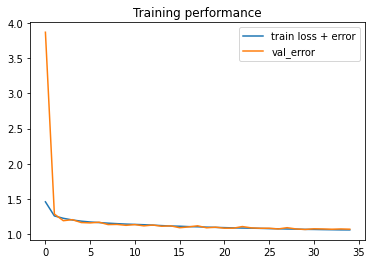

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

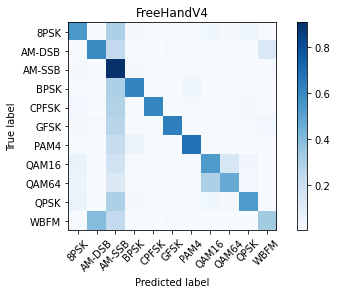

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.0887815750371471


Overall Accuracy:  0.09279112754158965


Overall Accuracy:  0.09402615765288087


Overall Accuracy:  0.11665495432185524


Overall Accuracy:  0.1398121387283237


Overall Accuracy:  0.22269960615825277


Overall Accuracy:  0.34754568255105694


Overall Accuracy:  0.47638081395348836


Overall Accuracy:  0.6336528221512248


Overall Accuracy:  0.7724658519051042


Overall Accuracy:  0.8391430646332607


Overall Accuracy:  0.8687342228633249


Overall Accuracy:  0.8850094876660342


Overall Accuracy:  0.8768656716417911


Overall Accuracy:  0.8868876080691642


Overall Accuracy:  0.8877141815530442


Overall Accuracy:  0.8789337282487968


Overall Accuracy:  0.881910492666416


Overall Accuracy:  0.8831982313927782


Overall Accuracy:  0.8831541218637993


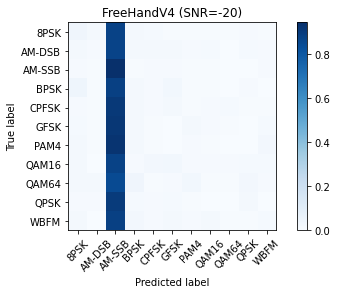

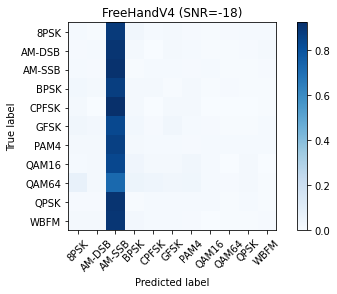

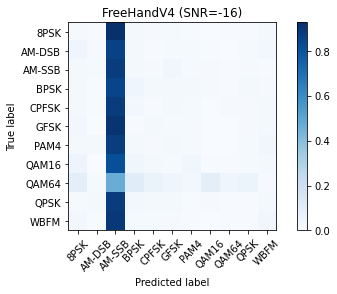

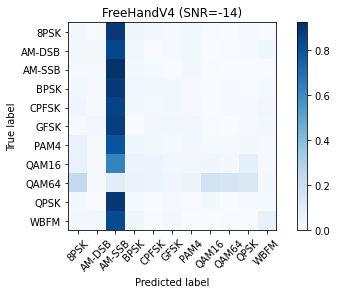

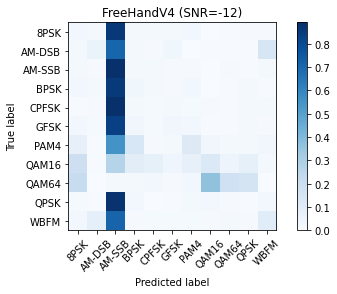

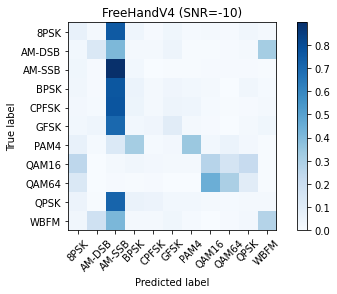

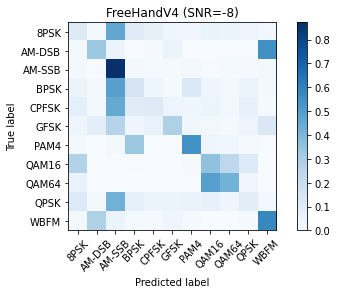

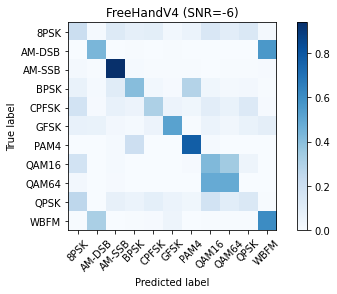

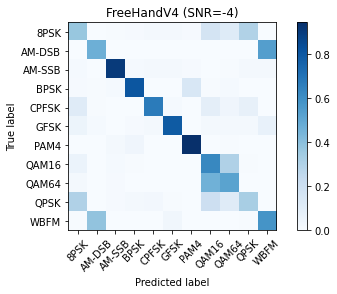

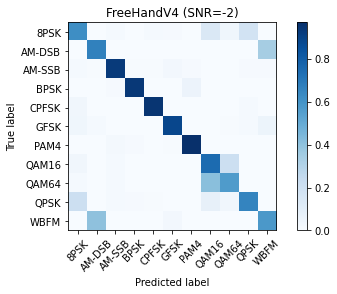

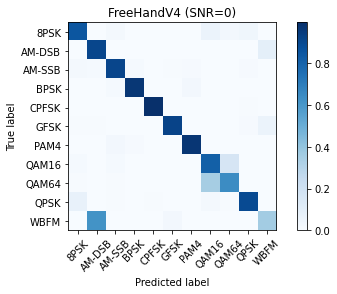

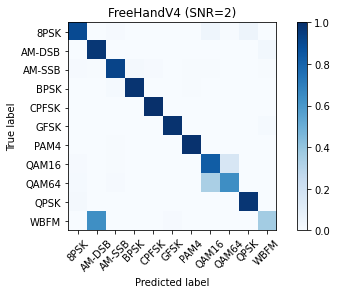

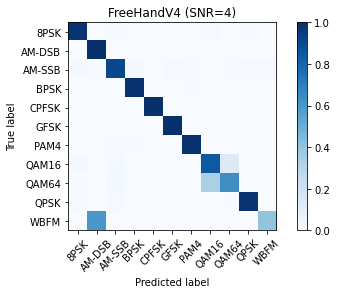

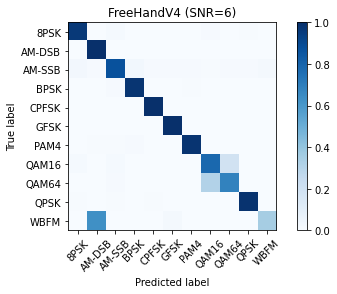

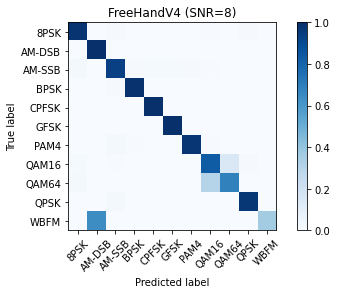

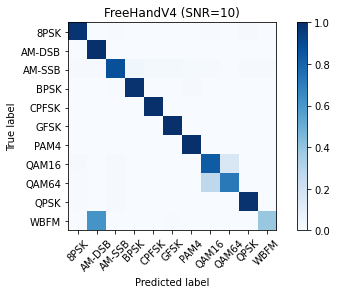

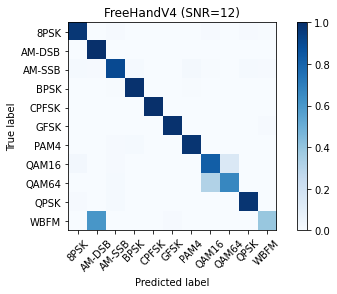

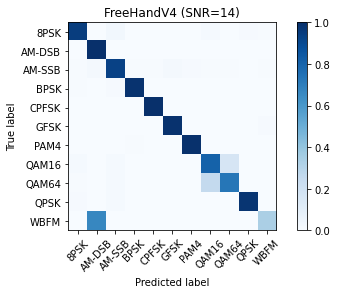

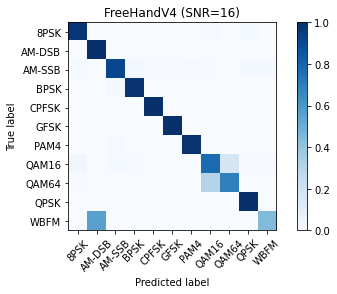

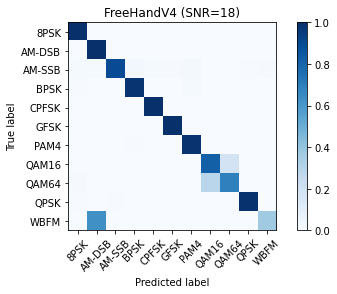

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,11,13,22,34,47,63,77,83,86,88,87,88,88,87,88,88,88


In [18]:
import statistics

statistics.mean(acc.values())

0.5878180770299667

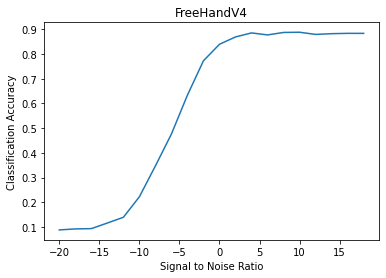

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)